In [29]:
import os

repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")

os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn 
import sys
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from mosaiks.utils.imports import *

# Key prediction functions are here
from analysis.prediction_utils import (X_matrix_to_demeaned_X, df_to_demeaned_y_vars,
                              get_within_perf_from_kfold_dict, cv_solve, solver_kwargs,
                            get_test_idxs)
                              
from analysis.prediction_utils import make_train_pred_scatterplot as make_scatterplot

#  Train HDI, IWI, and other ADM0/ADM1 level models
In this notebook we train ADM0 and ADM1 models and then evaluate at the same scale. Files needed to replicate this analysis are all included in the GitHub repository.

## Read in Xs and Ys -- and subset to training data set

### Read in MOSAIKS/RCF Xs

These daytime image feature files are included in the GitHub repository. They are also available at [mosaiks.org](mosaiks.org).

In [30]:
adm1_X = pd.read_pickle(
(data_dir + "features/mosaiks_features/"
"GDL_ADM1_polygon_X_creation_GHS_POP.p")).drop(columns="GDLCODE")

adm0_X = pd.read_pickle((data_dir + "features/mosaiks_features/"
"GDL_ADM0_polygon_X_creation_pop_weight=True_GHS_POP.p"))

adm1_X.head()

X_0       X_1       X_2       X_3       X_4       X_5       X_6  \
GDLCODE                                                                         
AFGr101  0.390123  0.678665  0.206719  0.345097  0.548497  0.842432  0.156376   
AFGr102  0.237172  0.580213  0.051948  0.626788  0.372233  0.480073  0.068213   
AFGr103  0.209468  0.437404  0.090435  0.226799  0.313359  0.542390  0.112169   
AFGr104  0.335701  0.688881  0.126453  0.547869  0.501631  0.713768  0.114022   
AFGr105  0.248126  0.545196  0.094966  0.408503  0.386341  0.611326  0.113473   

              X_7       X_8       X_9  ...    X_3990    X_3991    X_3992  \
GDLCODE                                ...                                 
AFGr101  0.381069  0.243269  0.782266  ...  0.554838  0.353894  0.964482   
AFGr102  0.089778  0.573527  0.476499  ...  0.155166  0.064067  0.270844   
AFGr103  0.217163  0.164701  0.472634  ...  0.266113  0.155918  0.542615   
AFGr104  0.221779  0.470572  0.682265  ...  0.348477  0.186285  0.607468   
AFGr105  0.197986  0.338978  0.538626  ...  0.289186  0.158021  0.537719   

           X_3993    X_3994    X_3995    X_3996    X_3997    X_3998    X_3999  
GDLCODE                                                                        
AFGr101  0.664171  0.398351  1.397979  2.602631  0.656177  0.792343  0.175051  
AFGr102  0.182315  0.141033  0.754294  0.958891  0.311541  0.530296  0.036294  
AFGr103  0.348209  0.208426  0.796623  1.569982  0.406253  0.473192  0.090176  
AFGr104  0.407335  0.269163  1.134602  1.828728  0.492681  0.702240  0.090141  
AFGr105  0.360405  0.231099  0.970265  1.547651  0.458496  0.607087  0.088386  

[5 rows x 4000 columns]

### Read in Y variables

These `Y` variables (HDI + component indicators) were cleaned and saved in the `/code/analysis/hdi_label_creation.ipynb` notebook. It is not necessary to run this notebook, but we make replication code for data cleaning available.

In [31]:
raw = pd.read_pickle( (data_dir + "int/GDL_HDI/"
                     "HDI_indicators_and_indices_clean.p") ).loc[adm1_X.index]

raw_adm0 = pd.read_pickle( (data_dir + "int/GDL_HDI/"
                     "HDI_indicators_and_indices_adm0_clean.p") ).loc[adm0_X.index]


raw.head()

ISO_Code      country  year   level  \
GDLCODE                                       
AFGr101      AFG  Afghanistan  2019  Subnat   
AFGr102      AFG  Afghanistan  2019  Subnat   
AFGr103      AFG  Afghanistan  2019  Subnat   
AFGr104      AFG  Afghanistan  2019  Subnat   
AFGr105      AFG  Afghanistan  2019  Subnat   

                                                    region     continent  \
GDLCODE                                                                    
AFGr101  Central (Kabul Wardak Kapisa Logar Parwan Panj...  Asia/Pacific   
AFGr102                Central Highlands (Bamyan Daikundi)  Asia/Pacific   
AFGr103           East (Nangarhar Kunar Laghman Nooristan)  Asia/Pacific   
AFGr104    North (Samangan Sar-e-Pul Balkh Jawzjan Faryab)  Asia/Pacific   
AFGr105      North East (Baghlan Takhar Badakhshan Kunduz)  Asia/Pacific   

         Sub-national HDI  Expected years schooling  Mean years schooling  \
GDLCODE                                                                     
AFGr101             0.561                    12.898                 4.595   
AFGr102             0.484                    12.447                 1.715   
AFGr103             0.469                     9.858                 3.071   
AFGr104             0.507                    11.456                 2.824   
AFGr105             0.454                     9.288                 2.208   

         Life expectancy  GNI per capita in thousands of US$ (2011 PPP) pop  
GDLCODE                                                                      
AFGr101           65.472                                       2615.157      
AFGr102           64.008                                       1572.594      
AFGr103           63.040                                       1550.047      
AFGr104           62.396                                       2491.727      
AFGr105           62.044                                       1802.716

### Read in NL features

These NL features are included in the GitHub repo. They are based off the VIIRS annual average masked data product for the year 2019. Replication code for creating NL features for these administrative polygons is in the `code/analysis/NL_feature_creation_and_other_NL_processing/make_viirs_nl_features_GHS_pop.ipynb.ipynb` notebook.

In [32]:
filepath = (data_dir+f"features/nl_features/GDL_HDI_polygons/viirs_percentile_binned_feats_GHS_pop_weighted_rasterio_method.p")

nl = pd.read_pickle(filepath).loc[adm1_X.index]

filepath = (data_dir+f"features/nl_features/GDL_ADM0_polygons/viirs_adm0_percentile_binned_feats_GHS_pop_weighted_rasterio_method.p")
#             
nl_adm0 = pd.read_pickle(filepath)

# nl.head()

### Add iwi as an outcome

These IWI data are downloaded from the [Global Data Lab](https://globaldatalab.org/areadata/table/iwi/) for the year 2018. We simply left join to the other indicators in the code below.

In [33]:
iwi_path = (data_dir + "raw/GDL_IWI/"
"GDL-Mean-International-Wealth-Index-(IWI)-score-of-region-data_linear_interp=True_nearest_val=8.csv")
#These specific value uses nearest neighbor linear interpolation for a max of 7 years. 
# This is consistent with treating the DHS cluster observations as a cross section
iwi = pd.read_csv(iwi_path)
# Issue in IWI data. No national observation for a select few obs (Argentina subnats). Going to drop as the data 
# quality is unreliable anyway
g = iwi.groupby("ISO_Code")
no_country = g.first()[g["Region"].agg(lambda x: "Total" not in list(x))].index
iwi = iwi.set_index("ISO_Code").drop(no_country).reset_index()
# ARG is now dropped

iwi = iwi.set_index("GDLCODE").rename(columns = {"2019":"iwi"})
iwi.loc[iwi["ISO_Code"] == "XKO","ISO_Code"] = "KSV"

iwi_adm0 = iwi[iwi["Region"] == "Total"].set_index("ISO_Code")



In [34]:
## Join the available iwi observations with the training df
## Note that IWI has some missing observations, so we just have to drop those when we run the IWI models

raw = raw.join(iwi[["iwi"]],how = "left" )
raw_adm0 = raw_adm0.join(iwi_adm0[["iwi"]], how="left")

In [35]:
iwi_missings = raw["iwi"].isnull().sum()
print(f"IWI has {iwi_missings} fewer observations than HDI. Only {len(raw)-iwi_missings} observations of iwi are available.")

IWI has 639 fewer observations than HDI. Only 1120 observations of iwi are available.


### Subset to training data

In [36]:
train_idxs = train_idxs = raw["ISO_Code"][~raw["ISO_Code"].isin(get_test_idxs())].unique()

In [37]:
# Subset dense_df to training data
train_locs = raw["ISO_Code"].isin(train_idxs)


## Subset Y variables
train_df = raw.loc[train_locs].copy()

train_df_adm0 = raw_adm0[raw_adm0.index.isin(train_idxs)].copy()

# Subset MOSAIKS Xs
train_locs = raw["ISO_Code"].isin(train_idxs)
X_train = adm1_X.loc[train_locs]
X_train_adm0 = adm0_X.loc[train_df_adm0.index]

# Subset NL Xs
X_nl = nl.loc[train_df.index]
X_nl_adm0 = nl_adm0.loc[train_df_adm0.index]


In [38]:
train_df


ISO_Code      country  year   level  \
GDLCODE                                       
AFGr101      AFG  Afghanistan  2019  Subnat   
AFGr102      AFG  Afghanistan  2019  Subnat   
AFGr103      AFG  Afghanistan  2019  Subnat   
AFGr104      AFG  Afghanistan  2019  Subnat   
AFGr105      AFG  Afghanistan  2019  Subnat   
...          ...          ...   ...     ...   
ZWEr106      ZWE     Zimbabwe  2019  Subnat   
ZWEr107      ZWE     Zimbabwe  2019  Subnat   
ZWEr108      ZWE     Zimbabwe  2019  Subnat   
ZWEr109      ZWE     Zimbabwe  2019  Subnat   
ZWEr110      ZWE     Zimbabwe  2019  Subnat   

                                                    region     continent  \
GDLCODE                                                                    
AFGr101  Central (Kabul Wardak Kapisa Logar Parwan Panj...  Asia/Pacific   
AFGr102                Central Highlands (Bamyan Daikundi)  Asia/Pacific   
AFGr103           East (Nangarhar Kunar Laghman Nooristan)  Asia/Pacific   
AFGr104    North (Samangan Sar-e-Pul Balkh Jawzjan Faryab)  Asia/Pacific   
AFGr105      North East (Baghlan Takhar Badakhshan Kunduz)  Asia/Pacific   
...                                                    ...           ...   
ZWEr106                                 Matebeleland South        Africa   
ZWEr107                                           Midlands        Africa   
ZWEr108                                           Masvingo        Africa   
ZWEr109                                             Harare        Africa   
ZWEr110                                           Bulawayo        Africa   

         Sub-national HDI  Expected years schooling  Mean years schooling  \
GDLCODE                                                                     
AFGr101             0.561                    12.898                 4.595   
AFGr102             0.484                    12.447                 1.715   
AFGr103             0.469                     9.858                 3.071   
AFGr104             0.507                    11.456                 2.824   
AFGr105             0.454                     9.288                 2.208   
...                   ...                       ...                   ...   
ZWEr106             0.592                    10.989                 7.834   
ZWEr107             0.598                    12.668                 8.492   
ZWEr108             0.596                    12.058                 8.013   
ZWEr109             0.674                    13.156                10.993   
ZWEr110             0.703                    14.115                10.405   

         Life expectancy  GNI per capita in thousands of US$ (2011 PPP) pop  \
GDLCODE                                                                       
AFGr101           65.472                                       2615.157       
AFGr102           64.008                                       1572.594       
AFGr103           63.040                                       1550.047       
AFGr104           62.396                                       2491.727       
AFGr105           62.044                                       1802.716       
...                  ...                                            ...  ..   
ZWEr106           65.423                                       3222.317       
ZWEr107           60.559                                       3540.908       
ZWEr108           64.420                                       3019.013       
ZWEr109           62.335                                       7034.498       
ZWEr110           64.784                                       9141.574       

          iwi  
GDLCODE        
AFGr101  58.0  
AFGr102  41.8  
AFGr103  41.3  
AFGr104  56.5  
AFGr105  46.2  
...       ...  
ZWEr106  40.2  
ZWEr107  43.0  
ZWEr108  38.2  
ZWEr109  63.8  
ZWEr110  71.7  

[1381 rows x 13 columns]

In [39]:
X_train.head()

X_0       X_1       X_2       X_3       X_4       X_5       X_6  \
GDLCODE                                                                         
AFGr101  0.390123  0.678665  0.206719  0.345097  0.548497  0.842432  0.156376   
AFGr102  0.237172  0.580213  0.051948  0.626788  0.372233  0.480073  0.068213   
AFGr103  0.209468  0.437404  0.090435  0.226799  0.313359  0.542390  0.112169   
AFGr104  0.335701  0.688881  0.126453  0.547869  0.501631  0.713768  0.114022   
AFGr105  0.248126  0.545196  0.094966  0.408503  0.386341  0.611326  0.113473   

              X_7       X_8       X_9  ...    X_3990    X_3991    X_3992  \
GDLCODE                                ...                                 
AFGr101  0.381069  0.243269  0.782266  ...  0.554838  0.353894  0.964482   
AFGr102  0.089778  0.573527  0.476499  ...  0.155166  0.064067  0.270844   
AFGr103  0.217163  0.164701  0.472634  ...  0.266113  0.155918  0.542615   
AFGr104  0.221779  0.470572  0.682265  ...  0.348477  0.186285  0.607468   
AFGr105  0.197986  0.338978  0.538626  ...  0.289186  0.158021  0.537719   

           X_3993    X_3994    X_3995    X_3996    X_3997    X_3998    X_3999  
GDLCODE                                                                        
AFGr101  0.664171  0.398351  1.397979  2.602631  0.656177  0.792343  0.175051  
AFGr102  0.182315  0.141033  0.754294  0.958891  0.311541  0.530296  0.036294  
AFGr103  0.348209  0.208426  0.796623  1.569982  0.406253  0.473192  0.090176  
AFGr104  0.407335  0.269163  1.134602  1.828728  0.492681  0.702240  0.090141  
AFGr105  0.360405  0.231099  0.970265  1.547651  0.458496  0.607087  0.088386  

[5 rows x 4000 columns]

In [40]:
train_df

ISO_Code      country  year   level  \
GDLCODE                                       
AFGr101      AFG  Afghanistan  2019  Subnat   
AFGr102      AFG  Afghanistan  2019  Subnat   
AFGr103      AFG  Afghanistan  2019  Subnat   
AFGr104      AFG  Afghanistan  2019  Subnat   
AFGr105      AFG  Afghanistan  2019  Subnat   
...          ...          ...   ...     ...   
ZWEr106      ZWE     Zimbabwe  2019  Subnat   
ZWEr107      ZWE     Zimbabwe  2019  Subnat   
ZWEr108      ZWE     Zimbabwe  2019  Subnat   
ZWEr109      ZWE     Zimbabwe  2019  Subnat   
ZWEr110      ZWE     Zimbabwe  2019  Subnat   

                                                    region     continent  \
GDLCODE                                                                    
AFGr101  Central (Kabul Wardak Kapisa Logar Parwan Panj...  Asia/Pacific   
AFGr102                Central Highlands (Bamyan Daikundi)  Asia/Pacific   
AFGr103           East (Nangarhar Kunar Laghman Nooristan)  Asia/Pacific   
AFGr104    North (Samangan Sar-e-Pul Balkh Jawzjan Faryab)  Asia/Pacific   
AFGr105      North East (Baghlan Takhar Badakhshan Kunduz)  Asia/Pacific   
...                                                    ...           ...   
ZWEr106                                 Matebeleland South        Africa   
ZWEr107                                           Midlands        Africa   
ZWEr108                                           Masvingo        Africa   
ZWEr109                                             Harare        Africa   
ZWEr110                                           Bulawayo        Africa   

         Sub-national HDI  Expected years schooling  Mean years schooling  \
GDLCODE                                                                     
AFGr101             0.561                    12.898                 4.595   
AFGr102             0.484                    12.447                 1.715   
AFGr103             0.469                     9.858                 3.071   
AFGr104             0.507                    11.456                 2.824   
AFGr105             0.454                     9.288                 2.208   
...                   ...                       ...                   ...   
ZWEr106             0.592                    10.989                 7.834   
ZWEr107             0.598                    12.668                 8.492   
ZWEr108             0.596                    12.058                 8.013   
ZWEr109             0.674                    13.156                10.993   
ZWEr110             0.703                    14.115                10.405   

         Life expectancy  GNI per capita in thousands of US$ (2011 PPP) pop  \
GDLCODE                                                                       
AFGr101           65.472                                       2615.157       
AFGr102           64.008                                       1572.594       
AFGr103           63.040                                       1550.047       
AFGr104           62.396                                       2491.727       
AFGr105           62.044                                       1802.716       
...                  ...                                            ...  ..   
ZWEr106           65.423                                       3222.317       
ZWEr107           60.559                                       3540.908       
ZWEr108           64.420                                       3019.013       
ZWEr109           62.335                                       7034.498       
ZWEr110           64.784                                       9141.574       

          iwi  
GDLCODE        
AFGr101  58.0  
AFGr102  41.8  
AFGr103  41.3  
AFGr104  56.5  
AFGr105  46.2  
...       ...  
ZWEr106  40.2  
ZWEr107  43.0  
ZWEr108  38.2  
ZWEr109  63.8  
ZWEr110  71.7  

[1381 rows x 13 columns]

### Create demeaned feature sets

This demeaned Xs are needed for the within-country models.

In [26]:
X_demeaned = X_matrix_to_demeaned_X(X_train)
X_demeaned_nl = X_matrix_to_demeaned_X(X_nl)

### Set some basic solve parameters:

In [28]:
tasks = ['Sub-national HDI', 
         "Life expectancy", 
         "Mean years schooling", 
         "Expected years schooling",
         "GNI per capita in thousands of US$ (2011 PPP)",
          "iwi",
        ]

log_task = {'Sub-national HDI': False,
              "Life expectancy": False,
               "Mean years schooling" : False,
               "Expected years schooling" : False,
               "GNI per capita in thousands of US$ (2011 PPP)" : True,
               "iwi":False}


rescale_lambdas = np.hstack([1,(np.logspace(-3,6,8)**.3)])
rescale_lambdas.sort()


model_directory = data_dir + "model_data/"

train_df.to_pickle(model_directory+"full_training_df.p") #save for Fig 2

In [14]:
def get_idxs_without_adm0_observations(df, country_col = "ISO_Code"):
    """
    For country-demeaned outcomes, we want to remove all the ADM0 level observations. 
    
    In other words, if there is no within-country we shouldn't keep this as training data
    
    """
    col = tasks[0]
    g = df.groupby("ISO_Code")
    
    country_counts = train_df.groupby(country_col)[col].count() 

    adm0_idxs = country_counts[country_counts == 1].index
    adm1_idxs = df.reset_index().set_index("ISO_Code").drop(adm0_idxs).set_index(df.index.name).index
    
    assert len(adm1_idxs) == len(df)-len(adm0_idxs)
    
    return adm1_idxs

# Begin running solves

### Cross country model  - RCF only

Sub-national HDI
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Sub-national HDI...
Life expectancy
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Life expectancy...
Mean years schooling
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Mean years schooling...
Expected years schooling
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Expected years schooling...
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting GNI per capita in thousands of US$ (2011 PPP)...
iwi
519


/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 519 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting iwi...


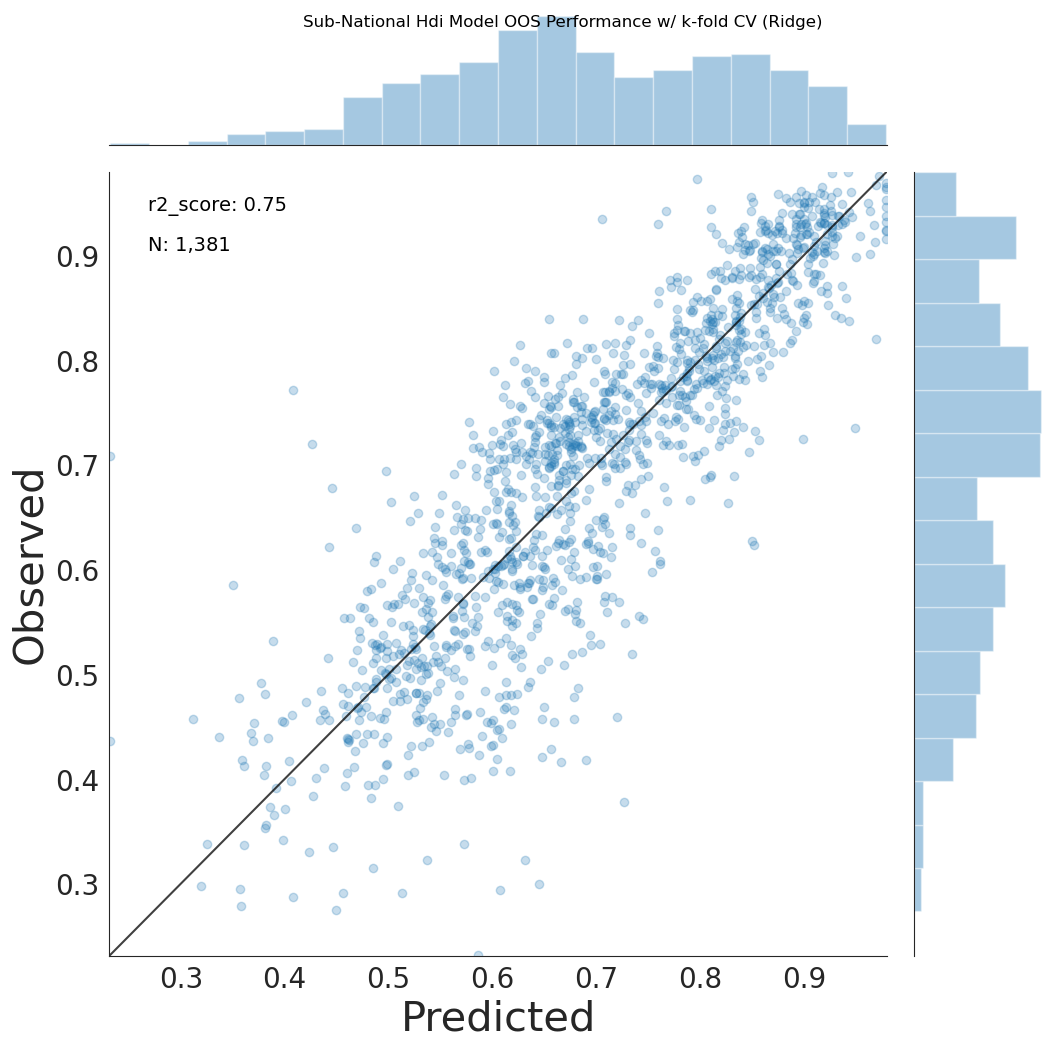

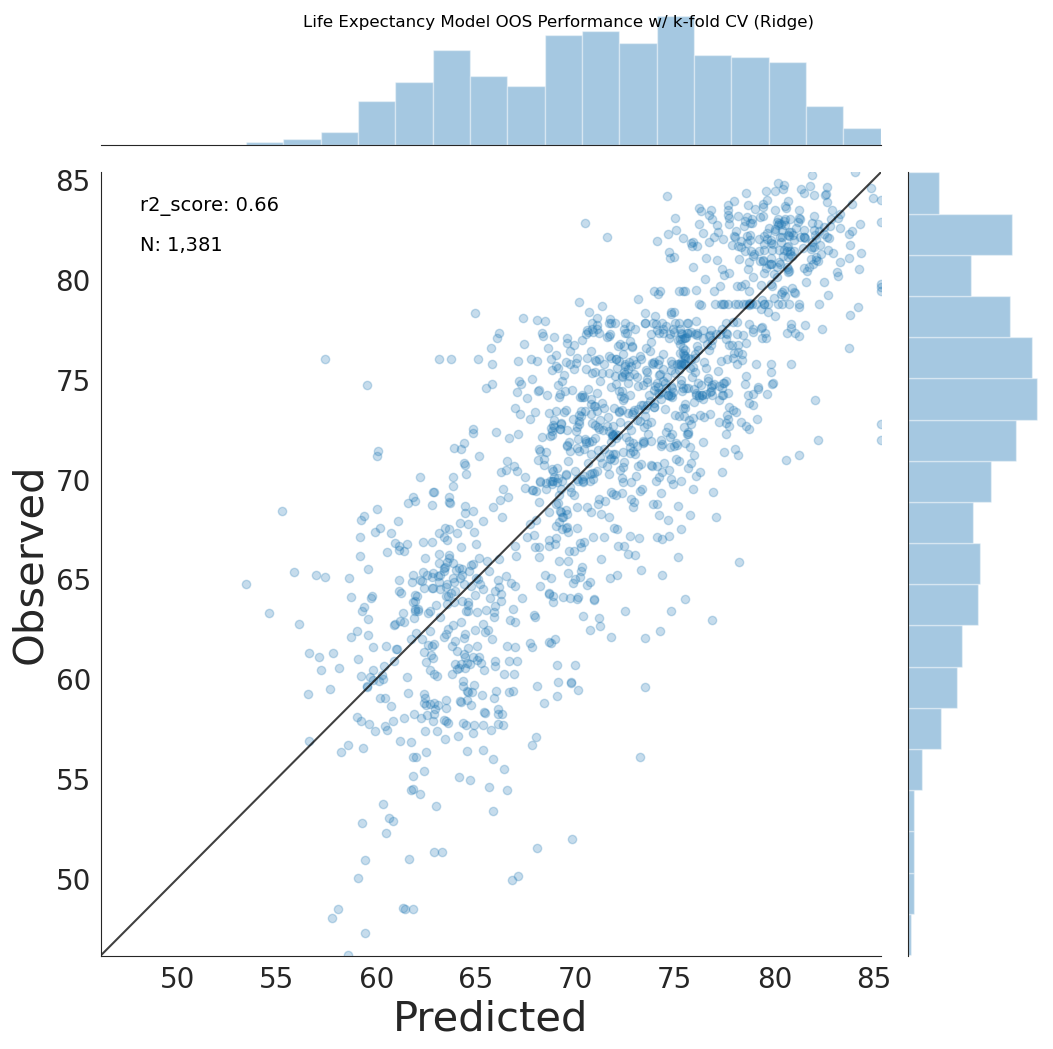

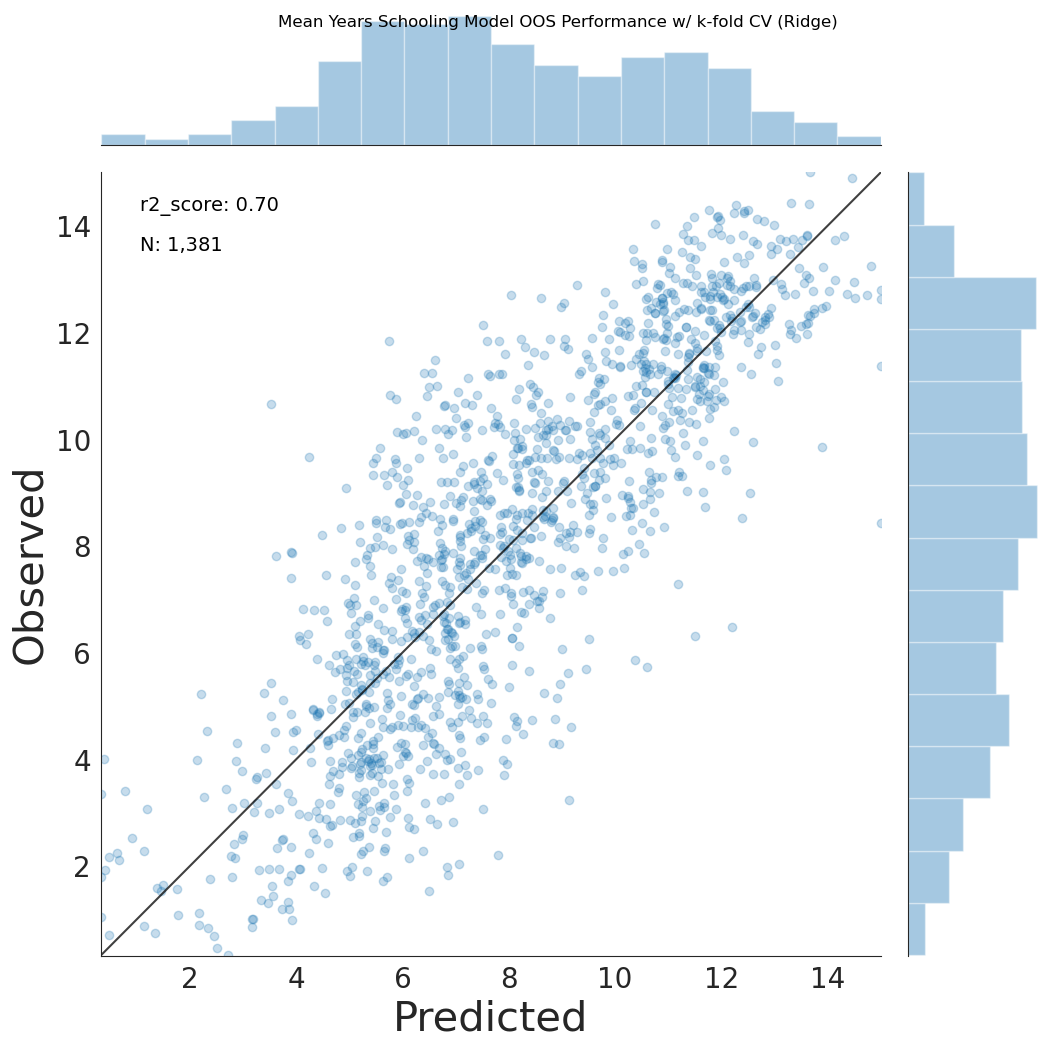

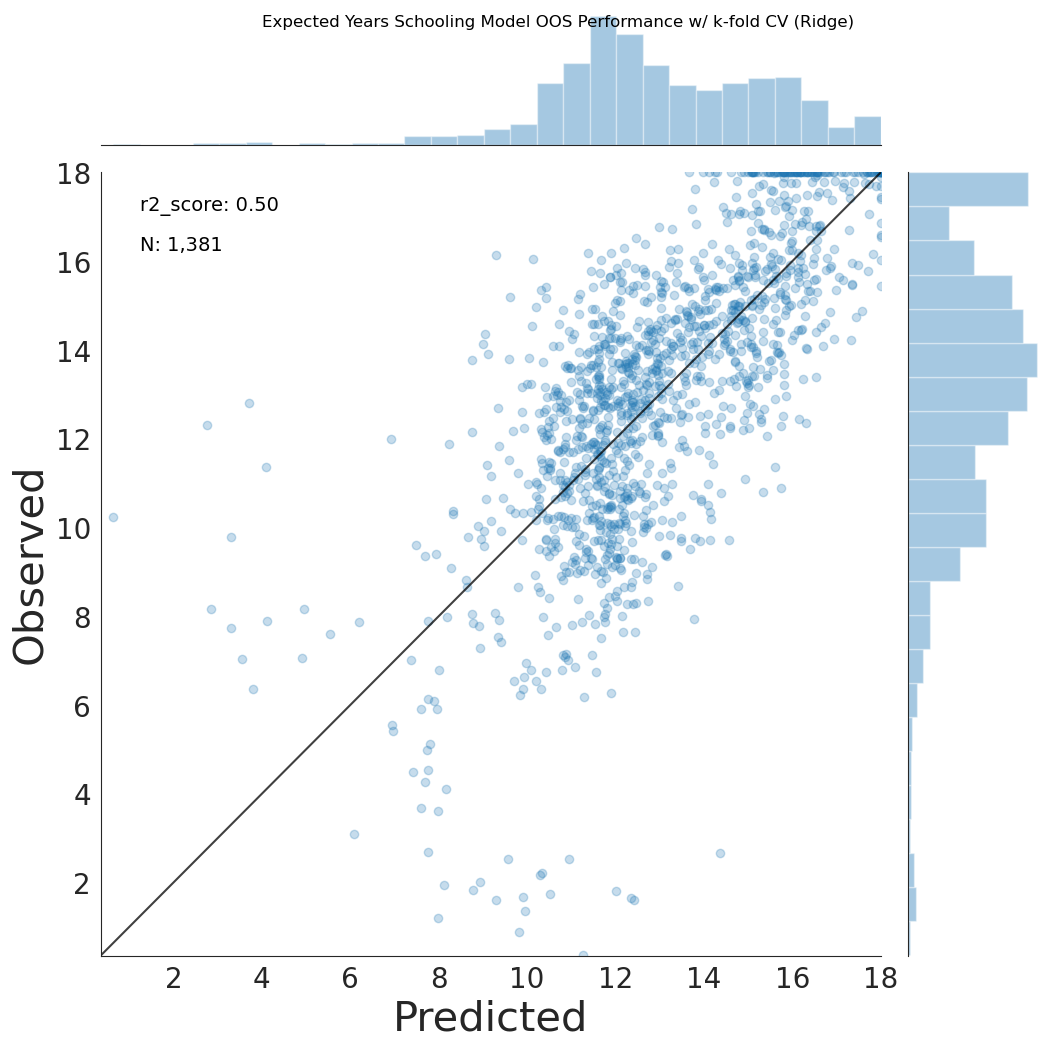

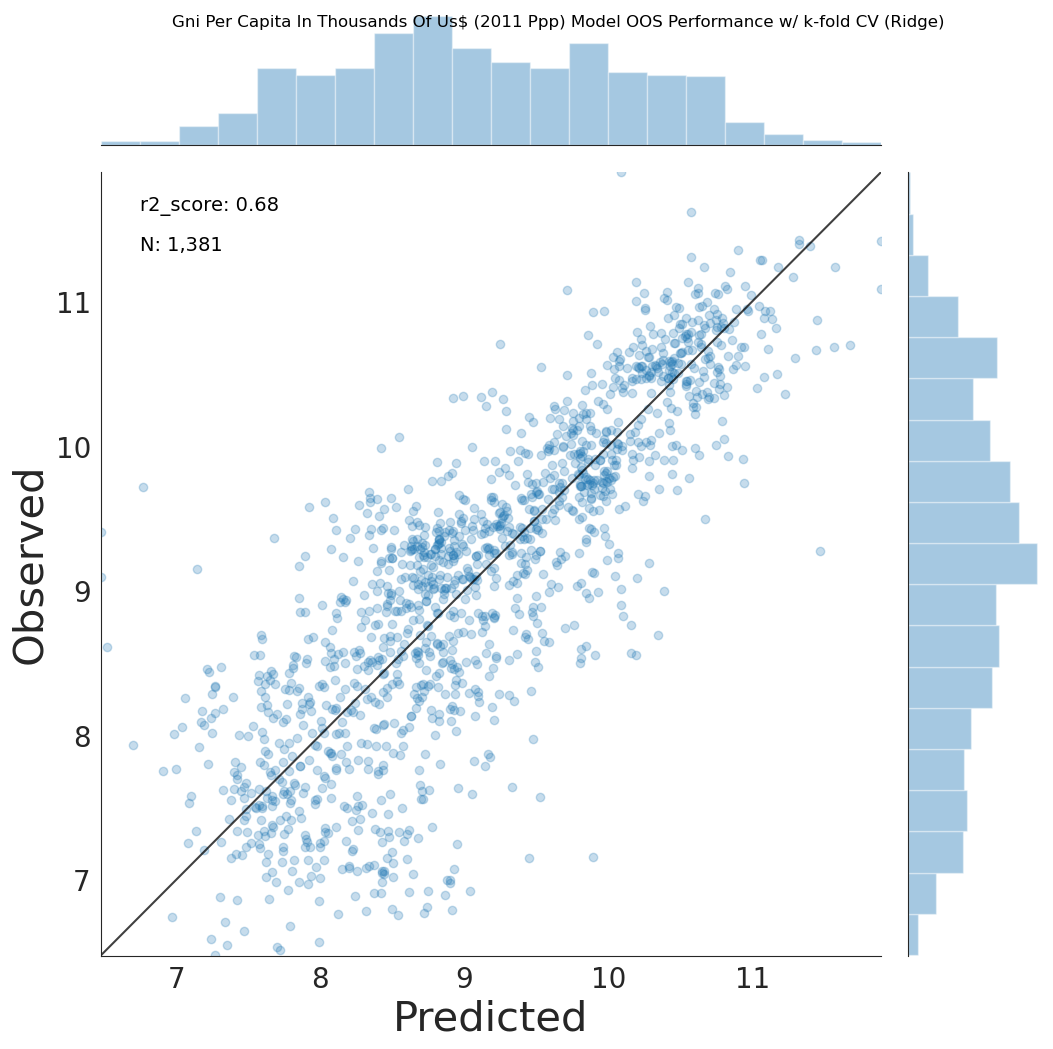

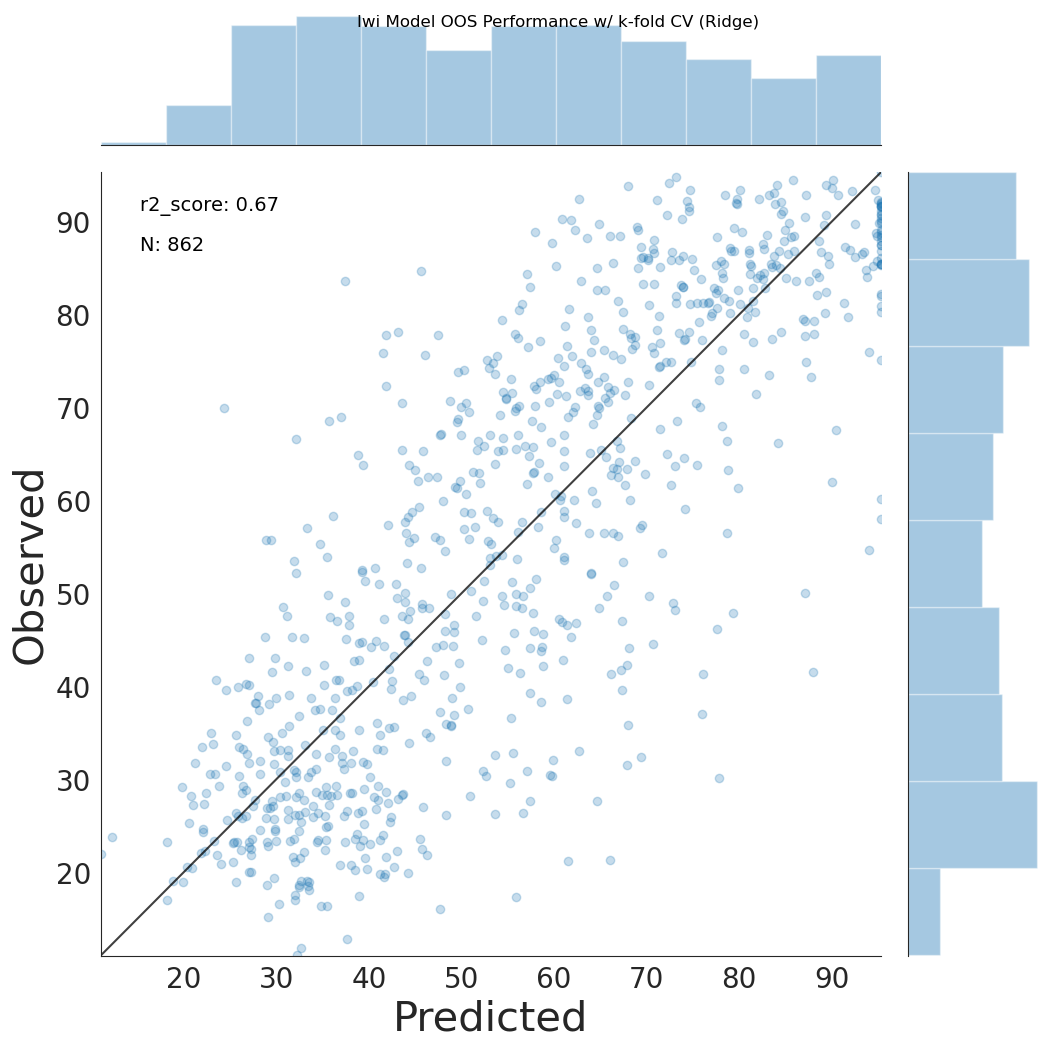

In [15]:
kfold_dict = {}

for task in tasks:
    Y_train = train_df[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    kfold_dict[task]  = cv_solve(task,
                                    X_train,
                                    Y_train,
                                    clip_bounds = [np.min(Y_train), np.max(Y_train)], 
                                 country_fold = True)

In [29]:
outpath = (model_directory+
           "cross_country_kfold_solve_all_outcomes_country_fold_DENSE_pop_weight=GHS_POP.pkl")
pickle.dump(kfold_dict, open(outpath, "wb"))
kfold_dict = pickle.load(open(outpath, "rb"))

cc_rcf_perf_dict = {}
n_adm1 = {}

for task in tasks:
    cc_rcf_perf_dict[task] = get_within_perf_from_kfold_dict(kfold_dict, task, metric="ALL")
    n_adm1[task] = len(np.hstack(kfold_dict[task]["locations_test"]))
    

### Within country model (demeaned outcomes) - RCF only

Zero obs dropped = 18
Sub-national HDI
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Sub-national HDI...
Zero obs dropped = 18
Life expectancy
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Life expectancy...
Zero obs dropped = 18
Mean years schooling
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Mean years schooling...
Zero obs dropped = 18
Expected years schooling
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Expected years schooling...
Zero obs dropped = 18
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting GNI per capita in thousands of US$ (2011 PPP)...
Zero obs dropped = 18
iwi
501
Training model...

on fold (of 5): 0 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 501 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting iwi...


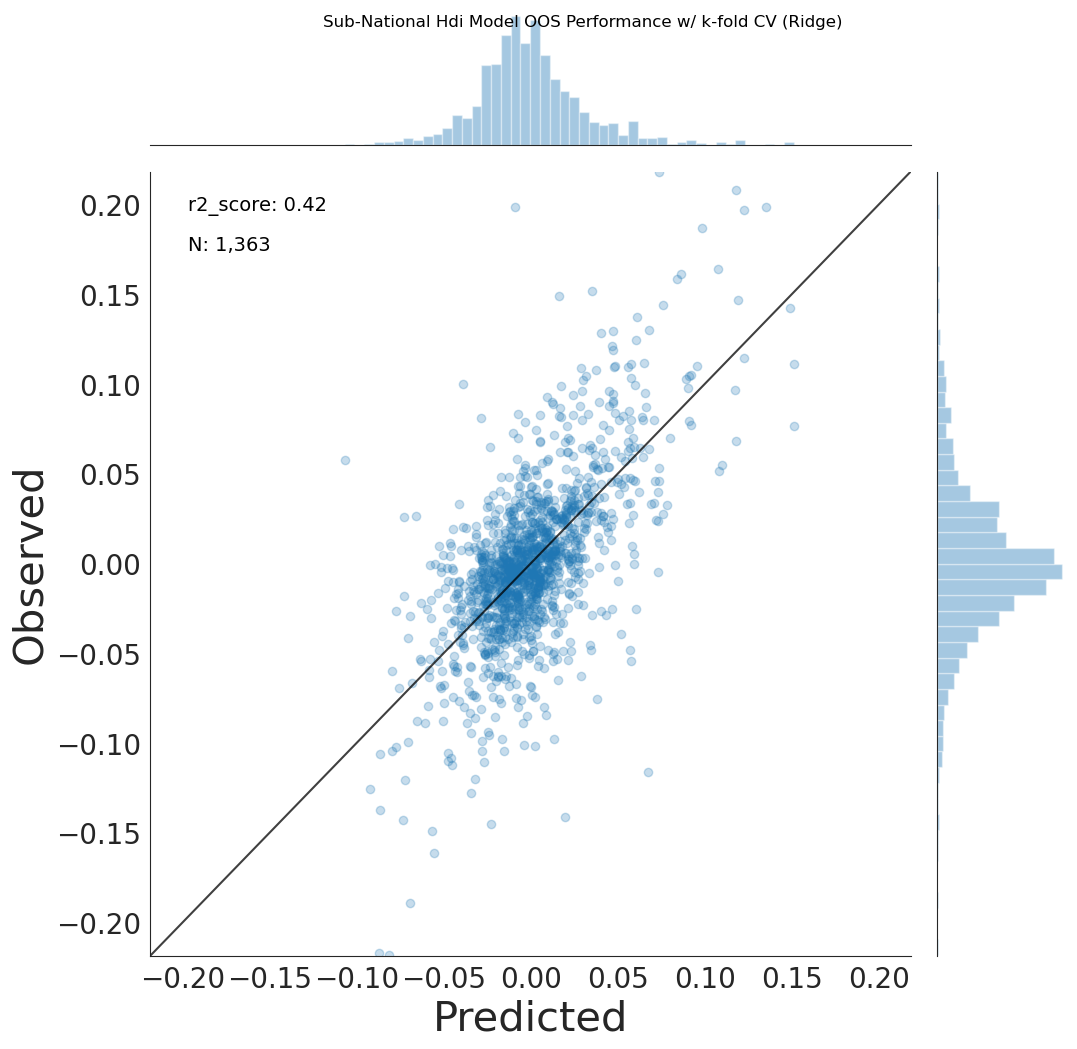

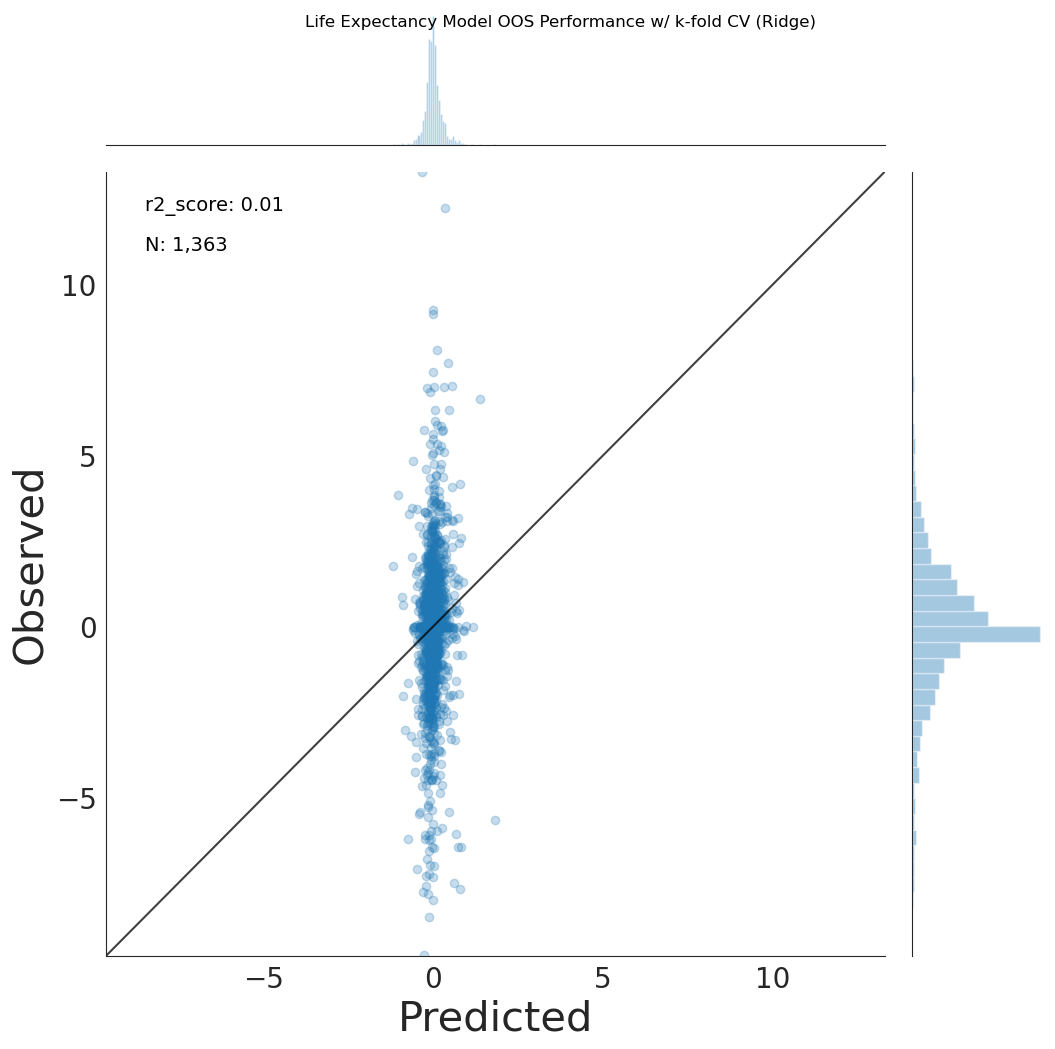

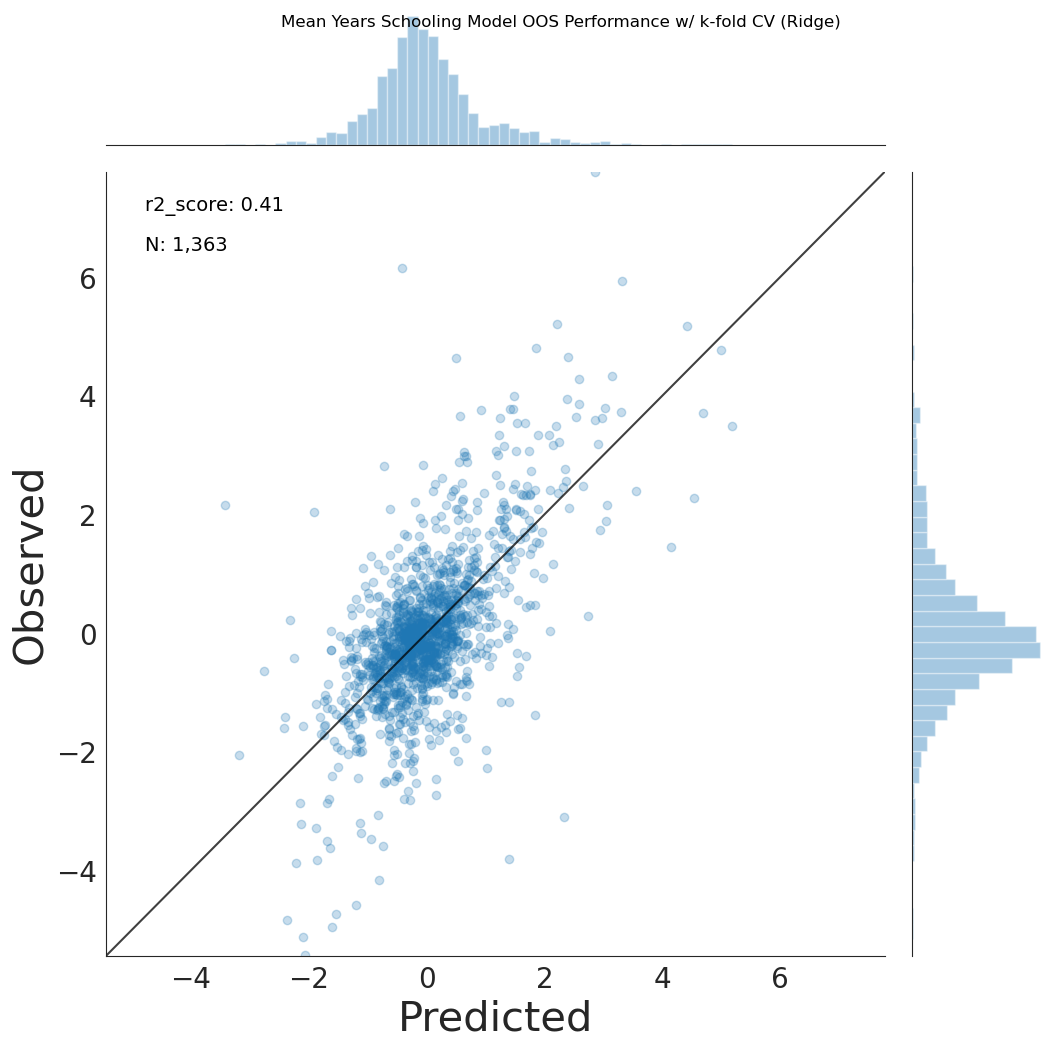

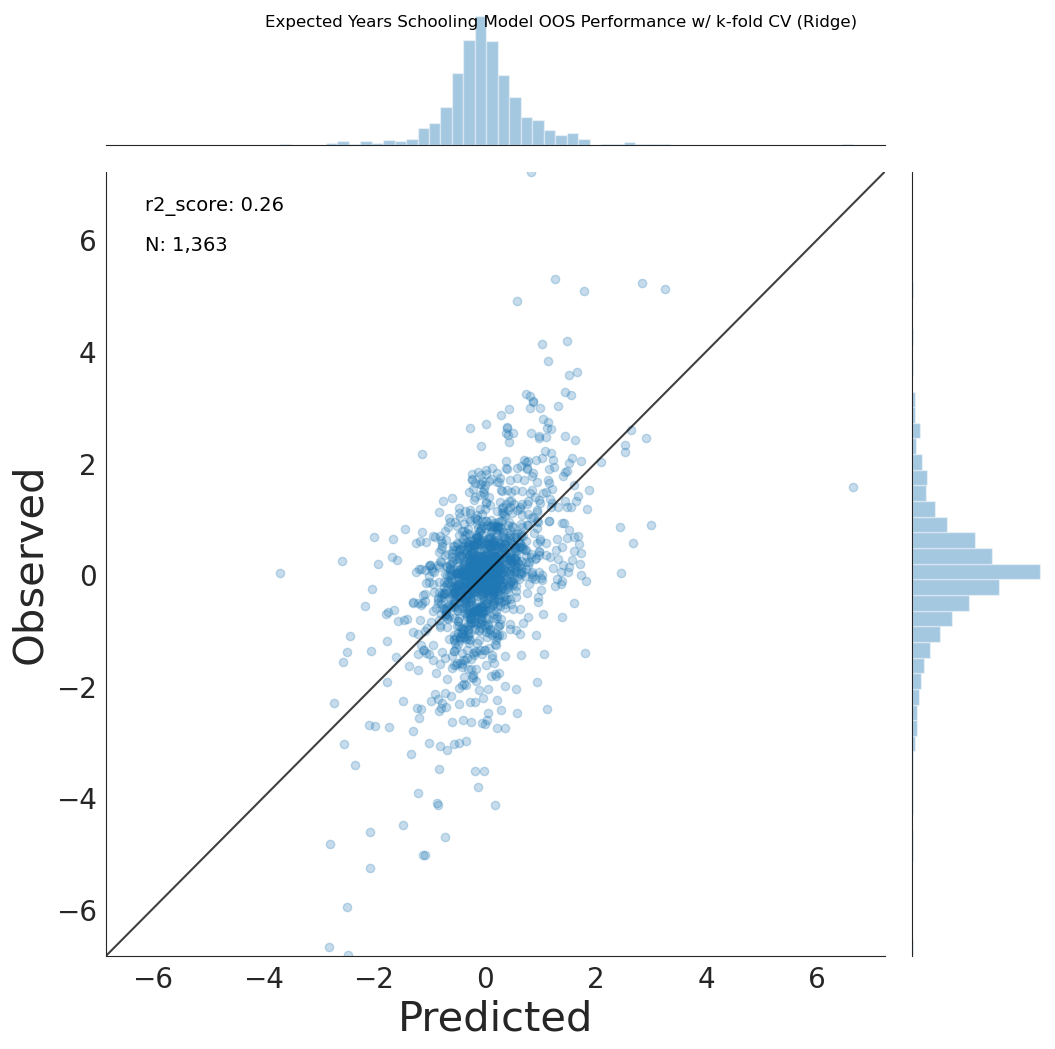

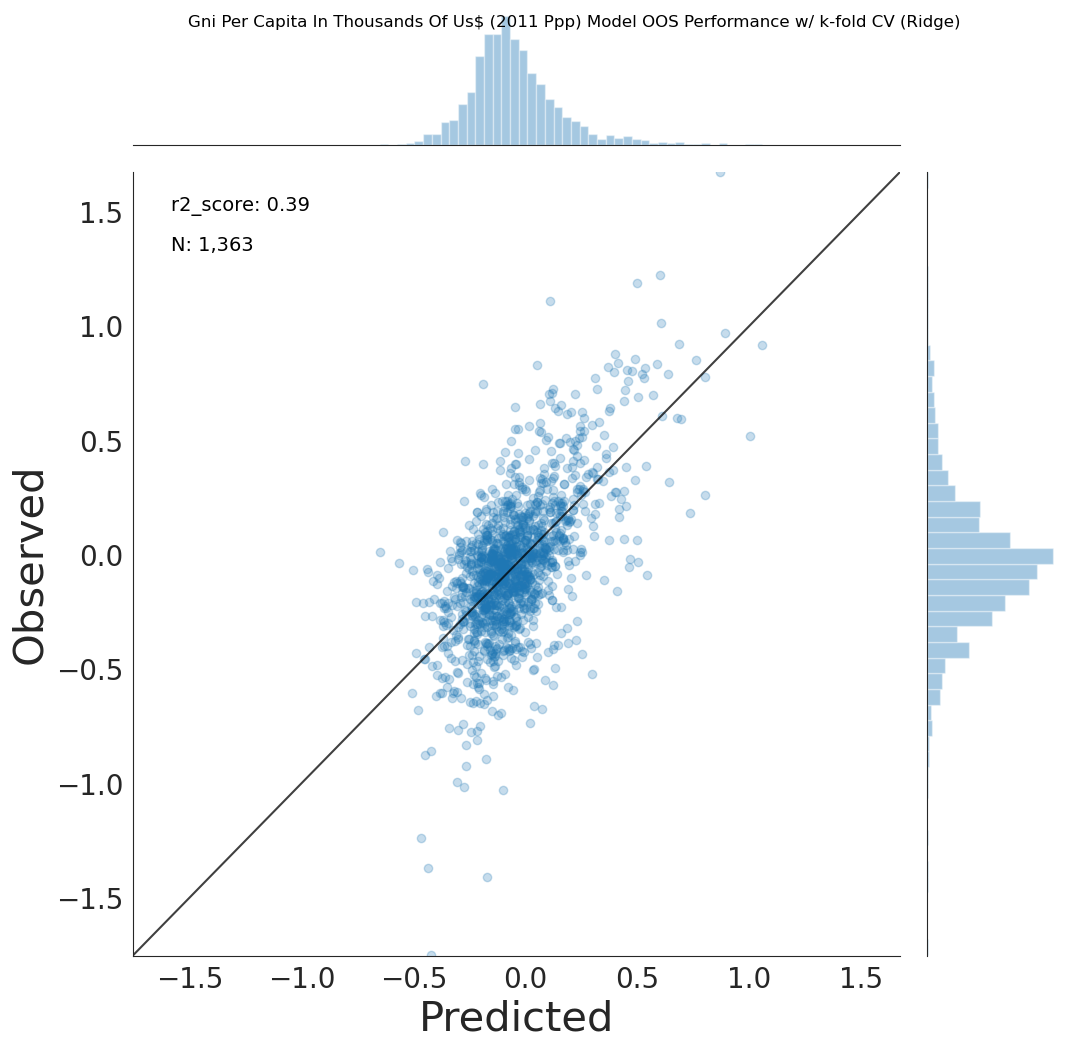

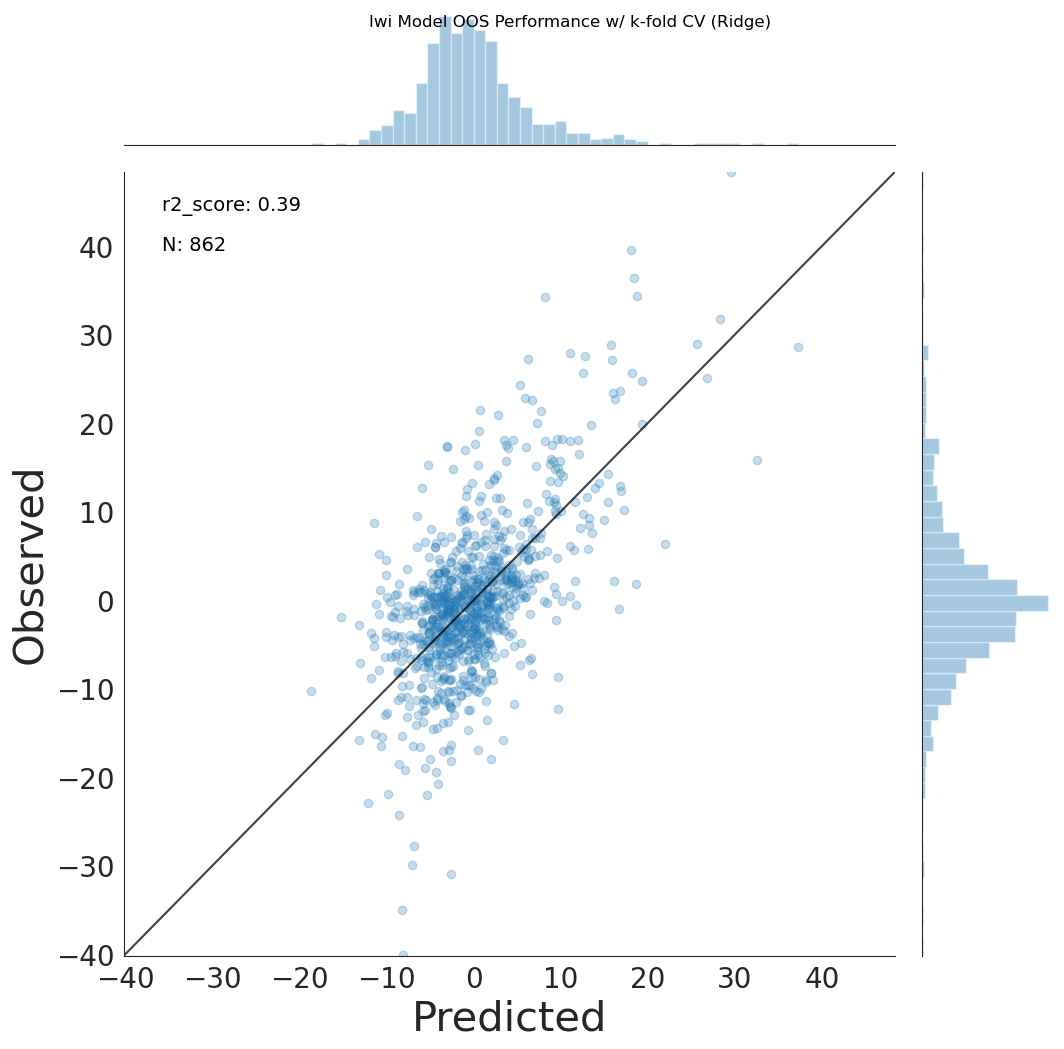

In [17]:
demeaned_kfold_dict = {}

for task in tasks:
    Y_demeaned = df_to_demeaned_y_vars(task, train_df, log_before_diff = log_task[task])
    
    ##Let's drop Y observations that do not have any within country variation. There is nothing to learn from these:
    keep_indxs = get_idxs_without_adm0_observations(train_df)
    Y_demeaned = Y_demeaned.loc[keep_indxs]
    X_demeaned_dropped = X_demeaned.loc[keep_indxs]
    
    print("Zero obs dropped =",(len(X_demeaned) - len(X_demeaned_dropped)))
    
    demeaned_kfold_dict[task]  = cv_solve(
        task,
        X_demeaned_dropped,
        Y_demeaned,
        clip_bounds = [np.min(Y_demeaned), np.max(Y_demeaned)],
        country_fold = True)

In [30]:
outpath = (model_directory+
           "within_country_demeaned_kfold_solve_all_outcomes_country_fold_DENSE_pop_weight=GHS_POP.pkl")
pickle.dump(demeaned_kfold_dict, open(outpath, "wb"))
demeaned_kfold_dict = pickle.load(open(outpath, "rb"))


demean_rcf_perf_dict = {}

n_demean = {}
for task in tasks:
    demean_rcf_perf_dict[task] = get_within_perf_from_kfold_dict(demeaned_kfold_dict, task, metric="ALL",
                                                                demeaned_input=True, not_demeaned_df=train_df,
                                                                 logged=log_task[task])
    n_demean[task] =  len(np.hstack(demeaned_kfold_dict[task]["locations_test"]))

### NL only model 

Sub-national HDI
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Sub-national HDI...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Life expectancy
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Life expectancy...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Mean years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Mean years schooling...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Expected years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Expected years schooling...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting GNI per capita in thousands of US$ (2011 PPP)...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 519 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


iwi
519
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting iwi...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


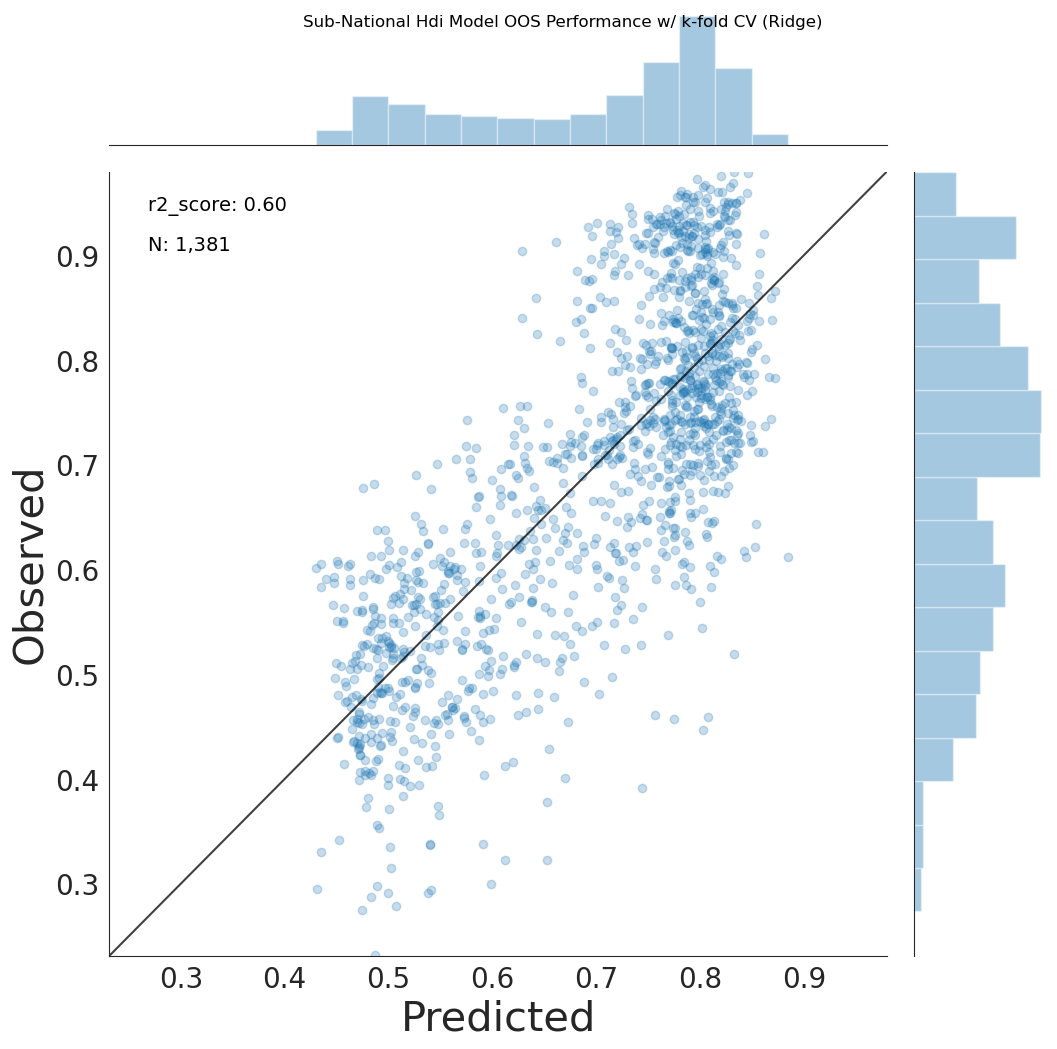

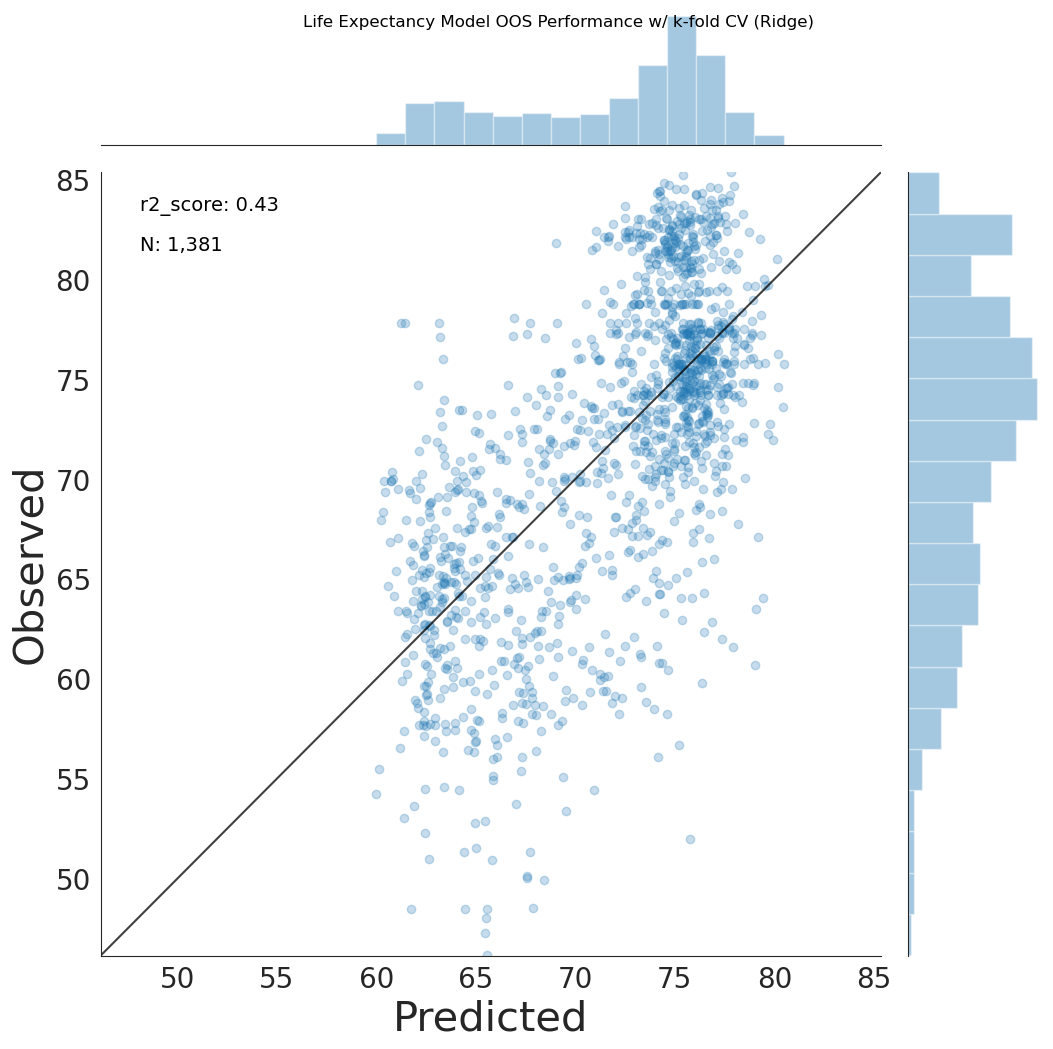

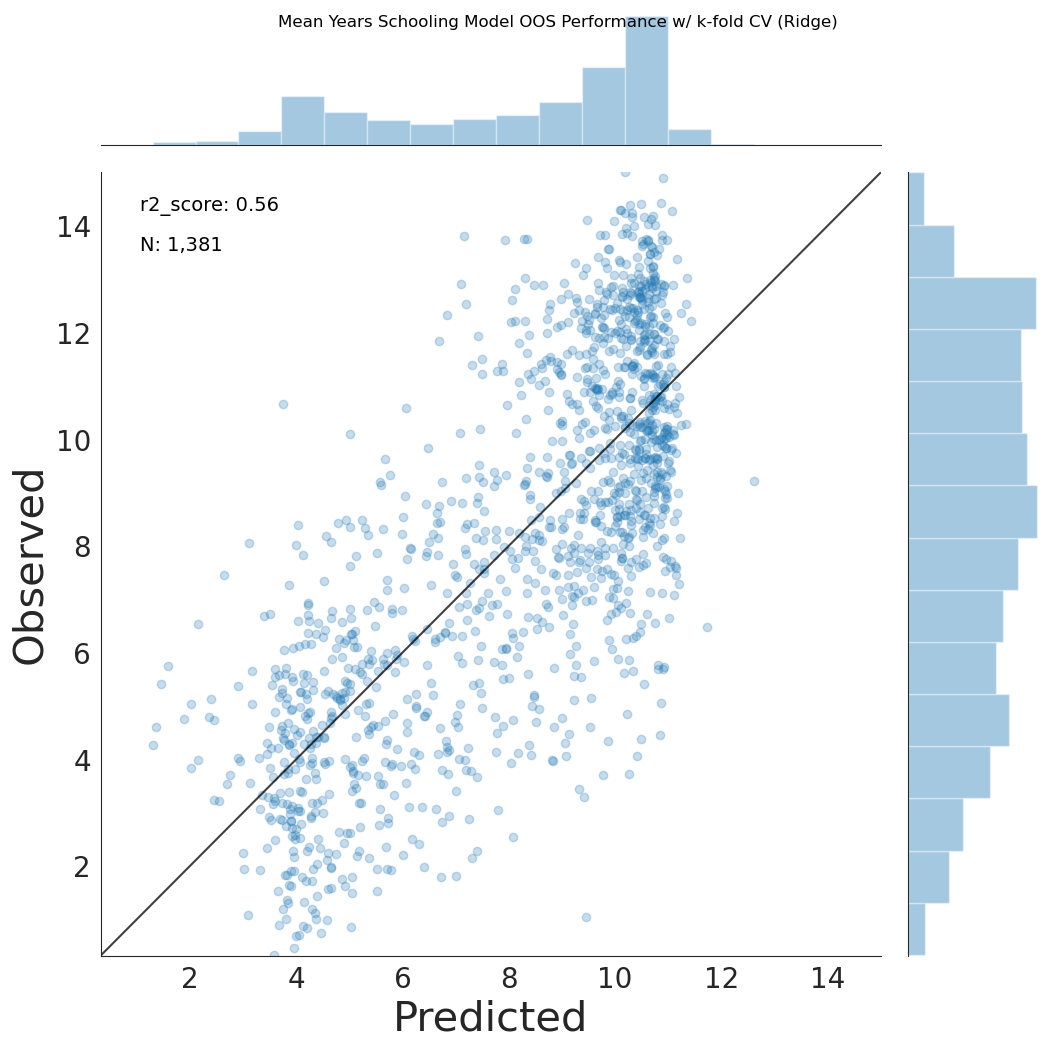

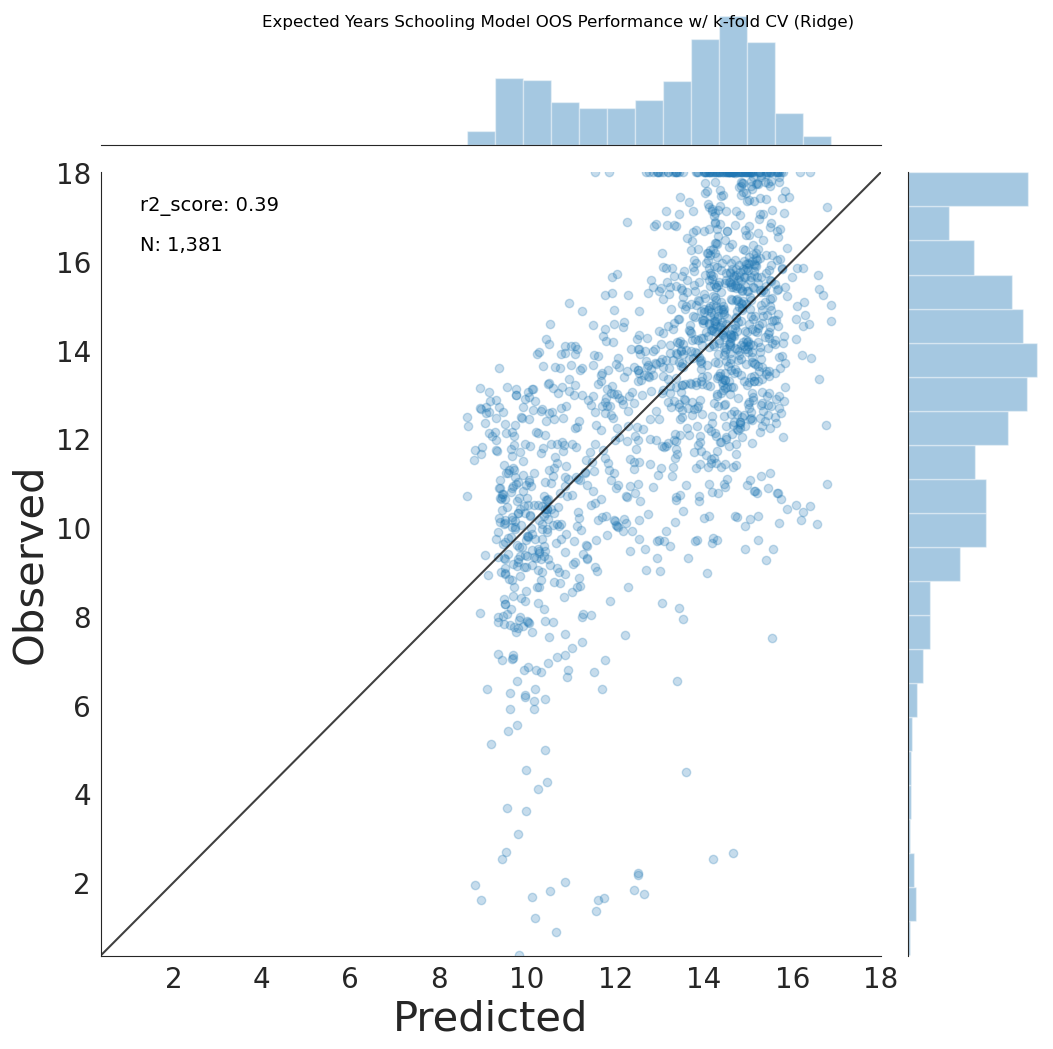

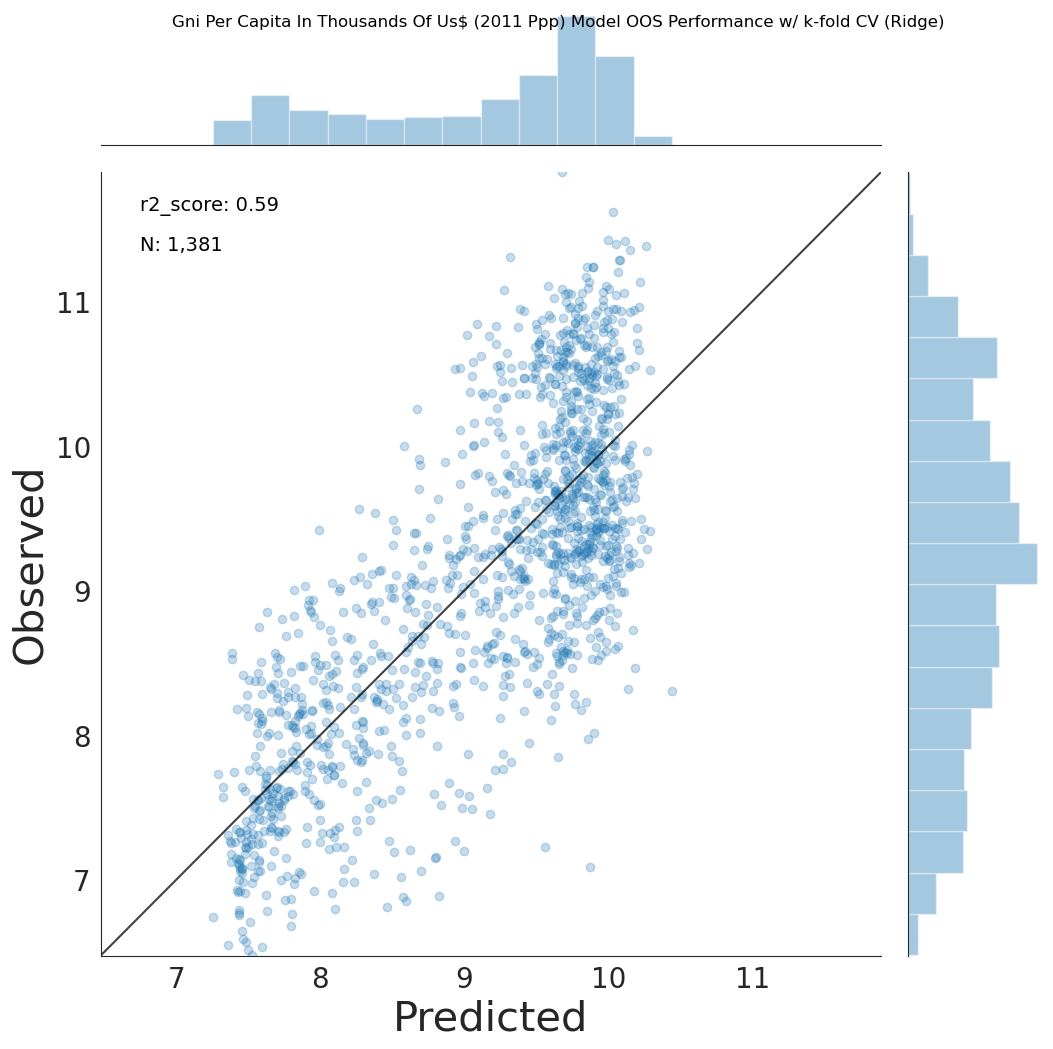

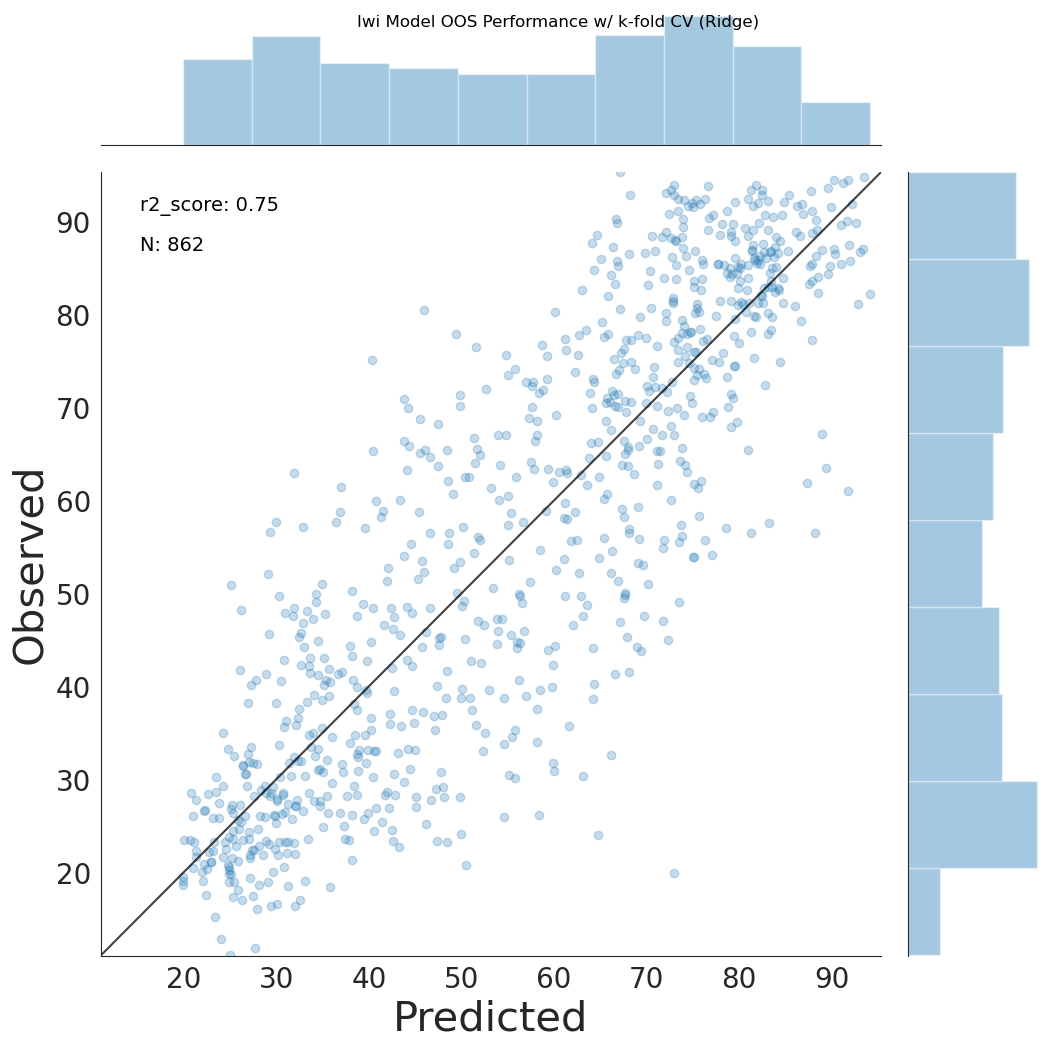

In [19]:
nl_kfold_dict = {}

for task in tasks:
    Y_train = train_df[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    nl_kfold_dict[task] = cv_solve(task,
                                   X_nl,
                                   Y_train,
                                   clip_bounds = [np.min(Y_train), np.max(Y_train)],
                                    country_fold = True
                                  )

In [31]:
outpath = (model_directory+
           "cross_country_nl_solve_all_outcomes_country_fold_VIIRS_hist_bins_GHS_pop_weighted.pkl")
pickle.dump(nl_kfold_dict, open(outpath, "wb"))
nl_kfold_dict = pickle.load(open(outpath, "rb"))


cc_nl_perf_dict = {}
for task in tasks:
    cc_nl_perf_dict[task] = get_within_perf_from_kfold_dict(nl_kfold_dict, task, metric="ALL")
    
    

###  NL only - demeaned

Zero obs dropped = 18
Sub-national HDI
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Sub-national HDI...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Zero obs dropped = 18
Life expectancy
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Life expectancy...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Zero obs dropped = 18
Mean years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Mean years schooling...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Zero obs dropped = 18
Expected years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Expected years schooling...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Zero obs dropped = 18
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting GNI per capita in thousands of US$ (2011 PPP)...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Zero obs dropped = 18
iwi
501
Training model...

on fold (of 5): 0 1 2 3 4 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 501 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")




Plotting iwi...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


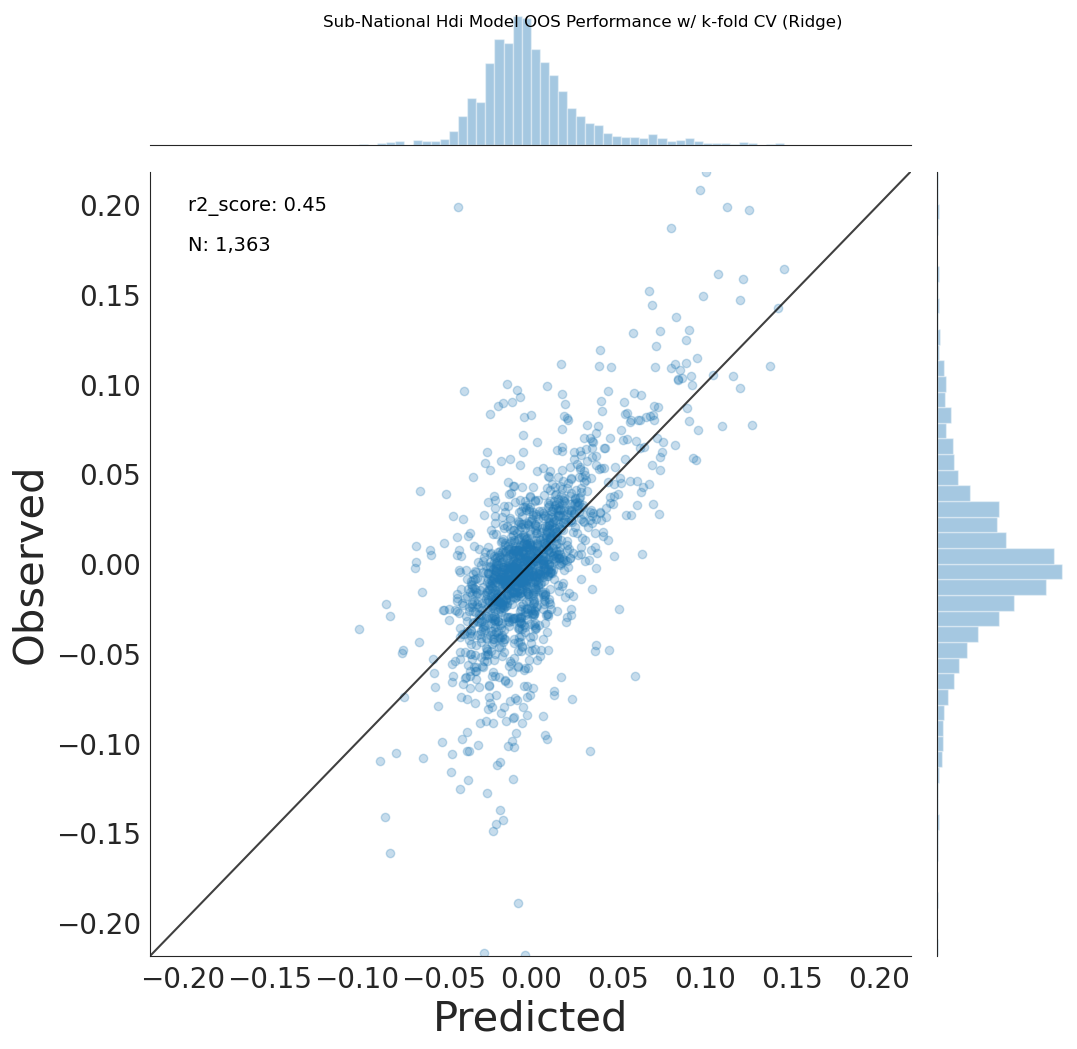

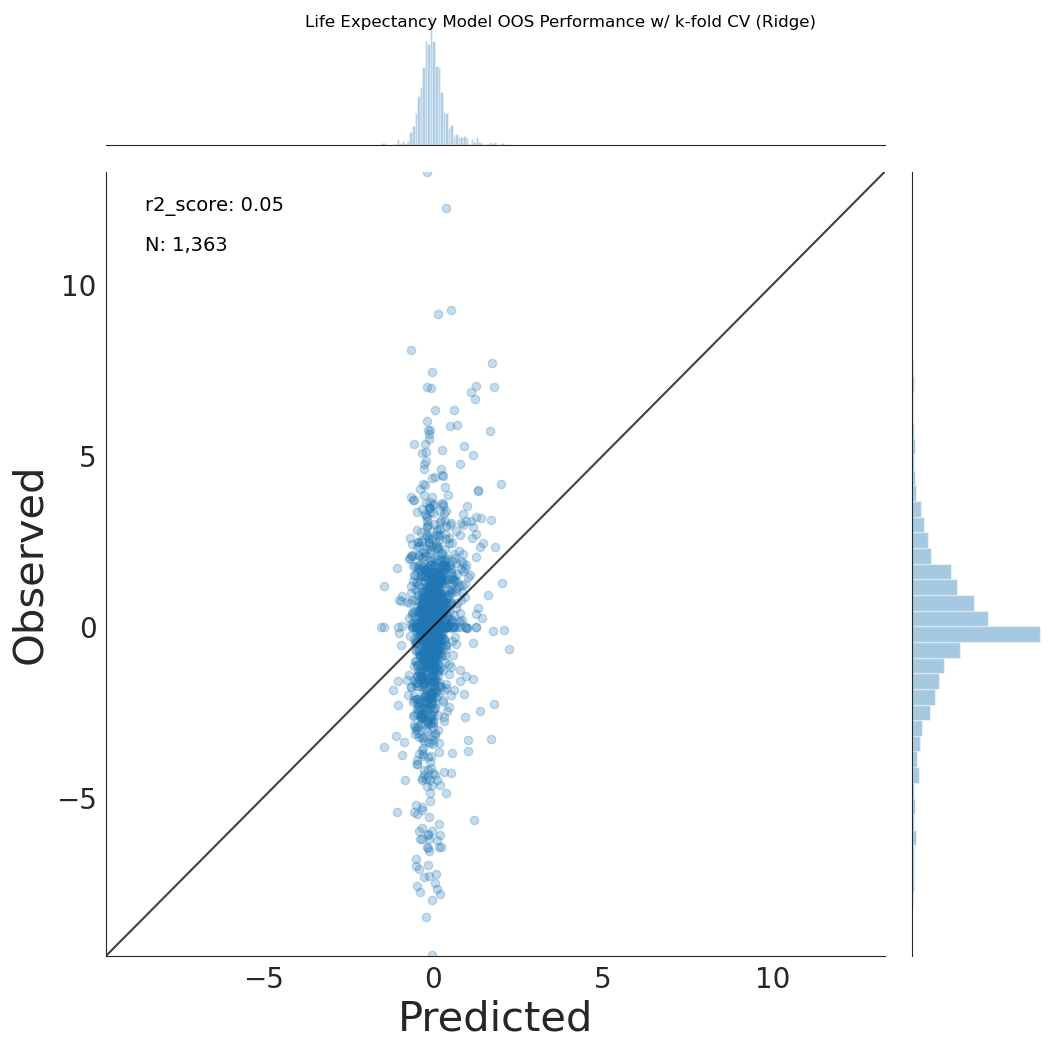

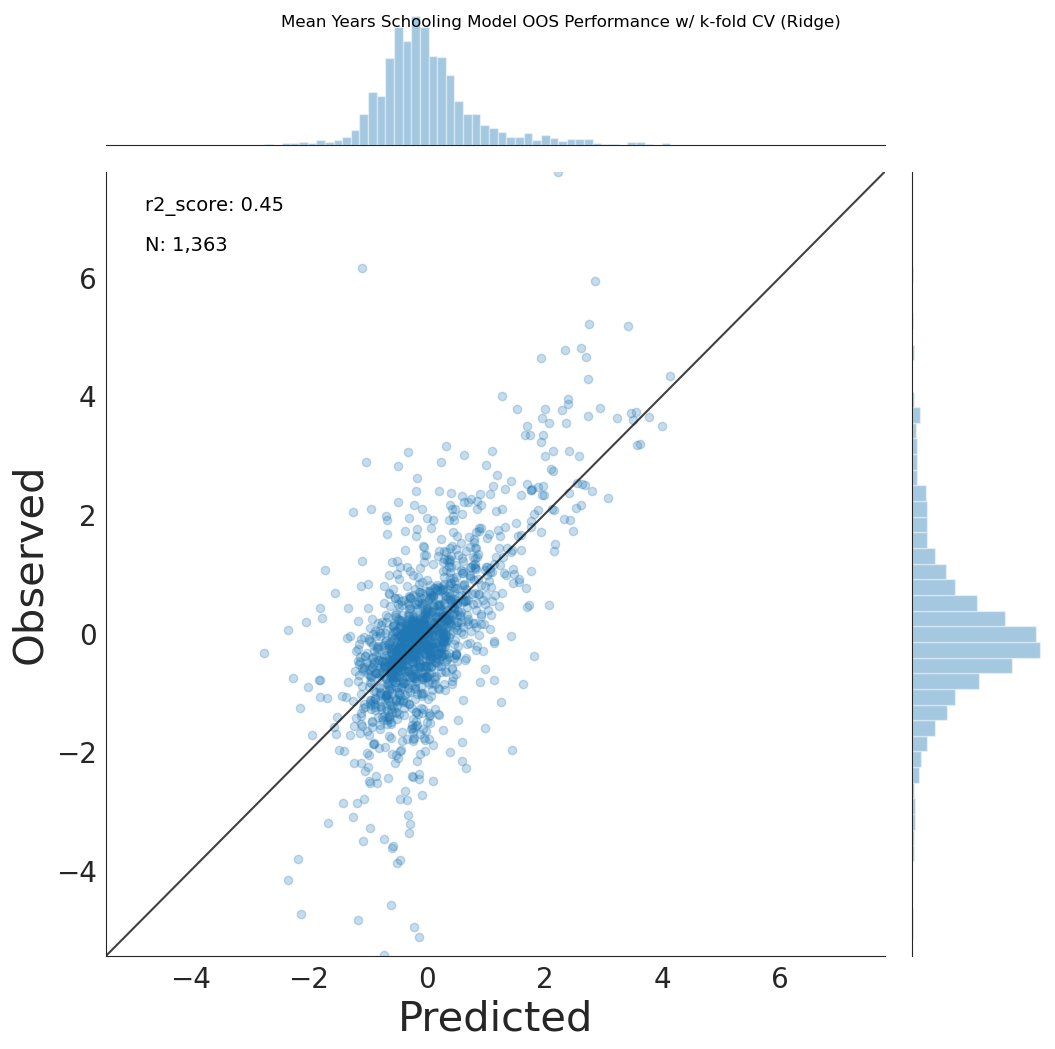

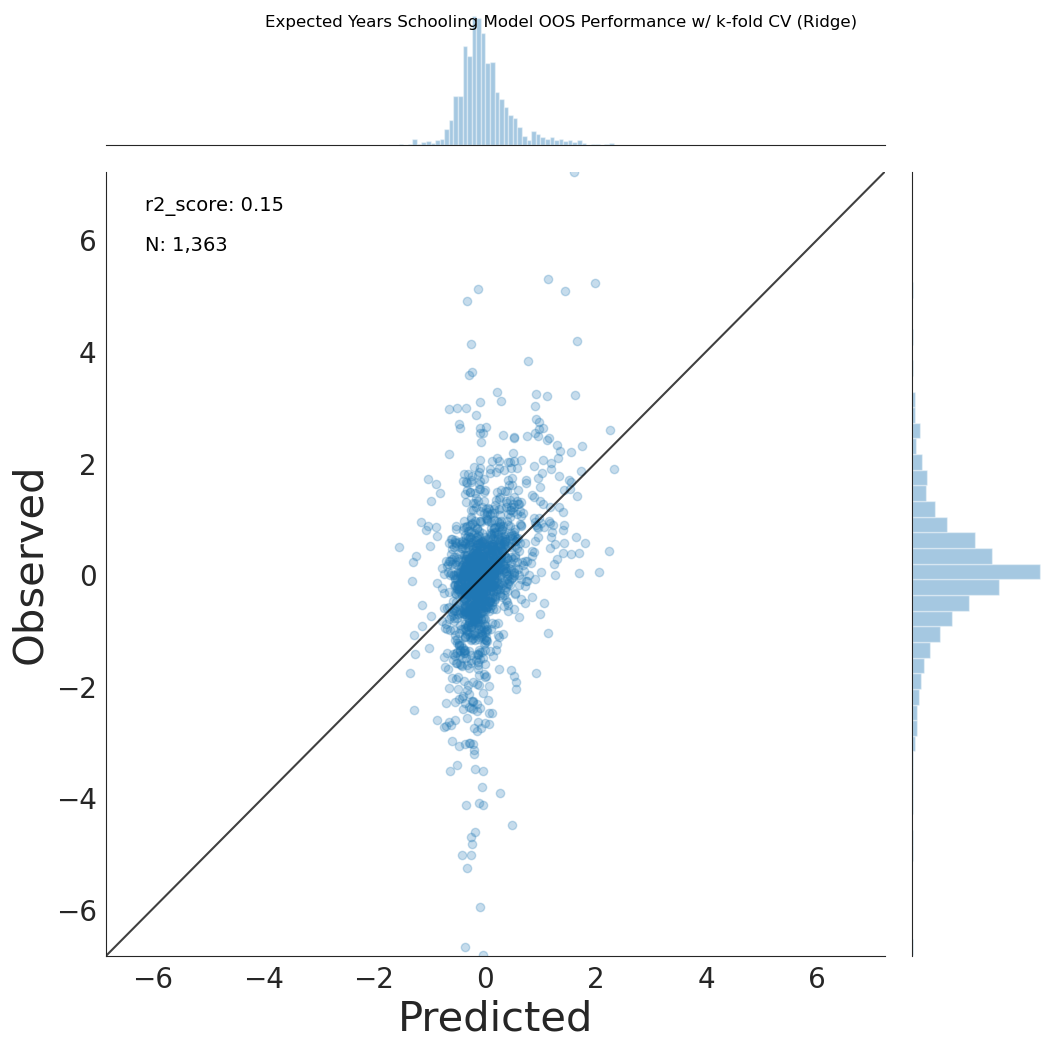

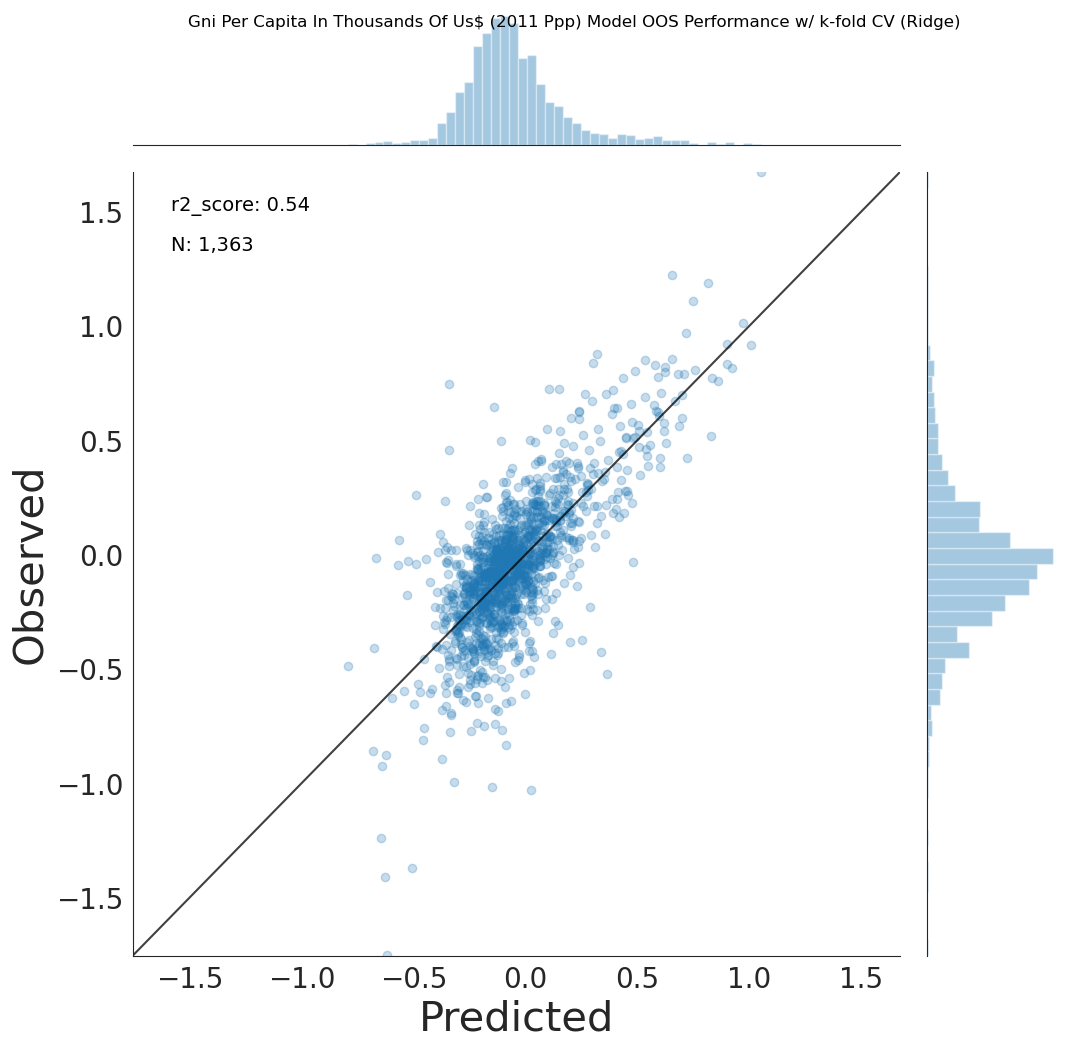

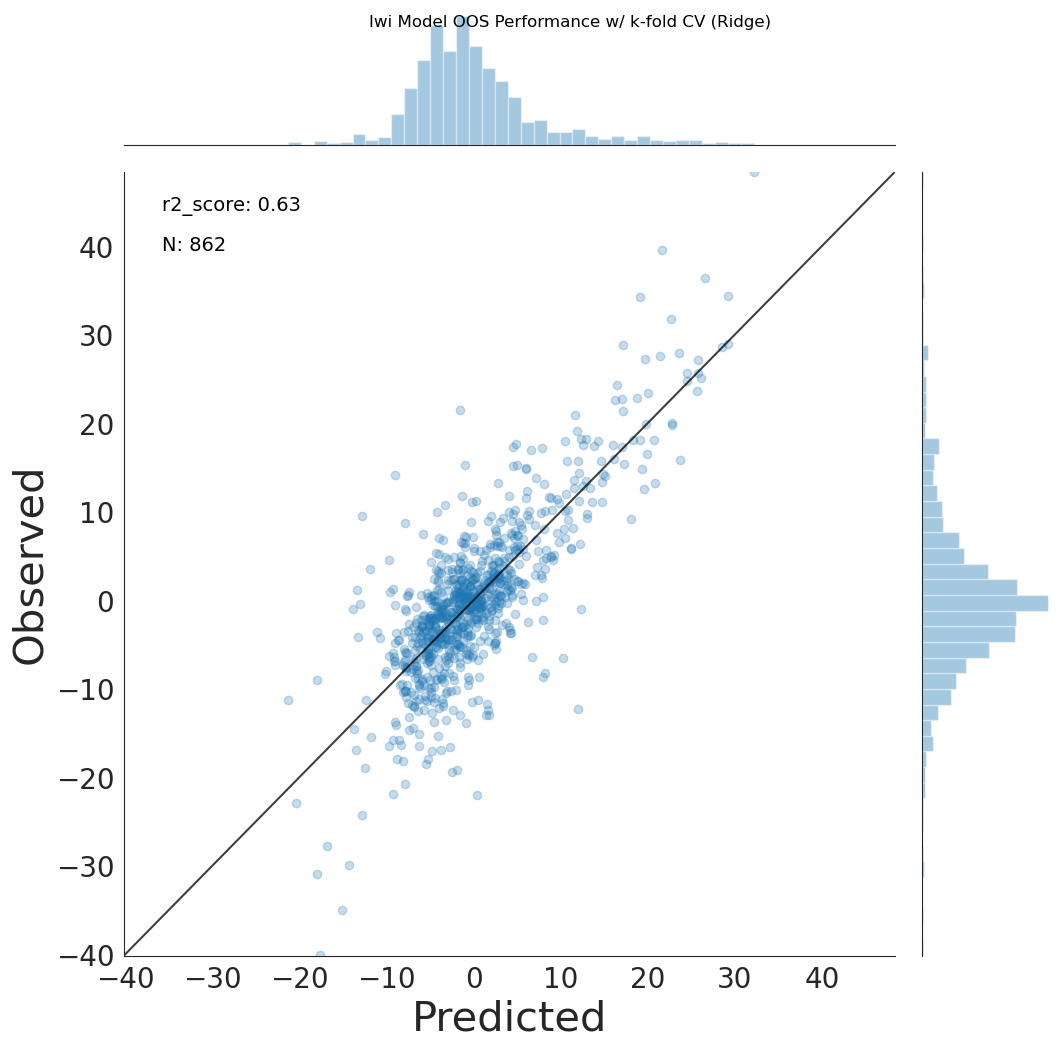

In [21]:
nl_demeaned_kfold_dict = {}

for task in tasks:
    Y_demeaned = df_to_demeaned_y_vars(task, train_df, log_before_diff = log_task[task])
    
    ##Let's drop Y observations that do not have any within country variation. There is nothing to learn from these:
    keep_indxs = get_idxs_without_adm0_observations(train_df)
    Y_demeaned = Y_demeaned.loc[keep_indxs]
    X_demeaned_dropped = X_demeaned_nl.loc[keep_indxs]
    
    print("Zero obs dropped =",(len(X_demeaned)-len(X_demeaned_dropped)))
    
    nl_demeaned_kfold_dict[task] = cv_solve(
        task,
        X_demeaned_dropped,
        Y_demeaned,
        clip_bounds = [np.min(Y_demeaned), np.max(Y_demeaned)],
        country_fold = True)

In [32]:
outpath = (model_directory+
           "within_country_nl_demeaned_solve_all_outcomes_country_fold_VIIRS_hist_bins_GHS_pop_weighted.pkl")
pickle.dump(nl_demeaned_kfold_dict, open(outpath, "wb"))
nl_demeaned_kfold_dict = pickle.load(open(outpath, "rb"))


demean_nl_perf_dict = {}
for task in tasks:
    demean_nl_perf_dict[task] = get_within_perf_from_kfold_dict(nl_demeaned_kfold_dict, task, metric="ALL",
                                                               demeaned_input=True, not_demeaned_df=train_df,
                                                                 logged=log_task[task])
    

###  RCF + NL features, cross country model

Sub-national HDI
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 0.7437527275659047


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Sub-national HDI...
Life expectancy
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 0.30599496872071963


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Life expectancy...
Mean years schooling
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 10.680004325145758


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Mean years schooling...
Expected years schooling
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 1.0


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Expected years schooling...
GNI per capita in thousands of US$ (2011 PPP)
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 1.807768676963435


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting GNI per capita in thousands of US$ (2011 PPP)...
iwi
519
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 519 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 10.680004325145758
Plotting iwi...


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


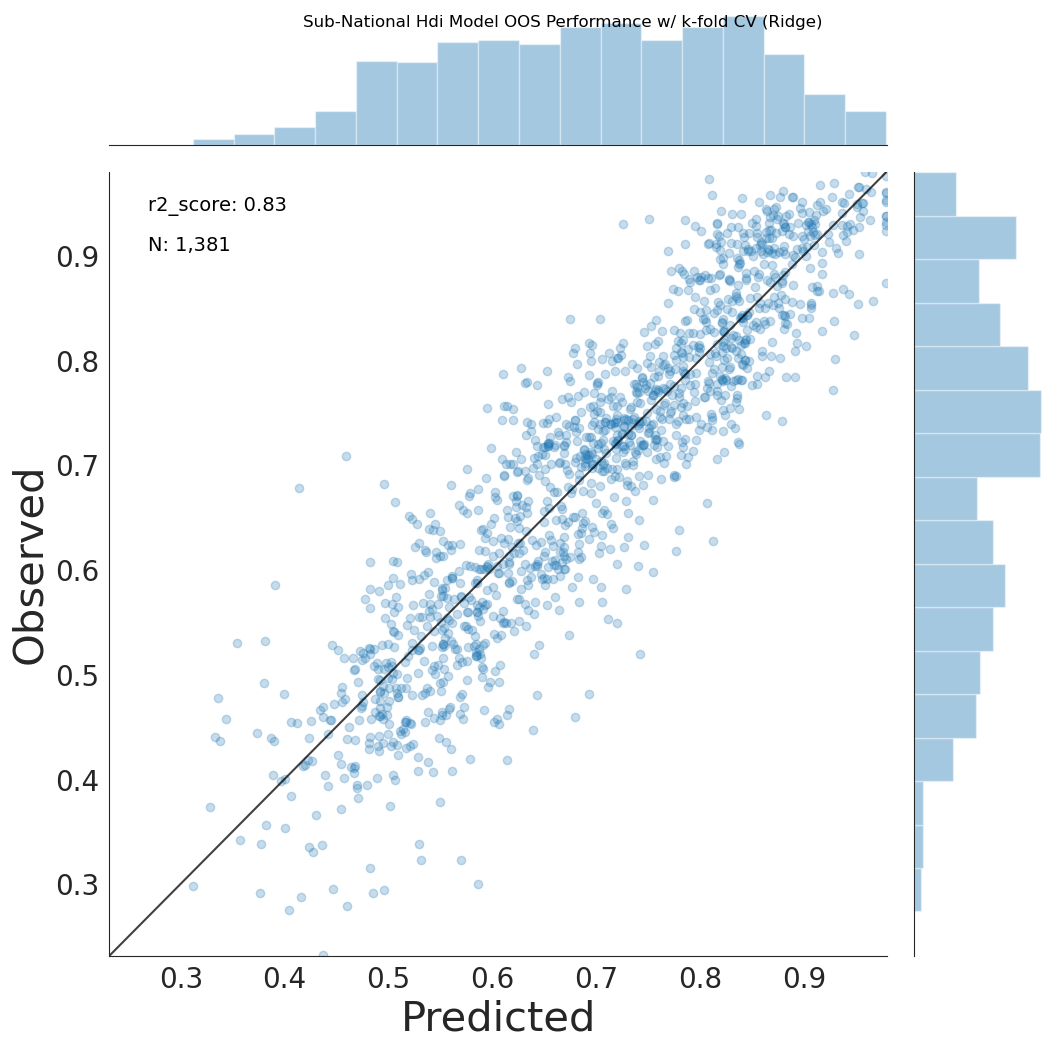

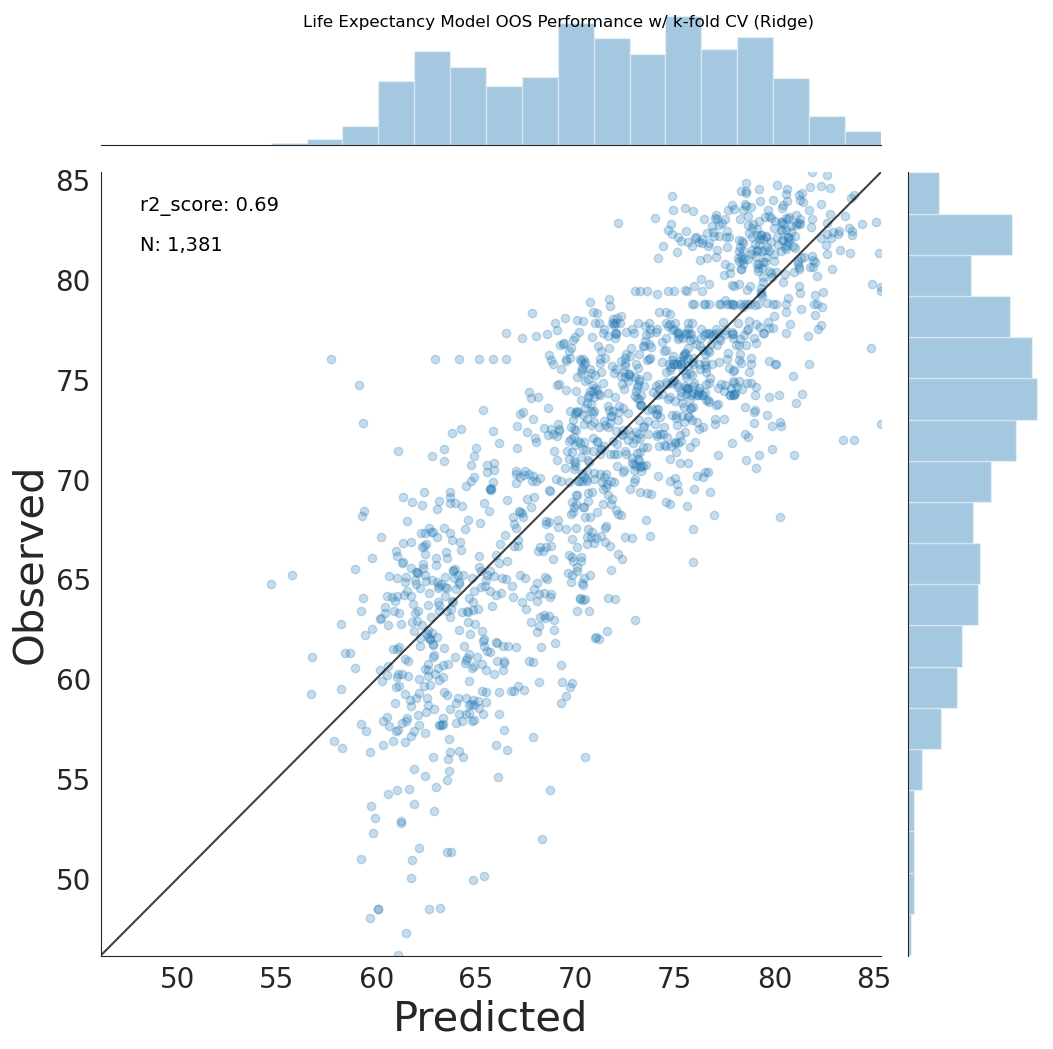

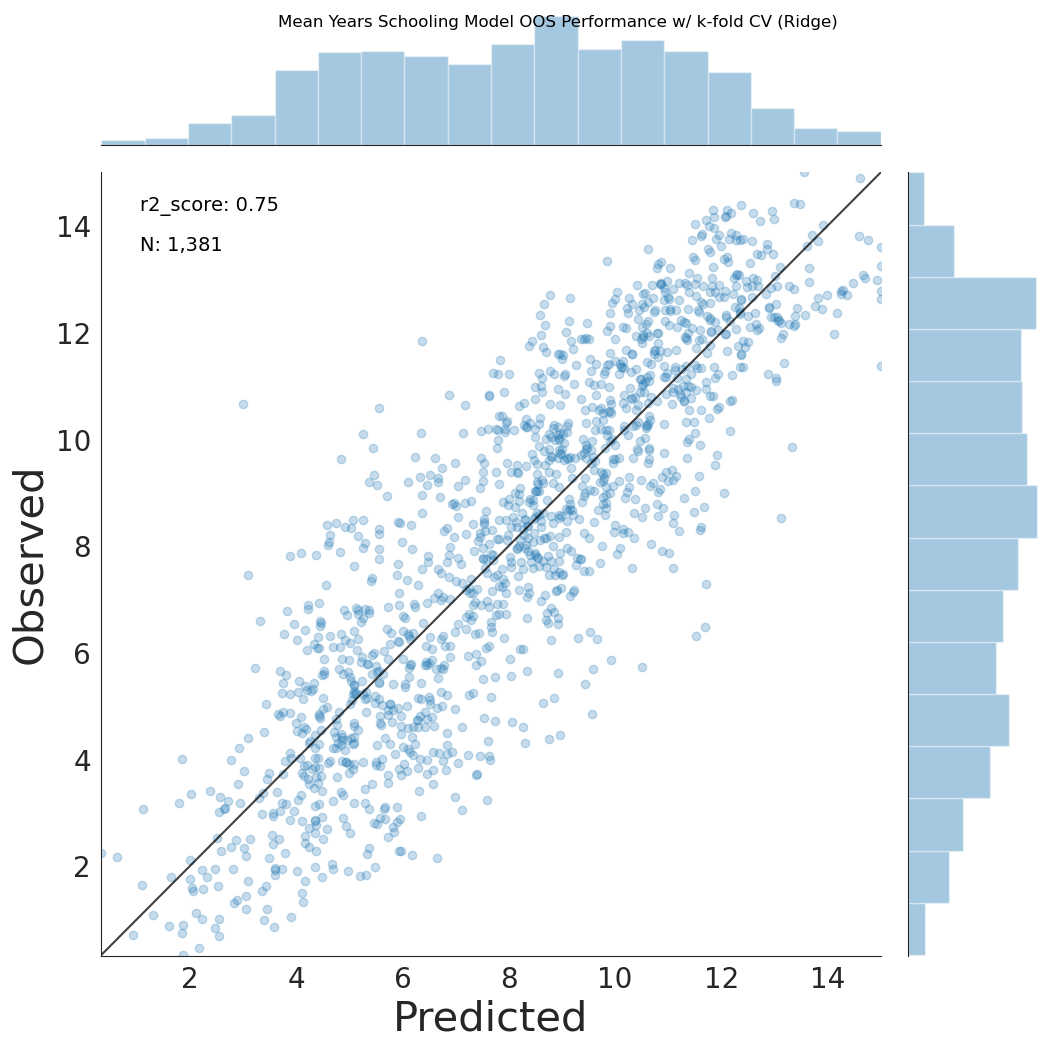

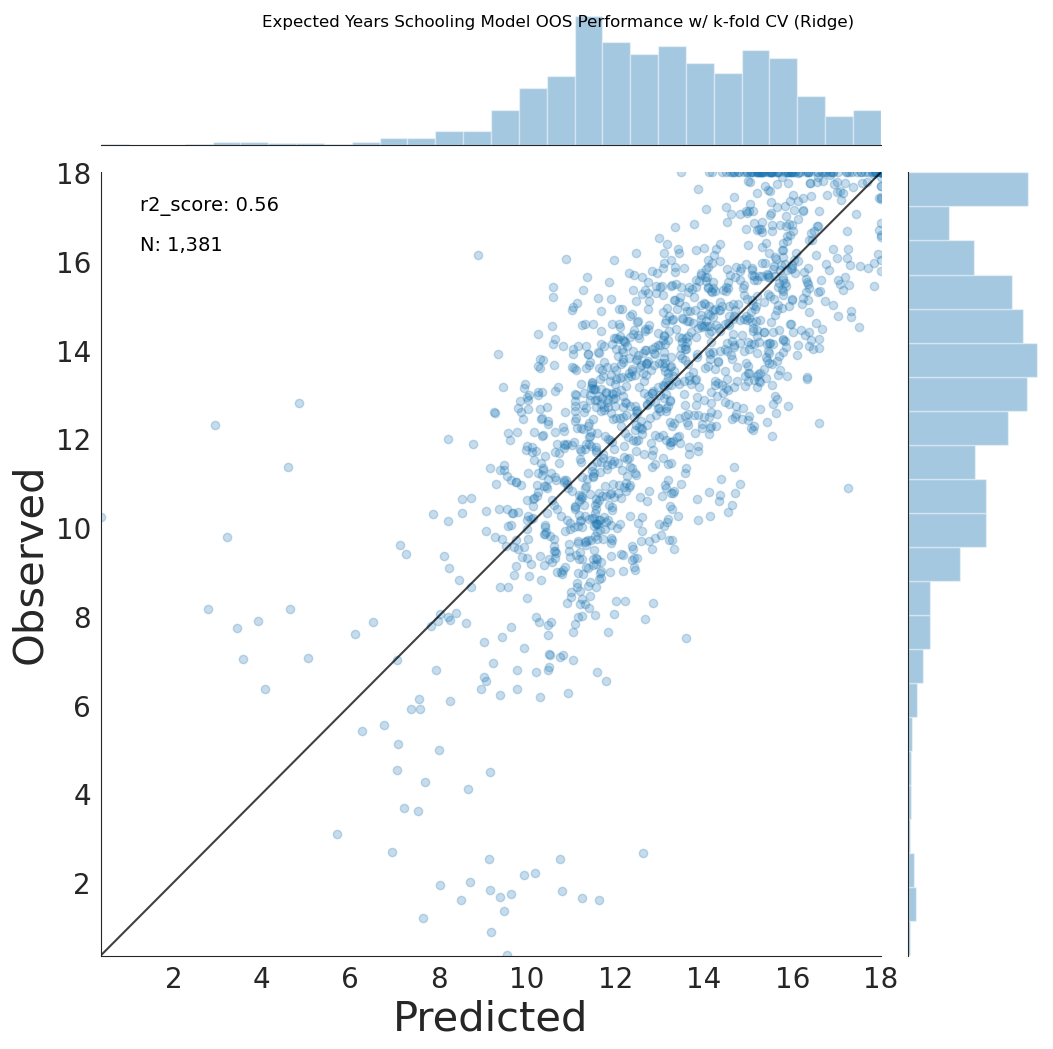

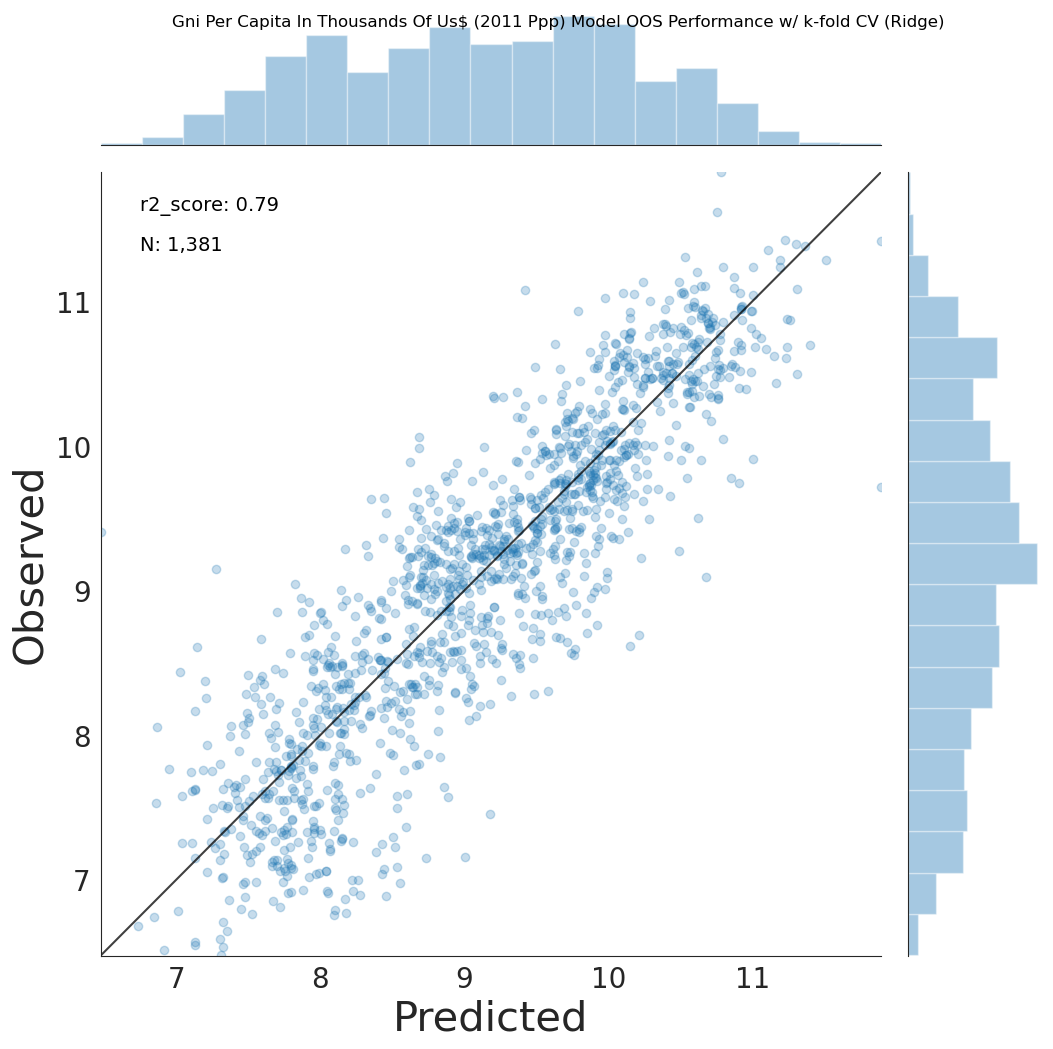

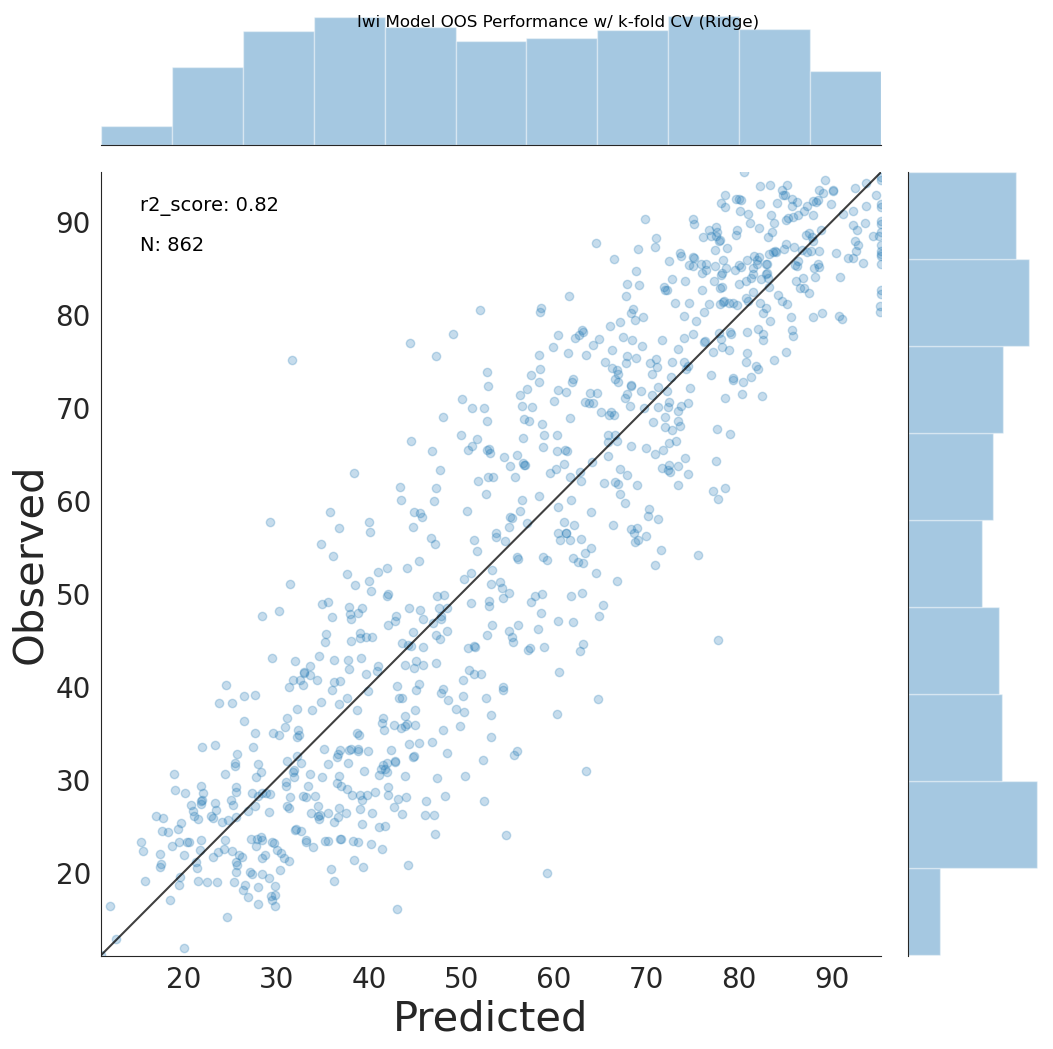

In [23]:
nl_and_rcf_kfold_dict = {}


for task in tasks:
    Y_train = train_df[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    nl_and_rcf_kfold_dict[task]  = cv_solve(task,
                                            X_train,
                                            Y_train,
                                            X_train2 = X_nl, # here's the nl data
                                            lambdas2 = rescale_lambdas,
                                            clip_bounds = [np.min(Y_train), np.max(Y_train)],
                                            country_fold = True)

In [33]:
outpath = (model_directory+
           "cross_country_rcf_and_nl_solve_all_outcomes_country_fold_DENSE_pop_weight=GHS_VIIRS_hist_bins_GHS_pop_weighted.pkl")
pickle.dump(nl_and_rcf_kfold_dict, open(outpath, "wb"))
nl_and_rcf_kfold_dict = pickle.load(open(outpath, "rb"))

cc_nl_and_rcf_perf_dict = {}
for task in tasks:
    cc_nl_and_rcf_perf_dict[task] = get_within_perf_from_kfold_dict(nl_and_rcf_kfold_dict, task, metric="ALL")
    

### RCF + NL Demeaned (Demeaned Ys and Demeaned Xs)

Zero obs dropped = 18
Sub-national HDI
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 1.0


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Sub-national HDI...
Zero obs dropped = 18
Life expectancy
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 63.095734448019314


/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:308: UserWarning: Rescale X2 val is at max of range
  warnings.warn("Rescale X2 val is at max of range")
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Life expectancy...
Zero obs dropped = 18
Mean years schooling
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 1.0


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Mean years schooling...
Zero obs dropped = 18
Expected years schooling
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 0.7437527275659047


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Expected years schooling...
Zero obs dropped = 18
GNI per capita in thousands of US$ (2011 PPP)
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 10.680004325145758


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting GNI per capita in thousands of US$ (2011 PPP)...
Zero obs dropped = 18
iwi
501
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 501 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 25.958865861263956


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting iwi...


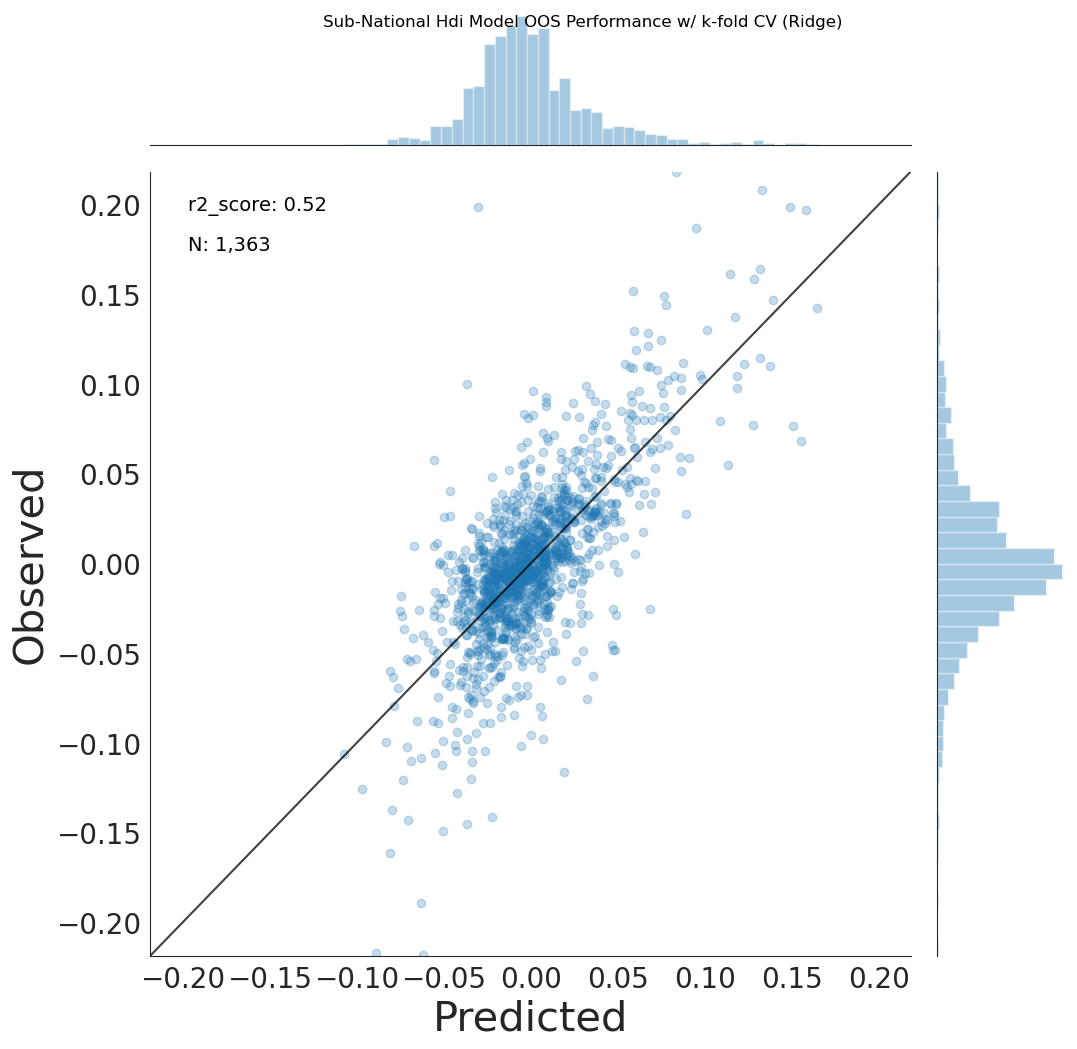

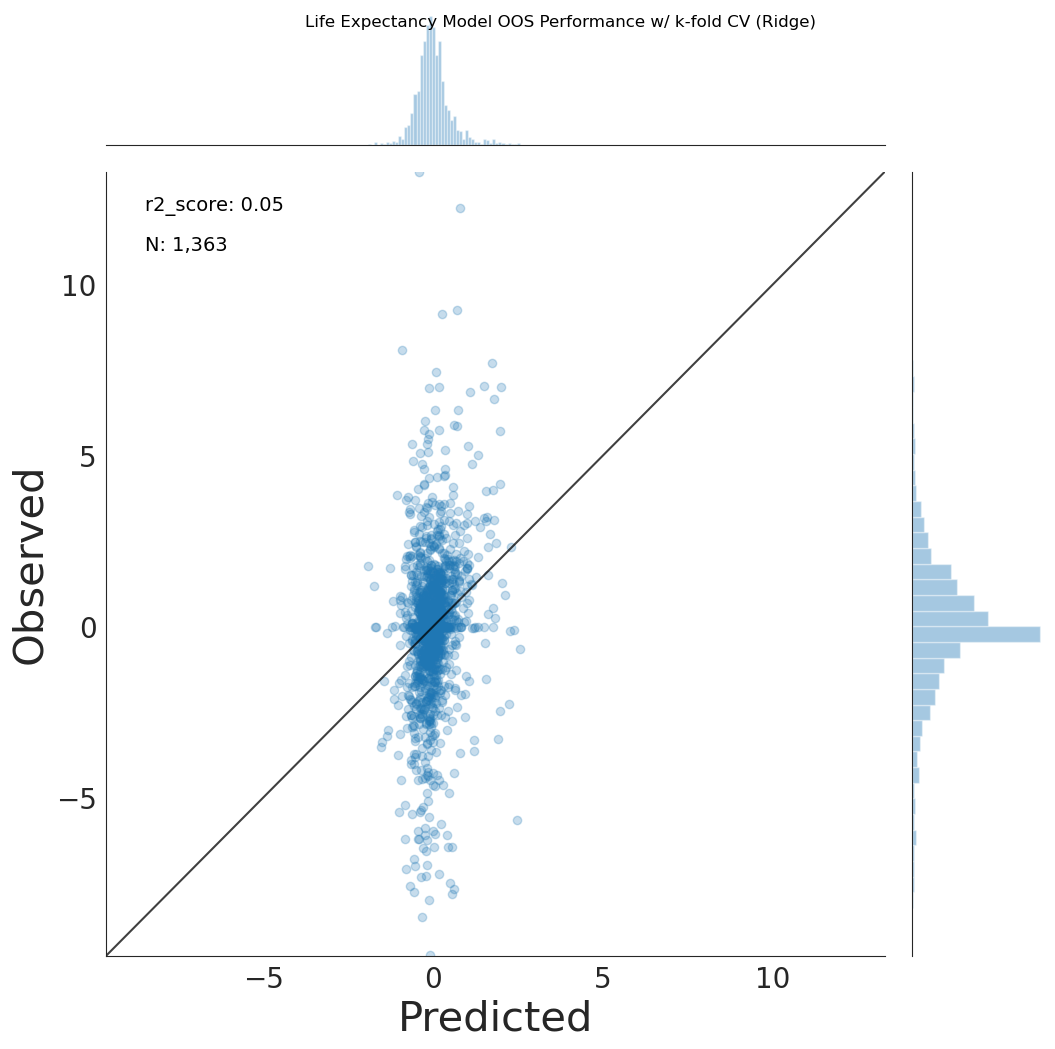

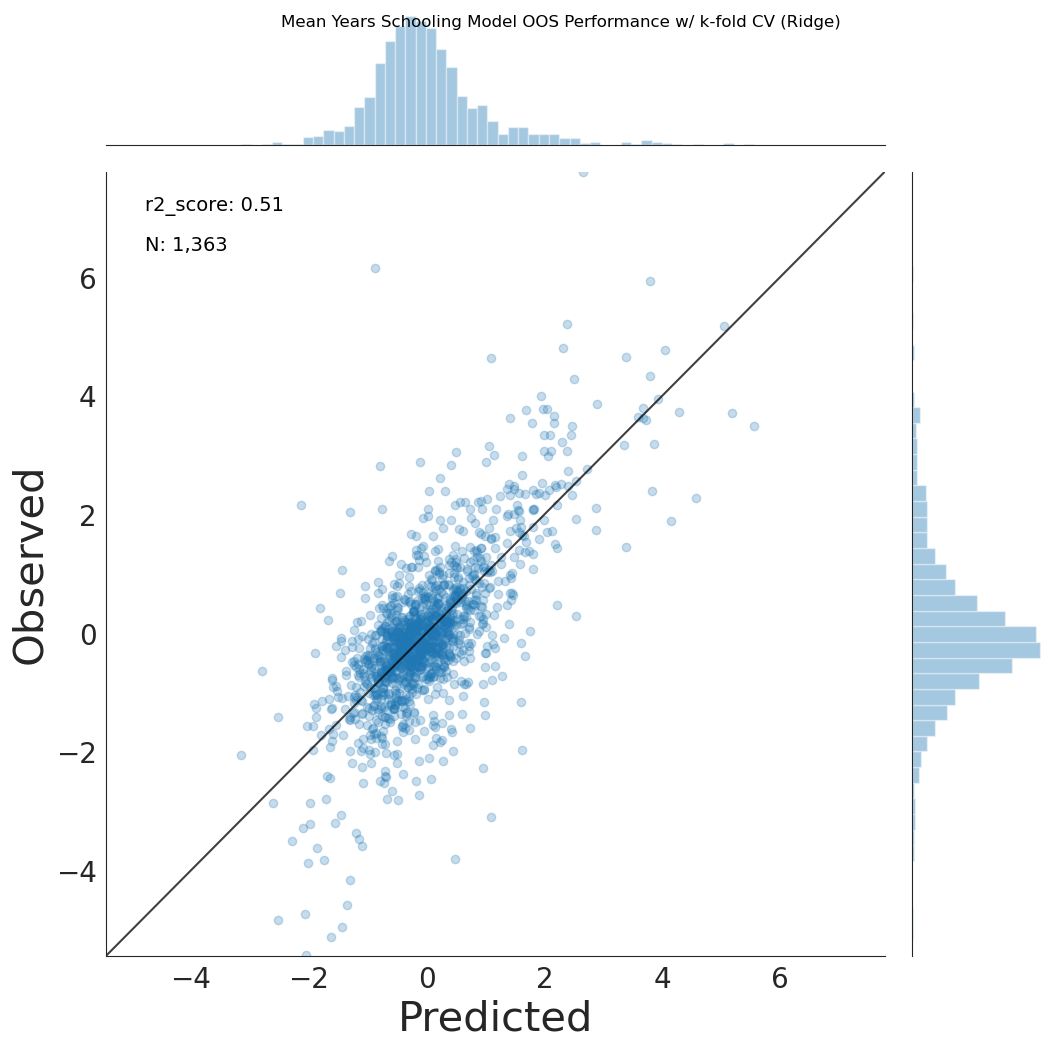

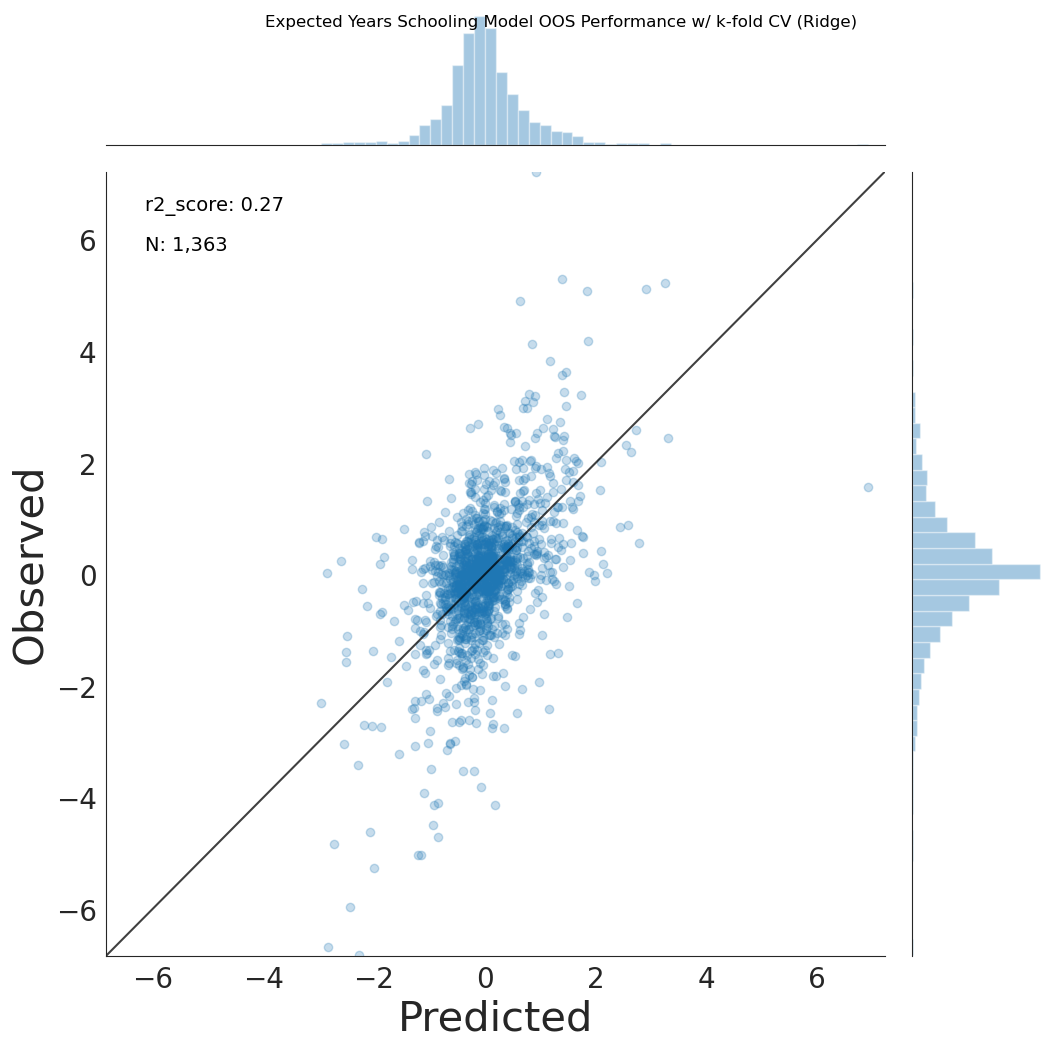

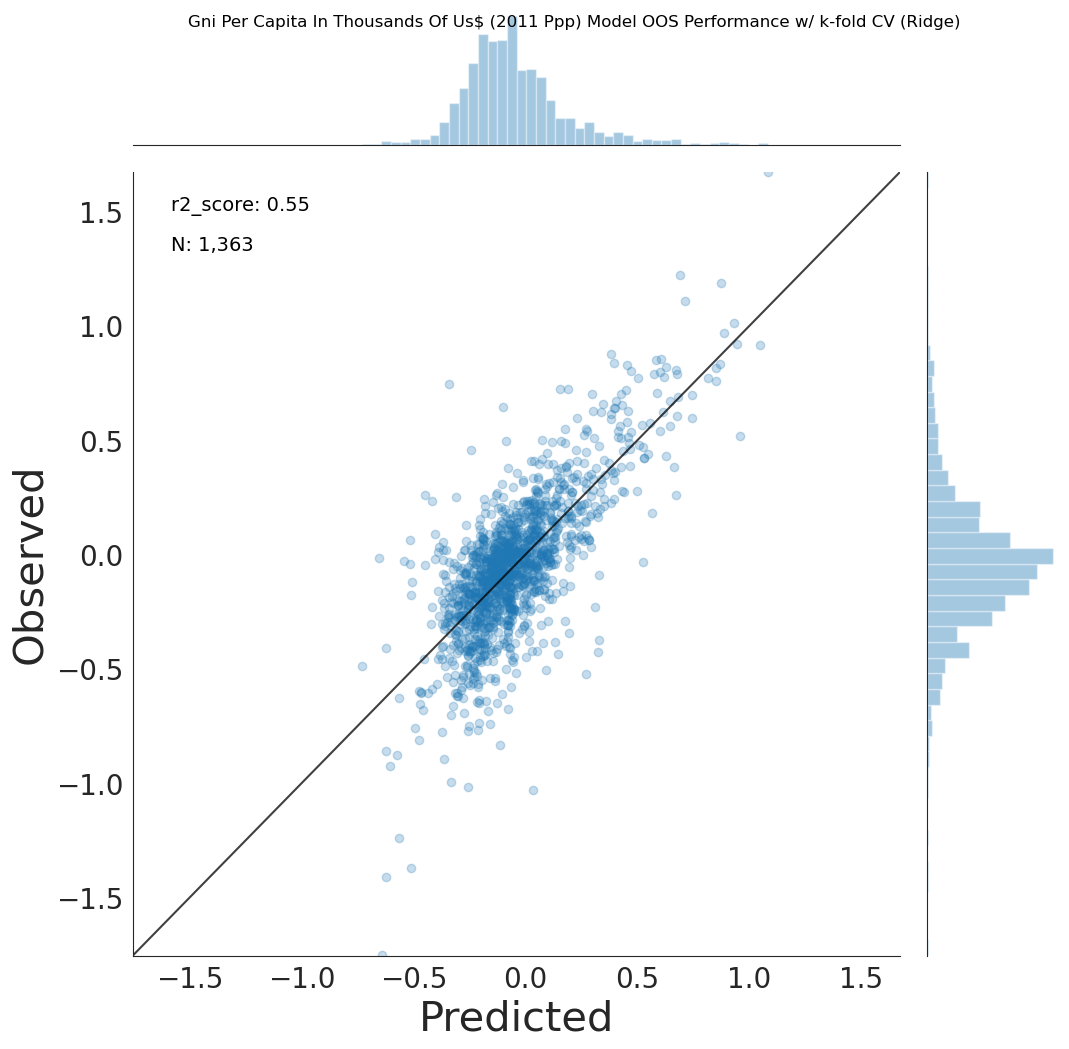

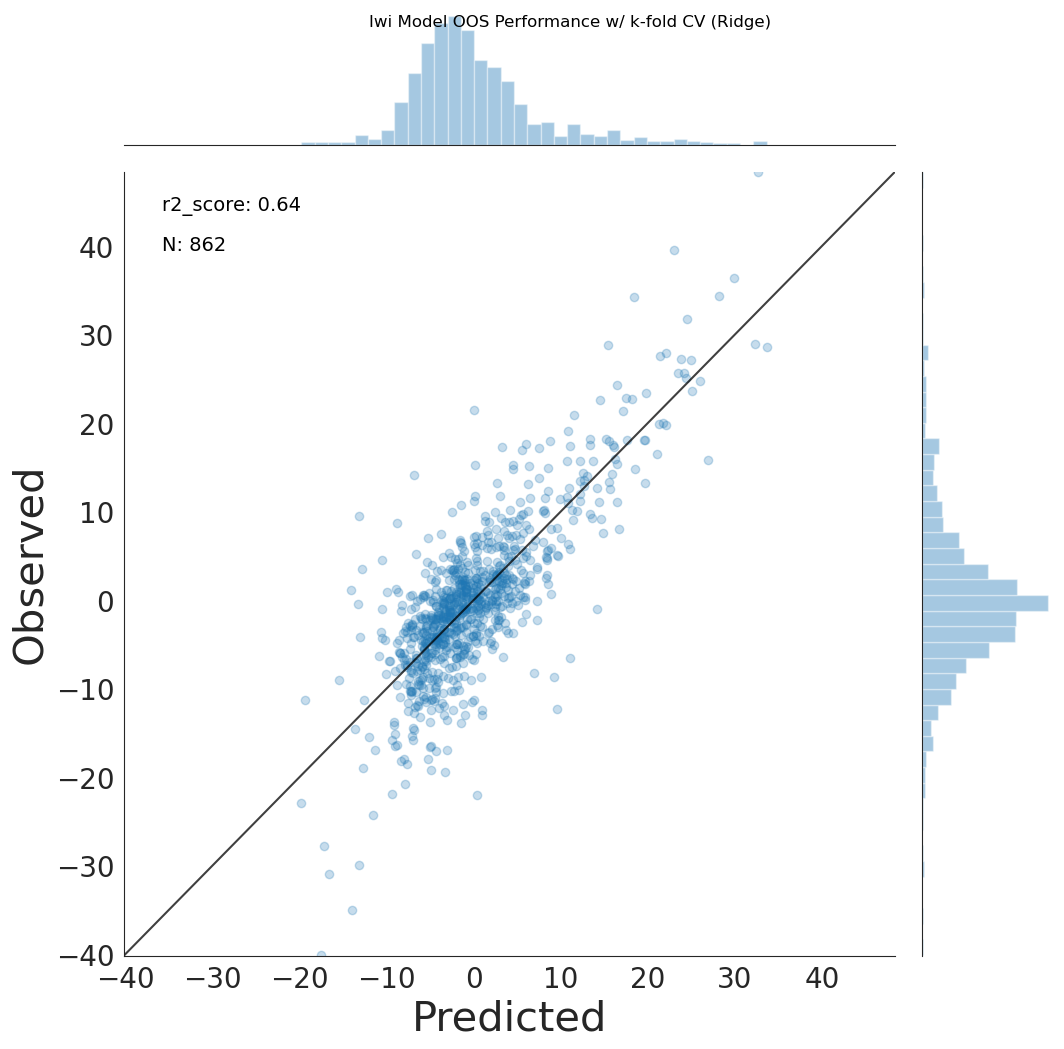

In [25]:
nl_and_rcf_demeaned_kfold_dict = {}

for task in tasks:
    Y_demeaned = df_to_demeaned_y_vars(task, train_df,log_before_diff = log_task[task])
    
    ##Let's drop Y observations that do not have any within country variation. There is nothing to learn from these:
    keep_indxs = get_idxs_without_adm0_observations(train_df)
    Y_demeaned = Y_demeaned.loc[keep_indxs]
    X_demeaned_dropped = X_demeaned.loc[keep_indxs]
    X2_demeaned_dropped = X_demeaned_nl.loc[keep_indxs]
    
    print("Zero obs dropped =",(len(X_demeaned ) - len(X_demeaned_dropped)))
    
    nl_and_rcf_demeaned_kfold_dict[task] = cv_solve(
        task,
        X_demeaned_dropped,
        Y_demeaned,
        X_train2 = X2_demeaned_dropped,
        lambdas2 = rescale_lambdas, # I found that this range worked through iteration
        clip_bounds = [np.min(Y_demeaned), np.max(Y_demeaned)],
         country_fold = True)

In [41]:
outpath = (model_directory+
           "within_country_rcf_and_nl_demeaned_solve_all_outcomes_country_fold"
           "_DENSE_pop_weight=GHS_VIIRS_hist_bins_GHS_pop_weighted.pkl")

#pickle.dump(nl_and_rcf_demeaned_kfold_dict, open(outpath, "wb"))
nl_and_rcf_demeaned_kfold_dict = pickle.load(open(outpath, "rb"))

demeaned_nl_and_rcf_demeaned_perf_dict = {}

for task in tasks:
    demeaned_nl_and_rcf_demeaned_perf_dict[task] = get_within_perf_from_kfold_dict(nl_and_rcf_demeaned_kfold_dict, 
                                                                                   task, metric="ALL",demeaned_input=True, 
                                                                                   not_demeaned_df=train_df,
                                                                 logged=log_task[task])
    

In [43]:
train_df.shape

(1381, 13)

## Examine ADM0 Performance

Sub-national HDI
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Sub-national HDI...
Life expectancy
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Life expectancy...
Mean years schooling
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Mean years schooling...
Expected years schooling
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Expected years schooling...
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting GNI per capita in thousands of US$ (2011 PPP)...
iwi
60
Training model...

on fold (1 of 5): 


/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 60 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting iwi...


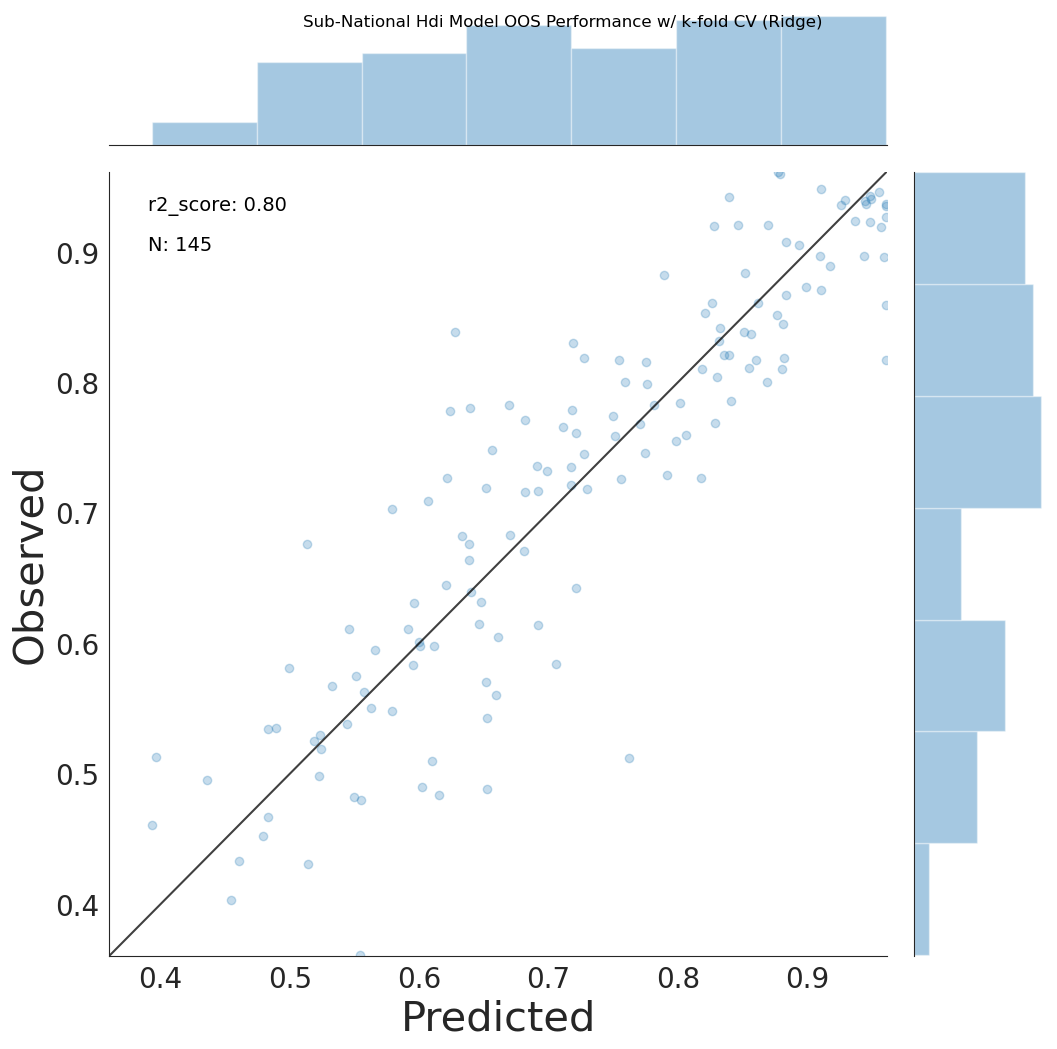

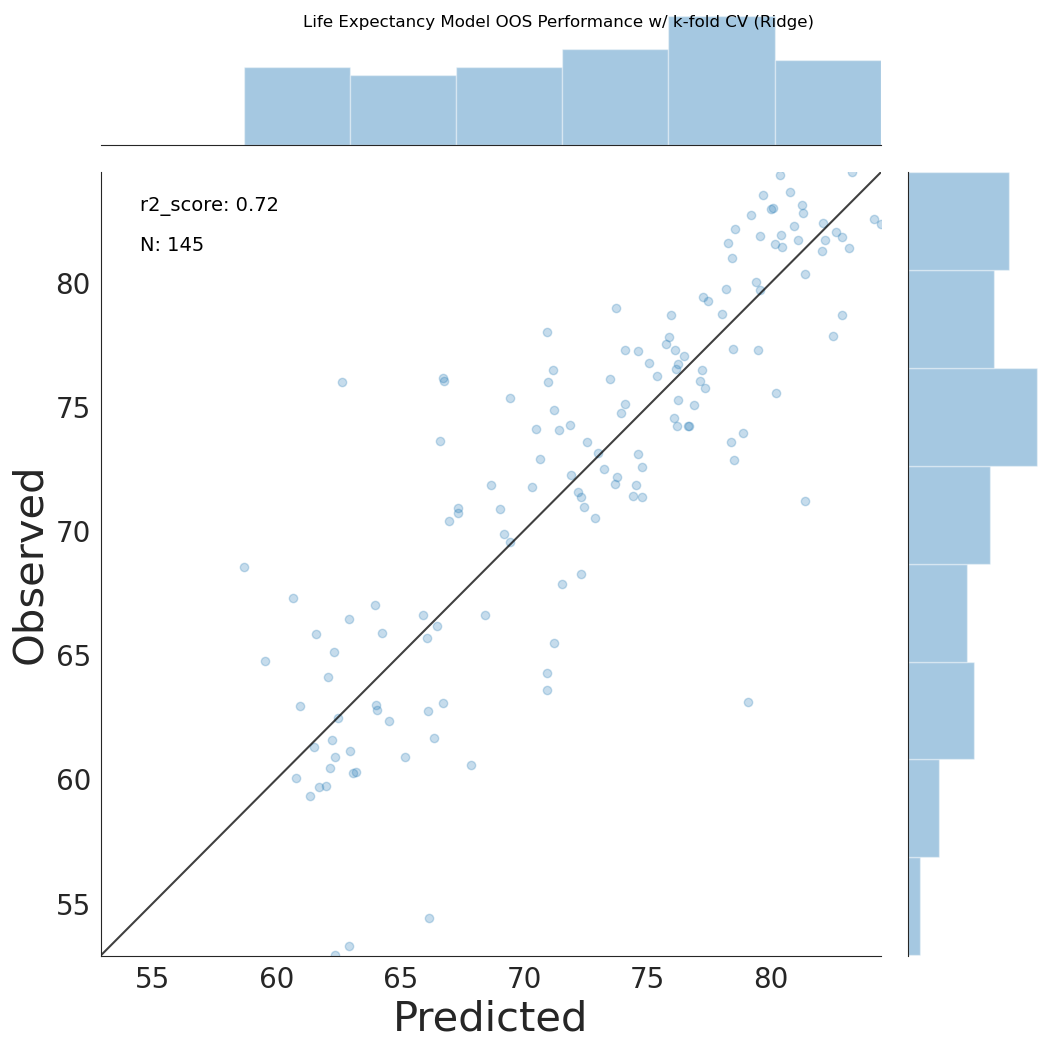

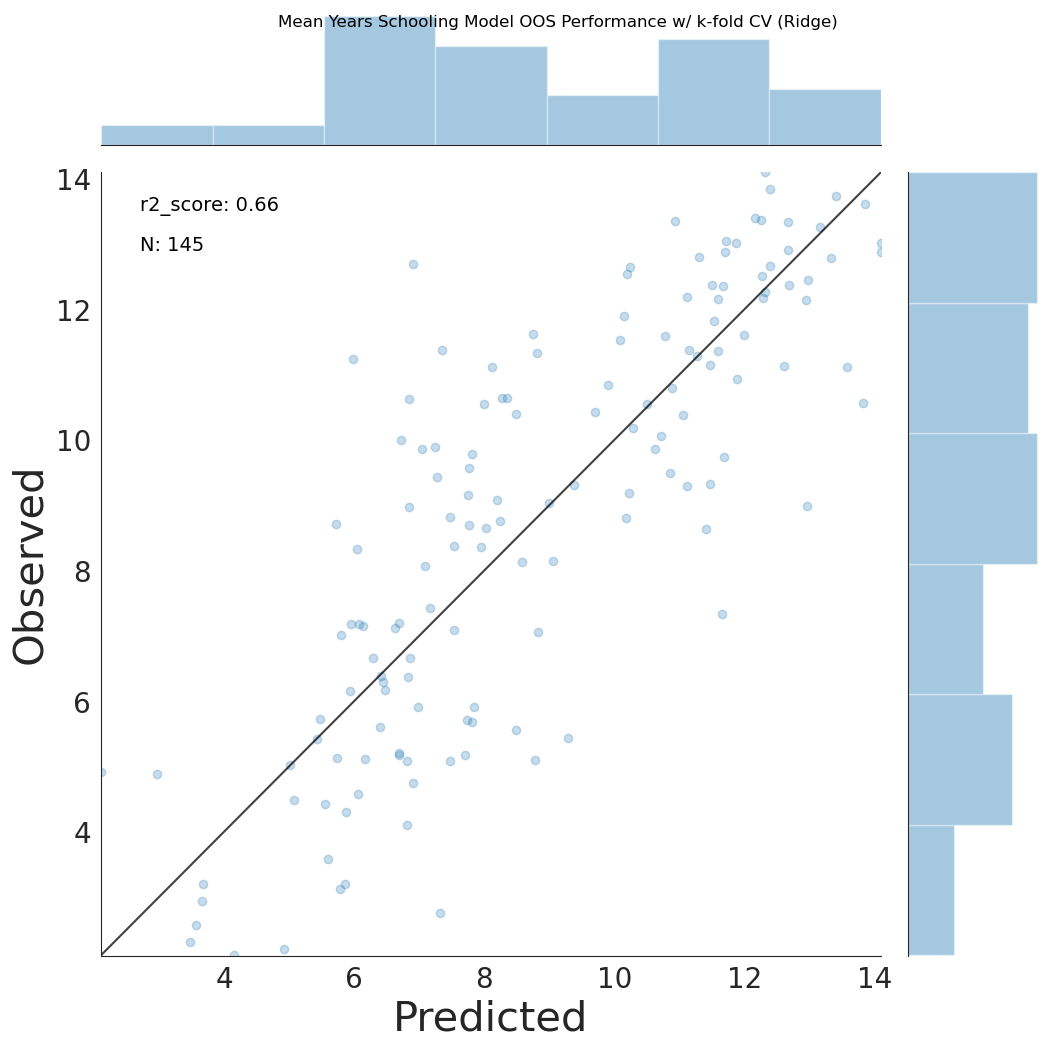

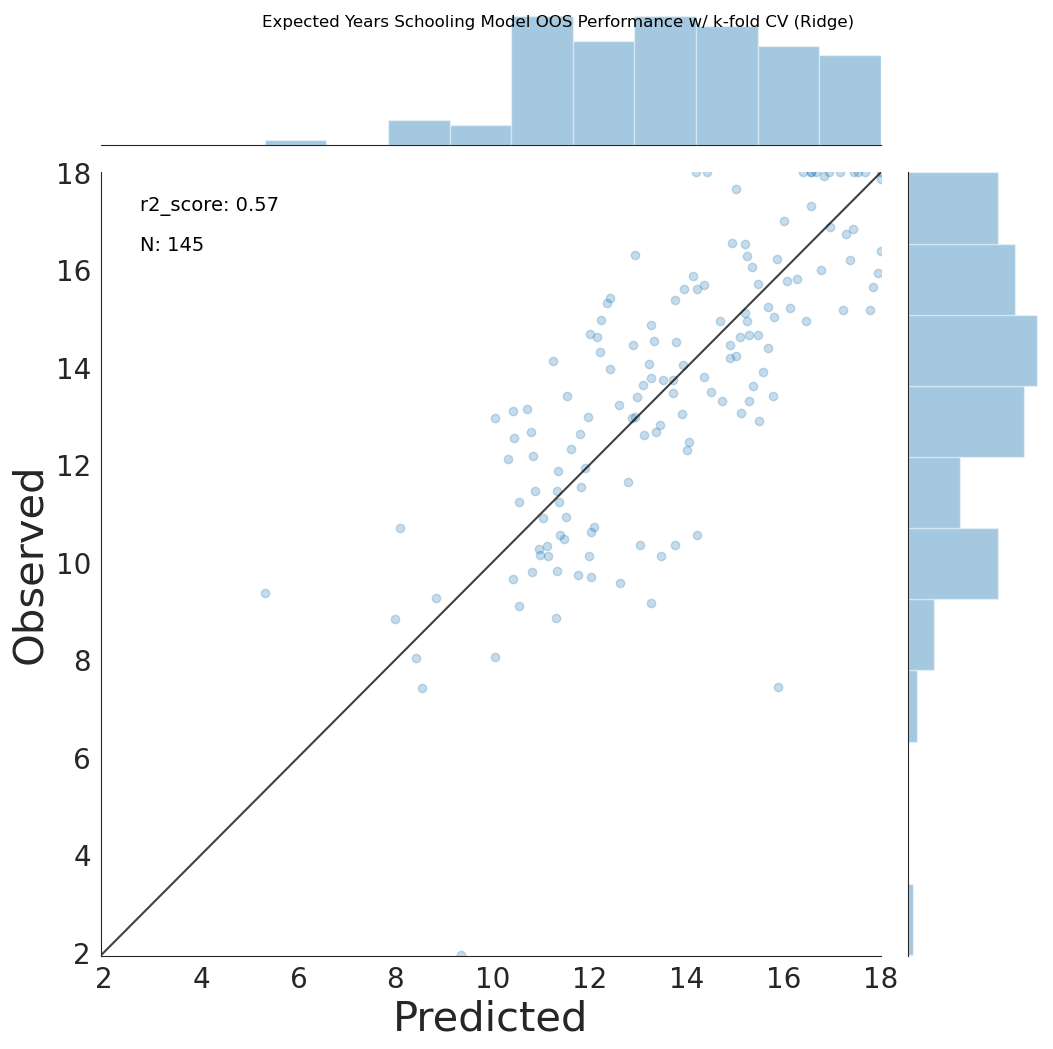

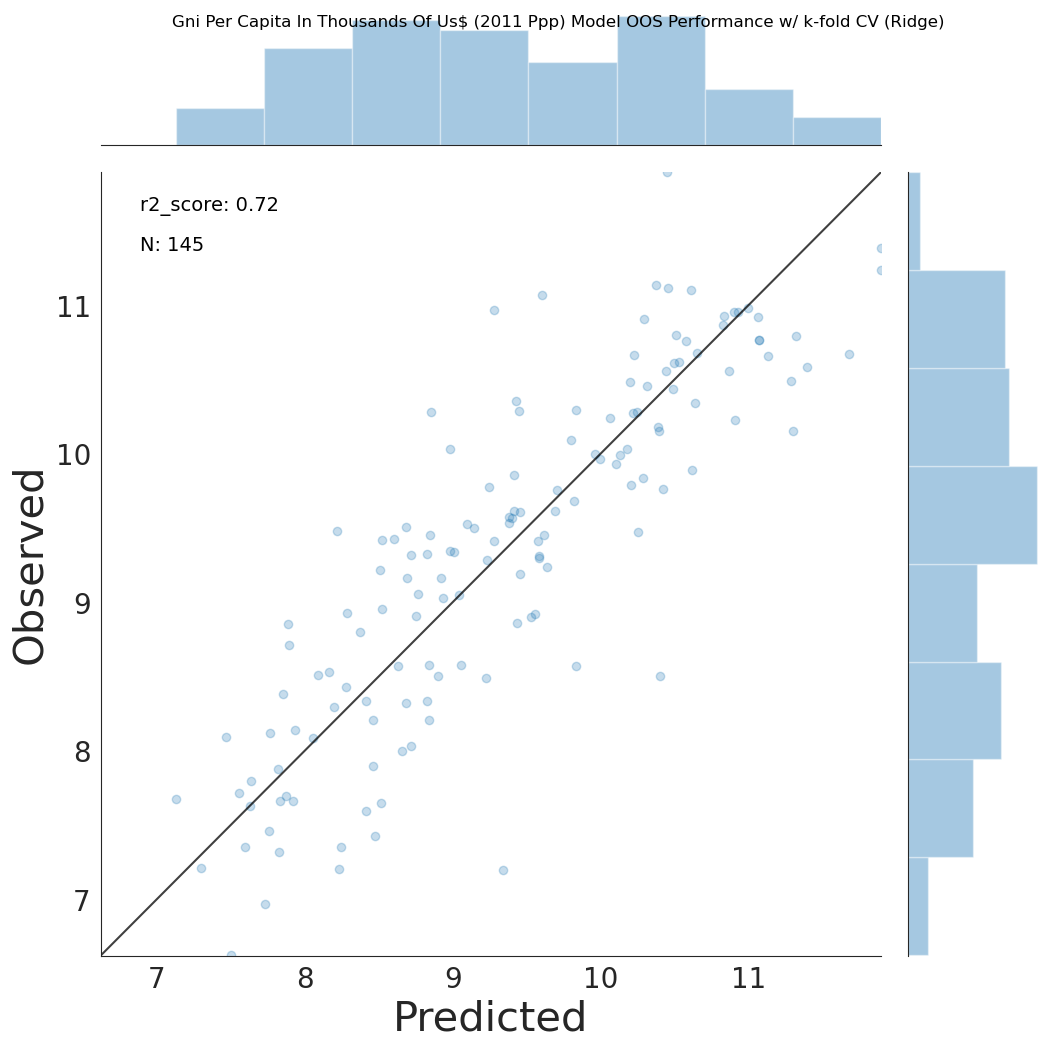

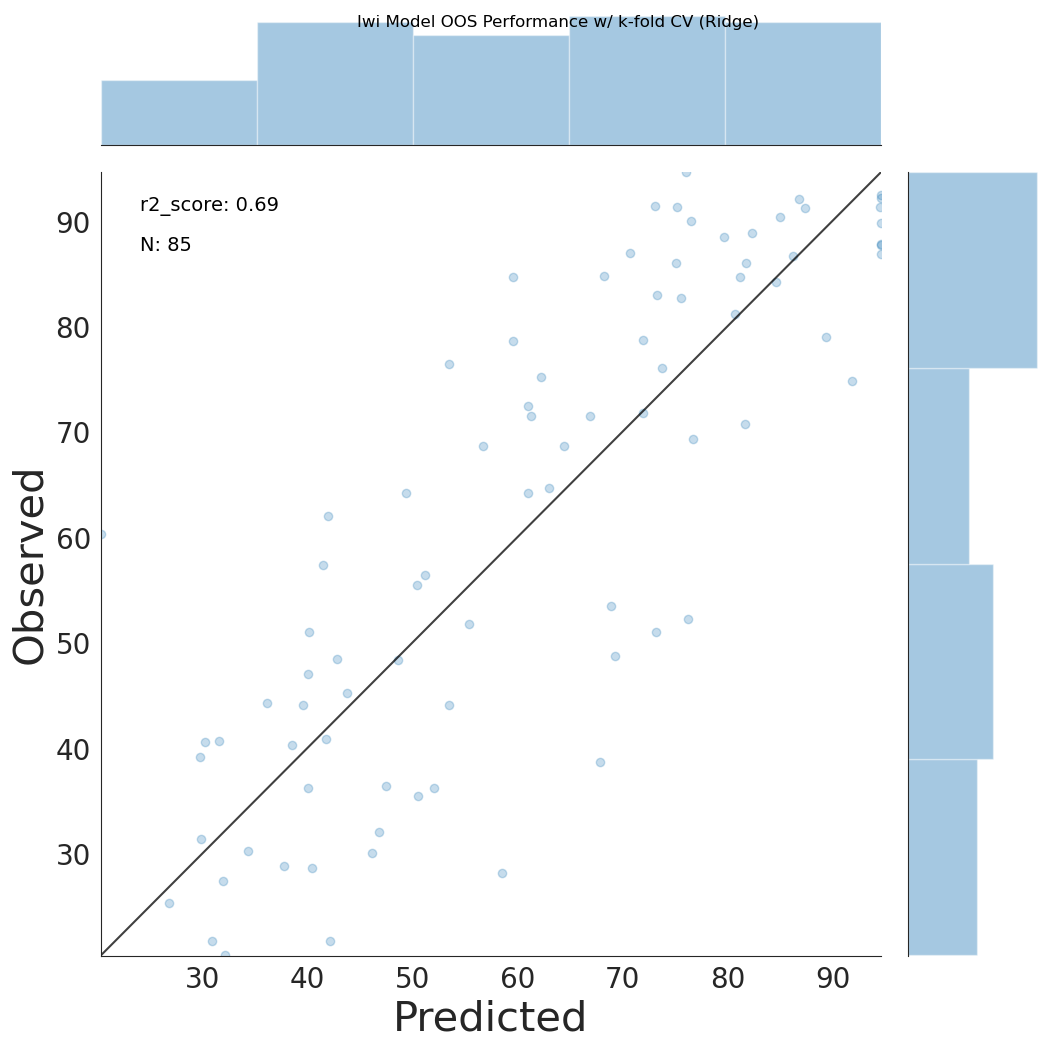

In [27]:
adm0_kfold_dict = {}

for task in tasks:
    Y_train = train_df_adm0[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    
    adm0_kfold_dict[task]  = cv_solve(task,
                                    X_train_adm0,
                                    Y_train,
                                    clip_bounds = [np.min(Y_train), np.max(Y_train)],)

In [35]:
outpath = (model_directory+
           "kfold_solve_adm0_model_full"
           "GHS_pop_weighted_feats_DENSE.pkl")

pickle.dump(adm0_kfold_dict, open(outpath, "wb"))
adm0_kfold_dict = pickle.load(open(outpath, "rb"))

In [36]:
n_adm0 = {}
for task in tasks:
    n_adm0[task] = len(np.hstack(adm0_kfold_dict[task]["locations_test"]))

### Now ADM 0 with NL features

Sub-national HDI
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Sub-national HDI...
Life expectancy
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Life expectancy...
Mean years schooling
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Mean years schooling...
Expected years schooling
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Expected years schooling...
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting GNI per capita in thousands of US$ (2011 PPP)...
iwi
60
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 60 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


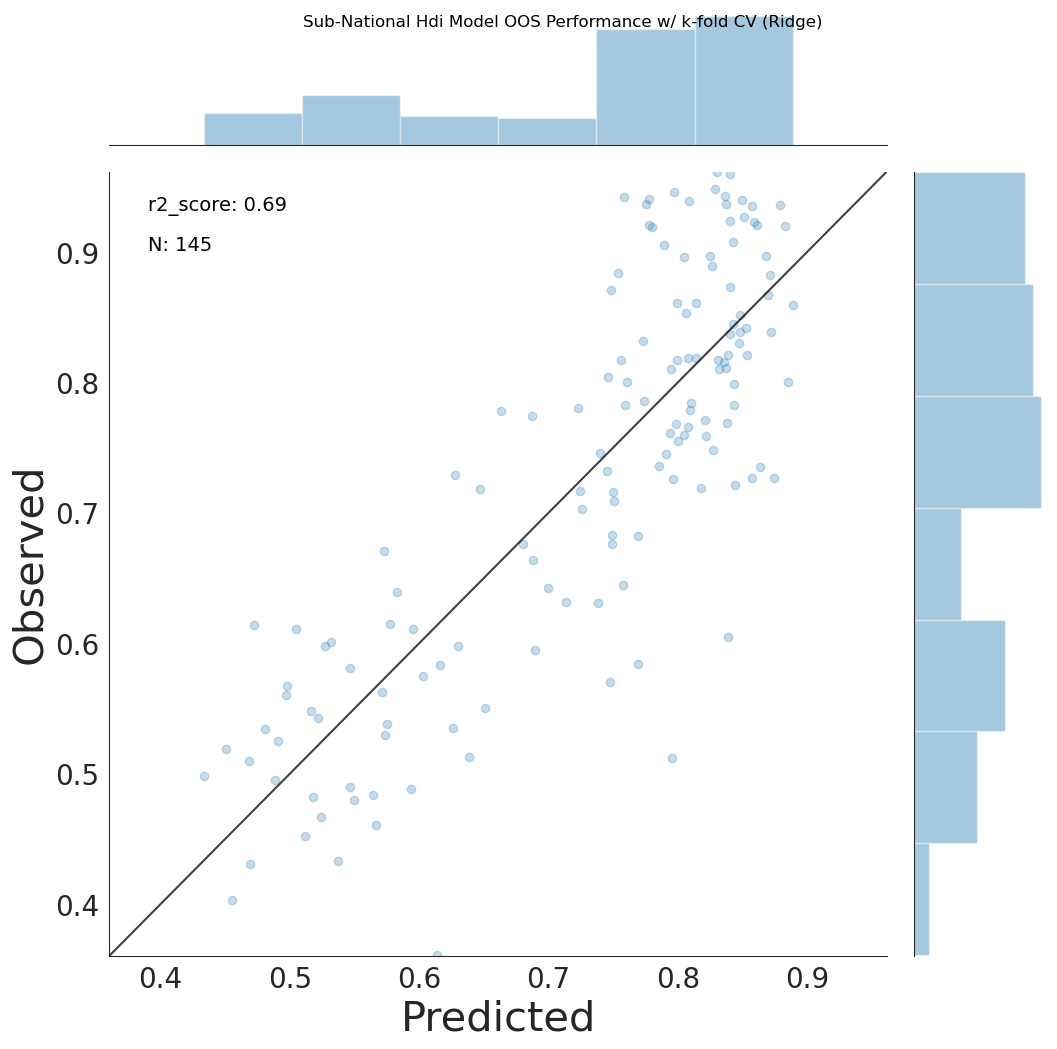

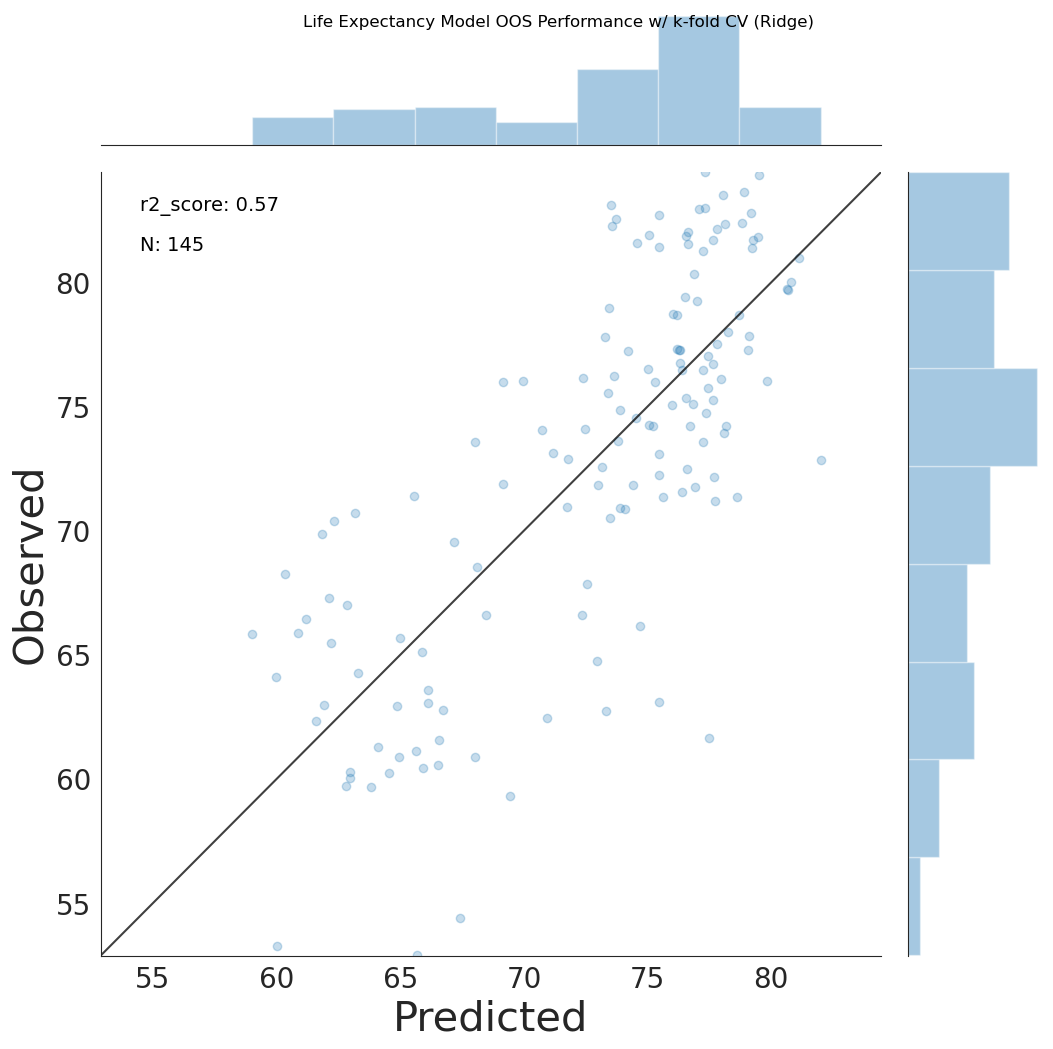

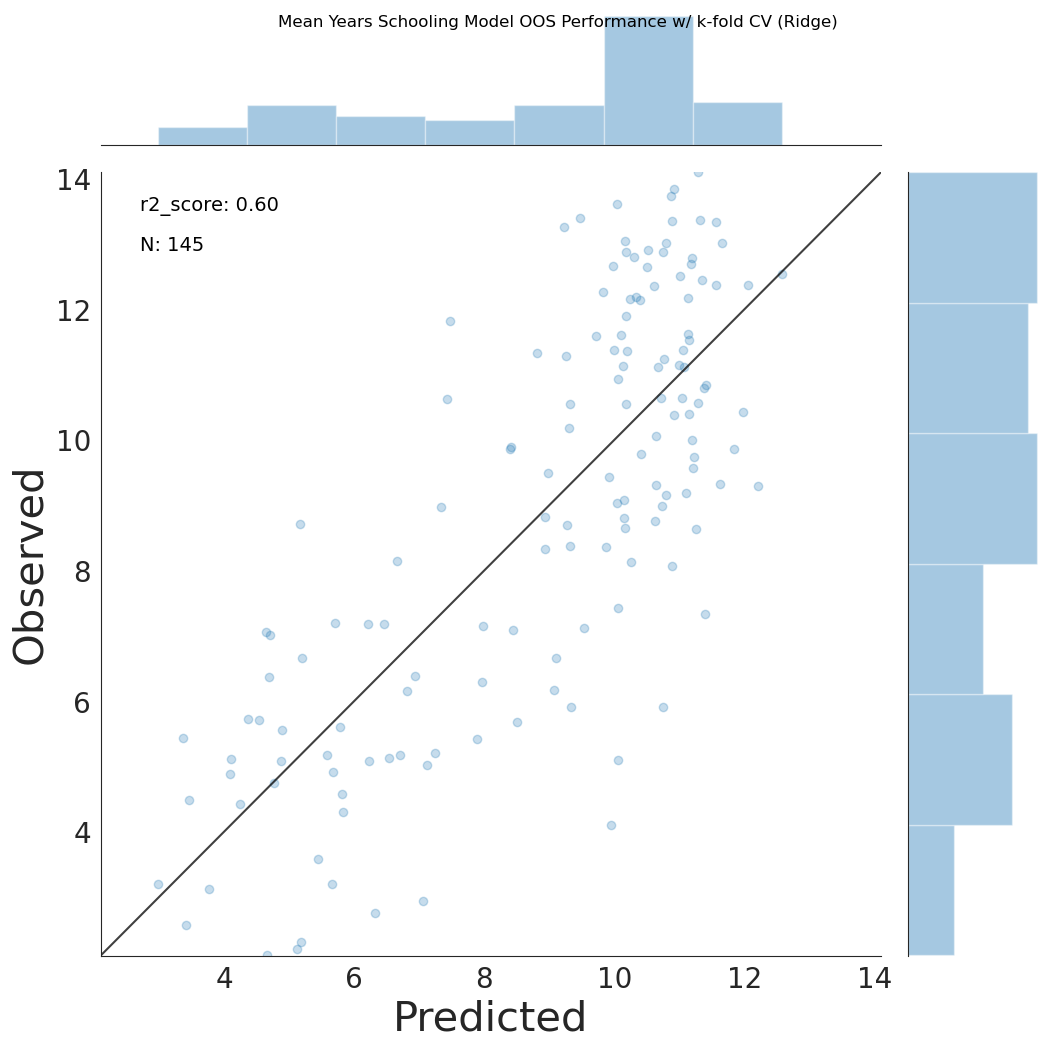

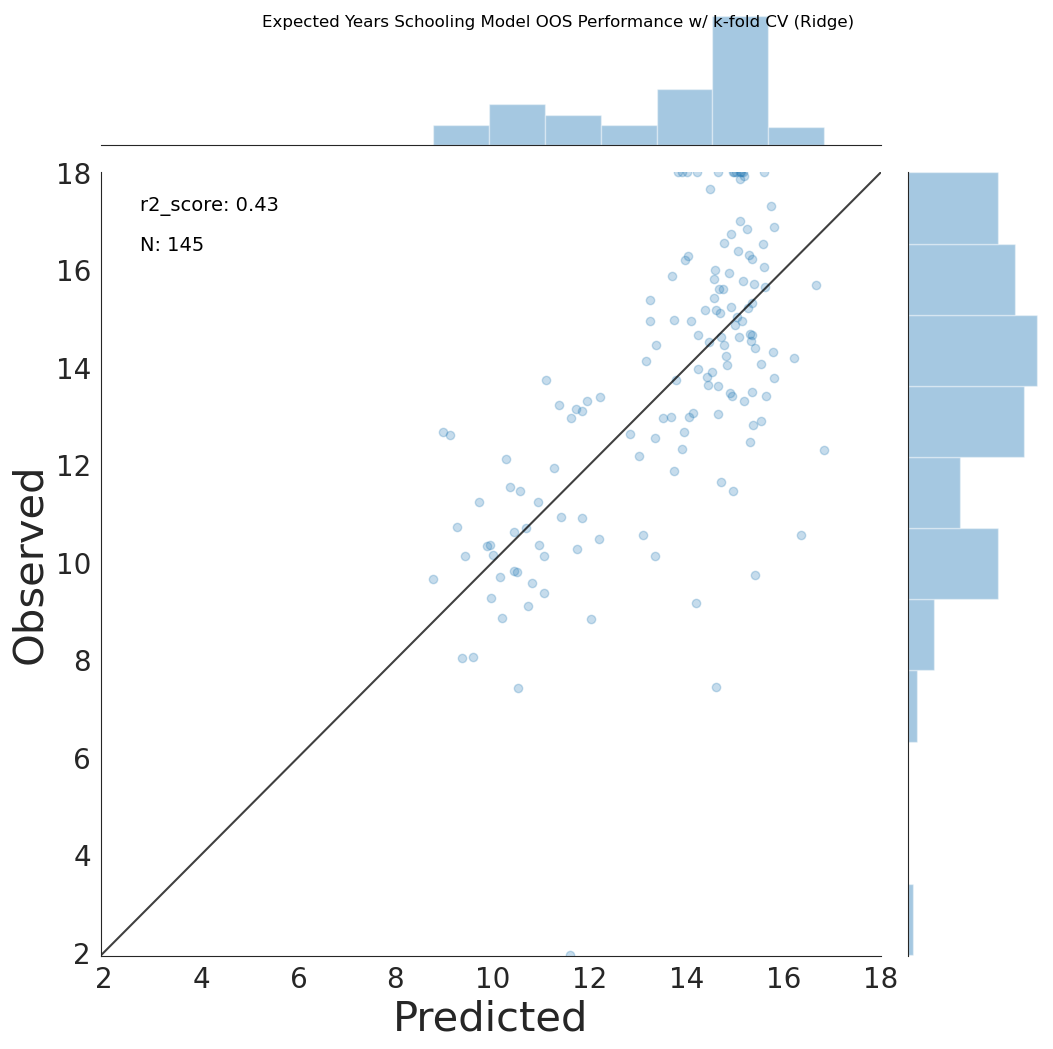

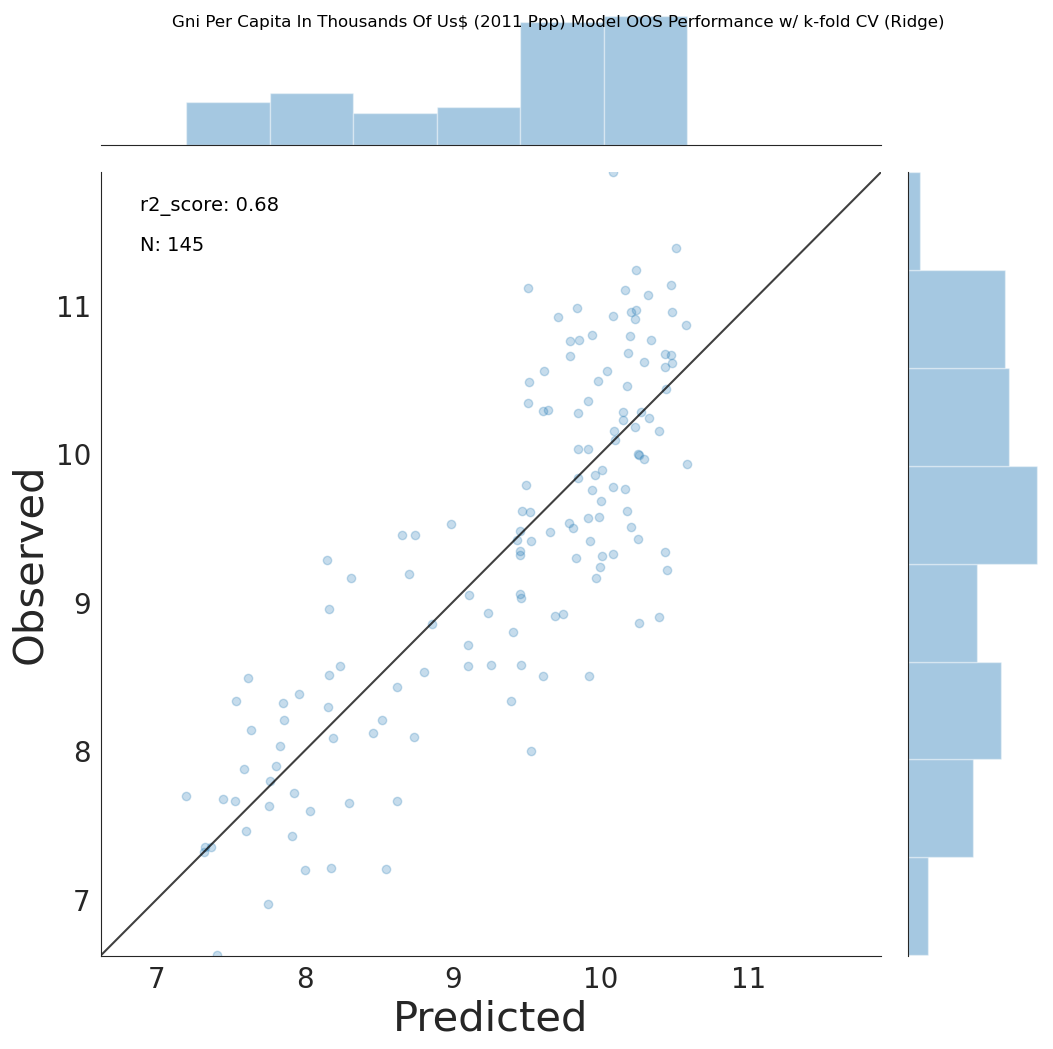

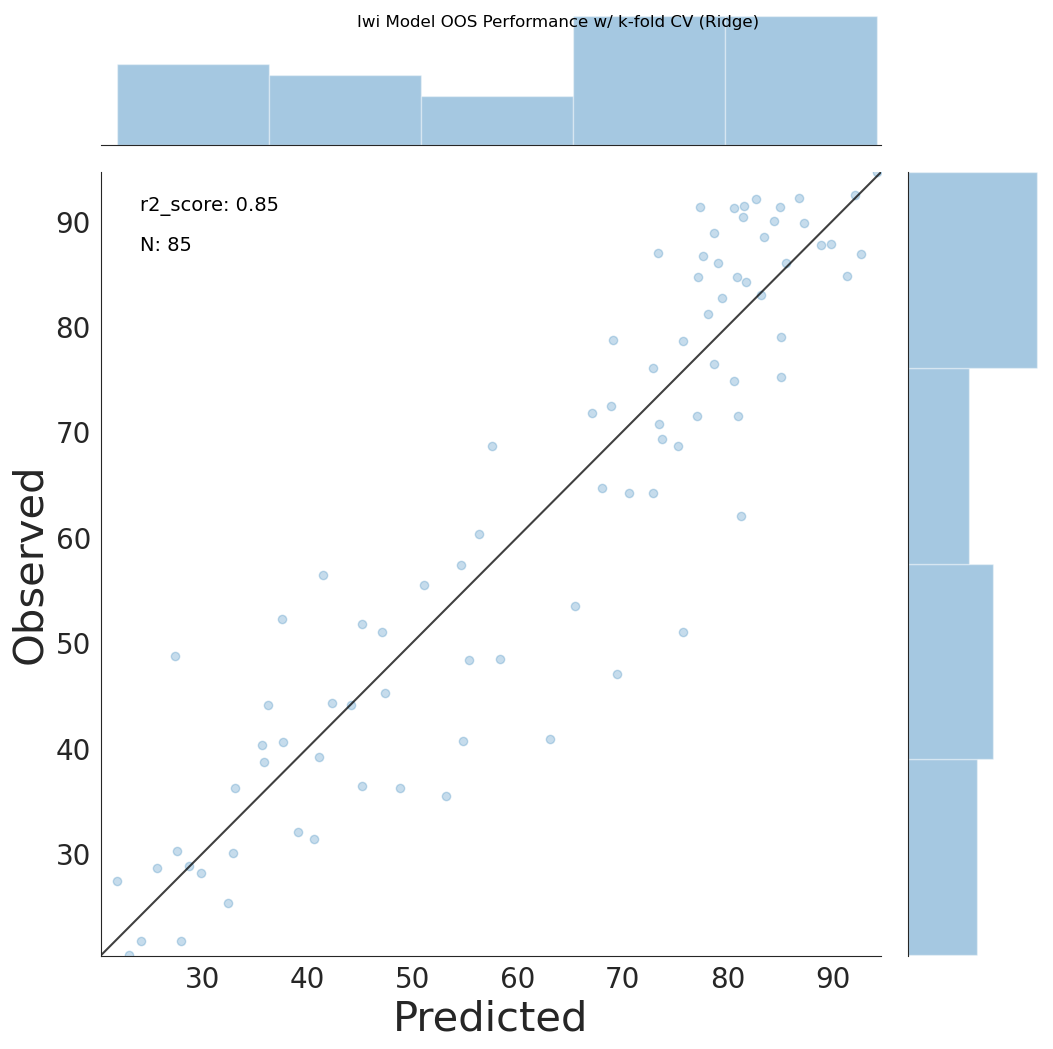

In [17]:
adm0_nl_kfold_dict = {}

for task in tasks:
    Y_train = train_df_adm0[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    
    adm0_nl_kfold_dict[task]  = cv_solve(task,
                                    X_nl_adm0 ,
                                    Y_train,
                                    clip_bounds = [np.min(Y_train), np.max(Y_train)],)

In [37]:
outpath = (model_directory +
           "VIIRS_hist_bins_GHS_pop_weighted.pkl")

pickle.dump(adm0_nl_kfold_dict, open(outpath, "wb"))
adm0_nl_kfold_dict = pickle.load(open(outpath, "rb"))


### Now, we run the ADM0 model with RCF and NL

Sub-national HDI
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.0
3 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.807768676963435
4 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 4.393970560760792
5 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 10.680004325145758
6 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:342: UserWarning: Rescale X2 val is at max of range
  warnings.warn("Rescale X2 val is at max of range")


Plotting Mean years schooling...
Expected years schooling
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.0
3 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.807768676963435
4 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 4.393970560760792
5 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 10.680004325145758
6 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 60 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.0
3 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.807768676963435
4 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 4.393970560760792
5 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 10.680004325145758
6 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 25.958865861263956
7 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3

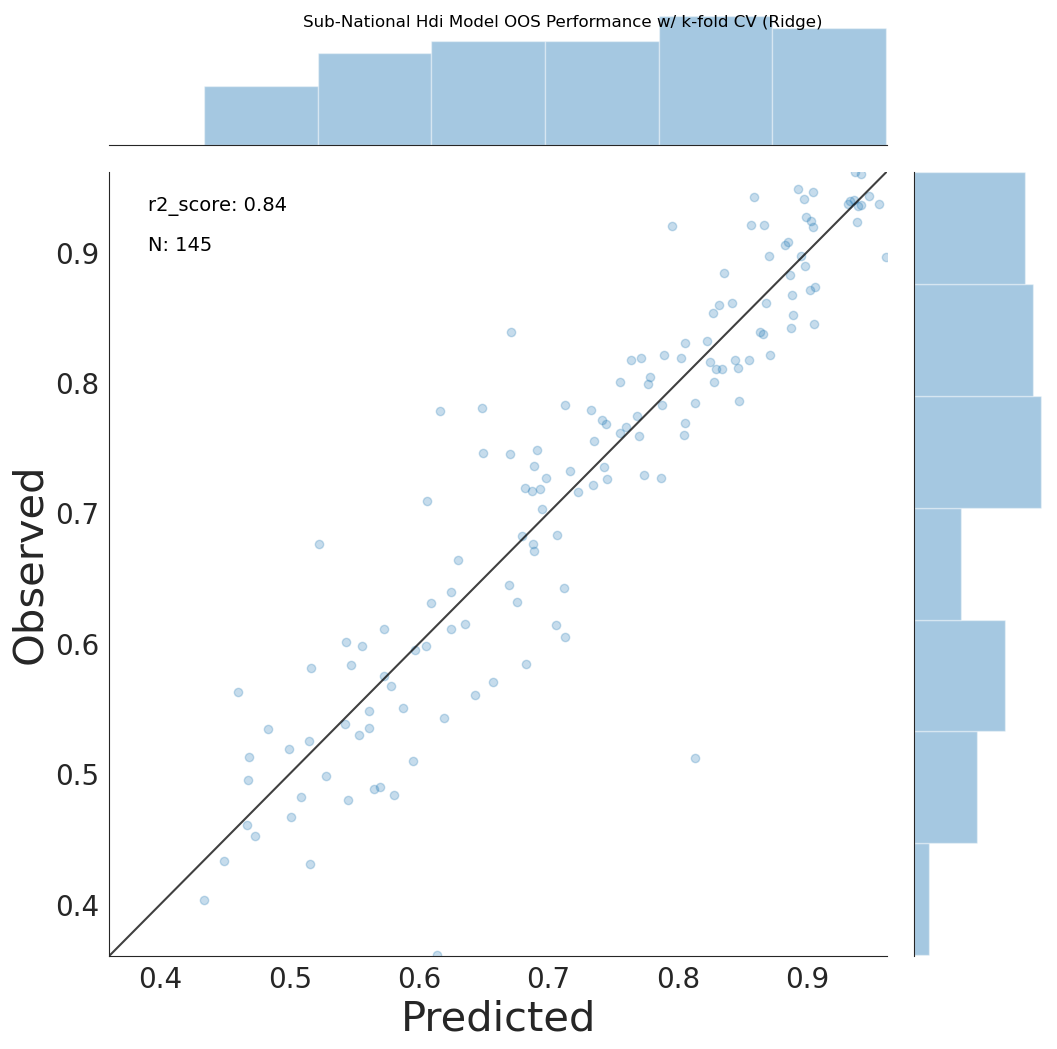

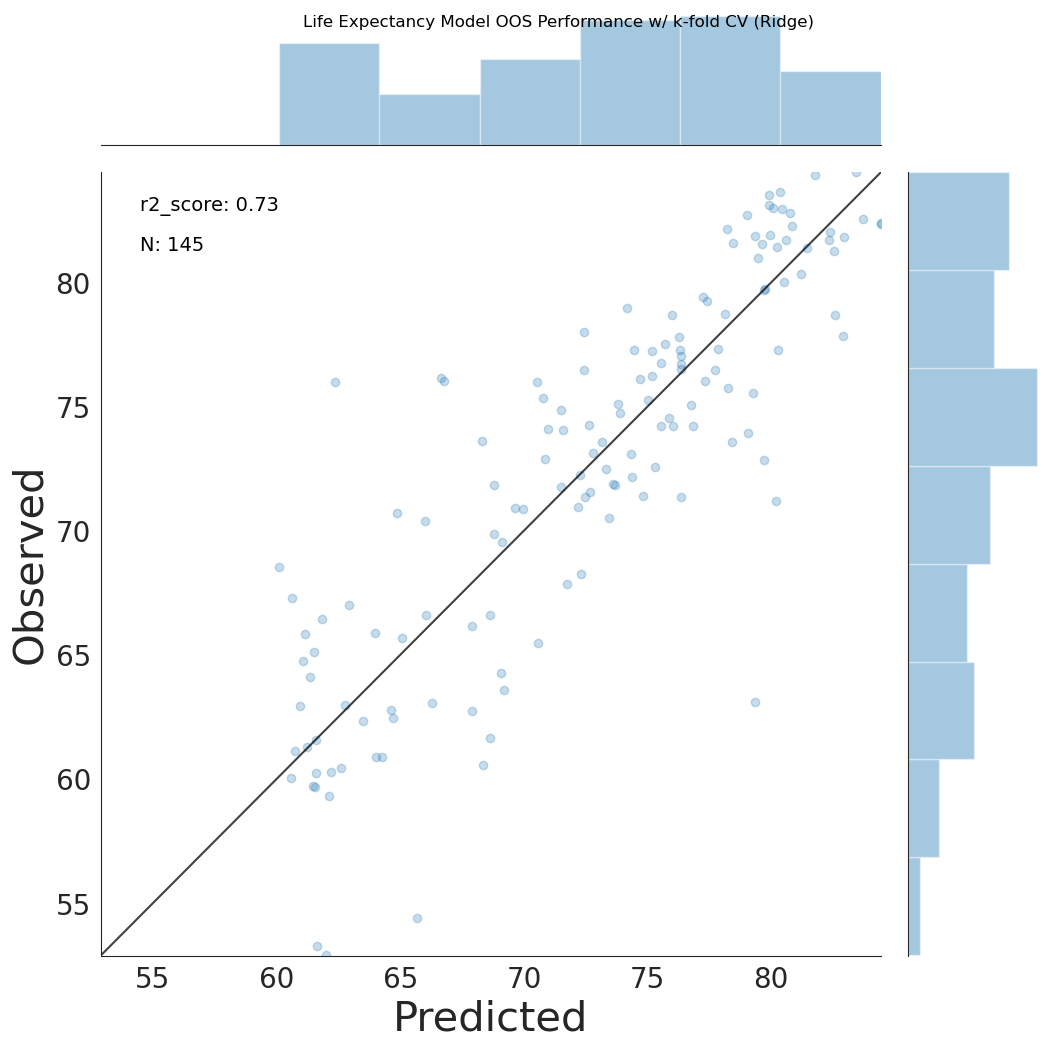

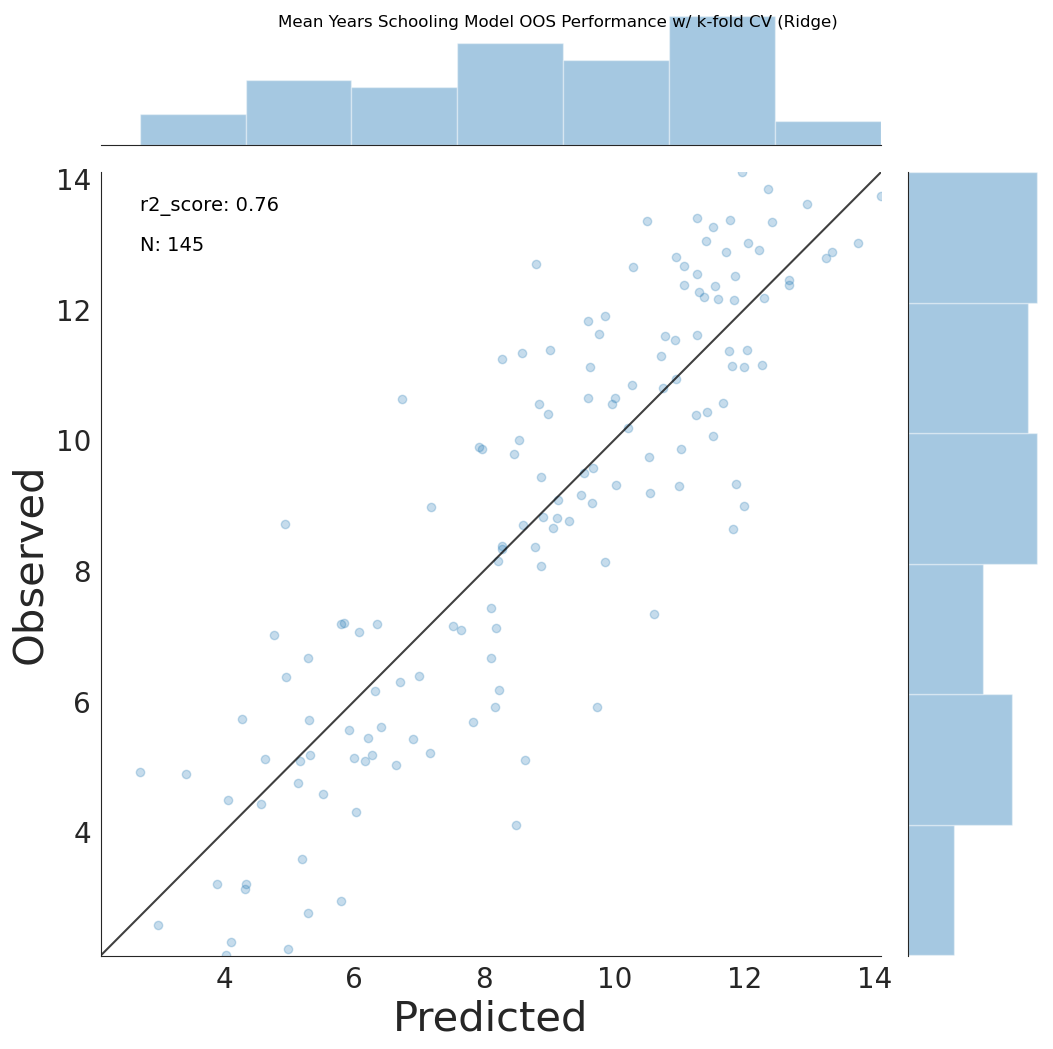

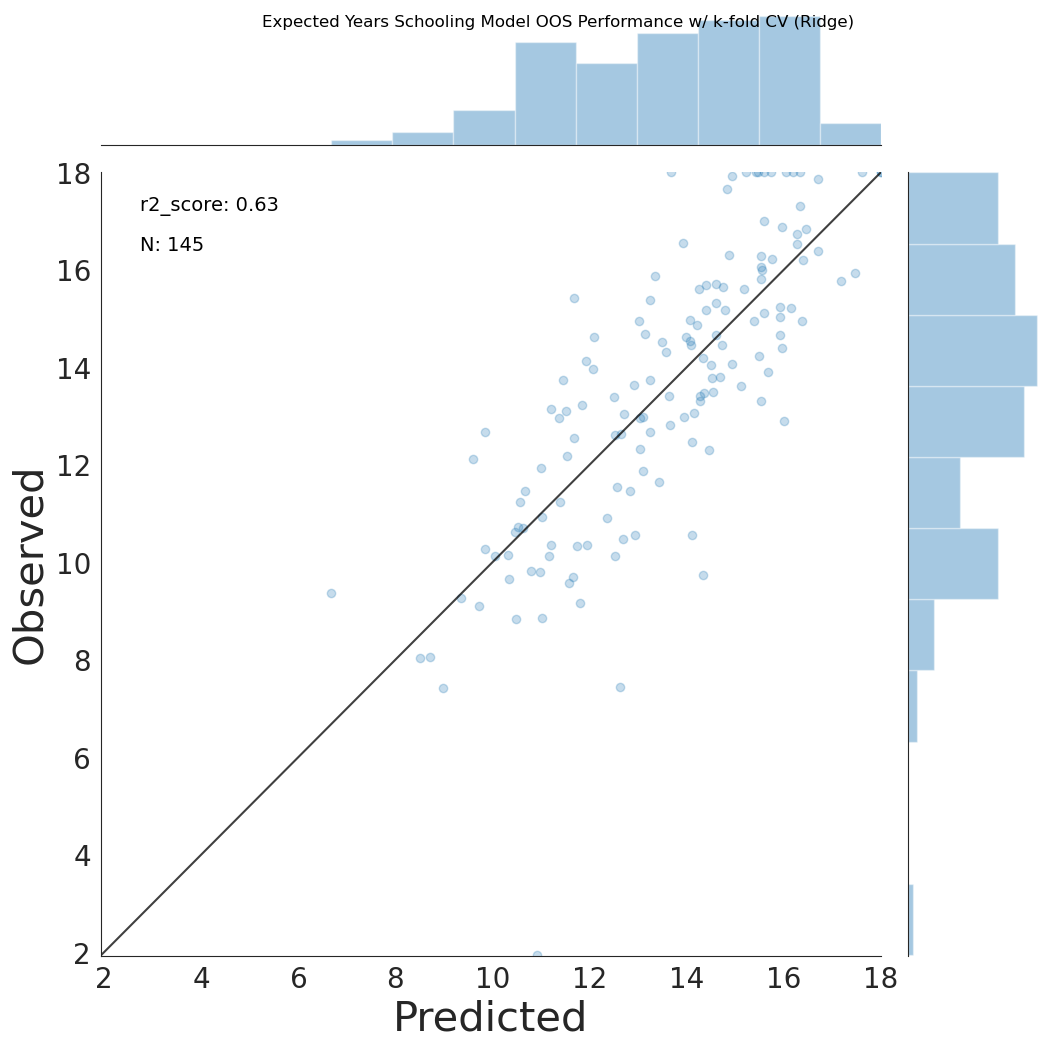

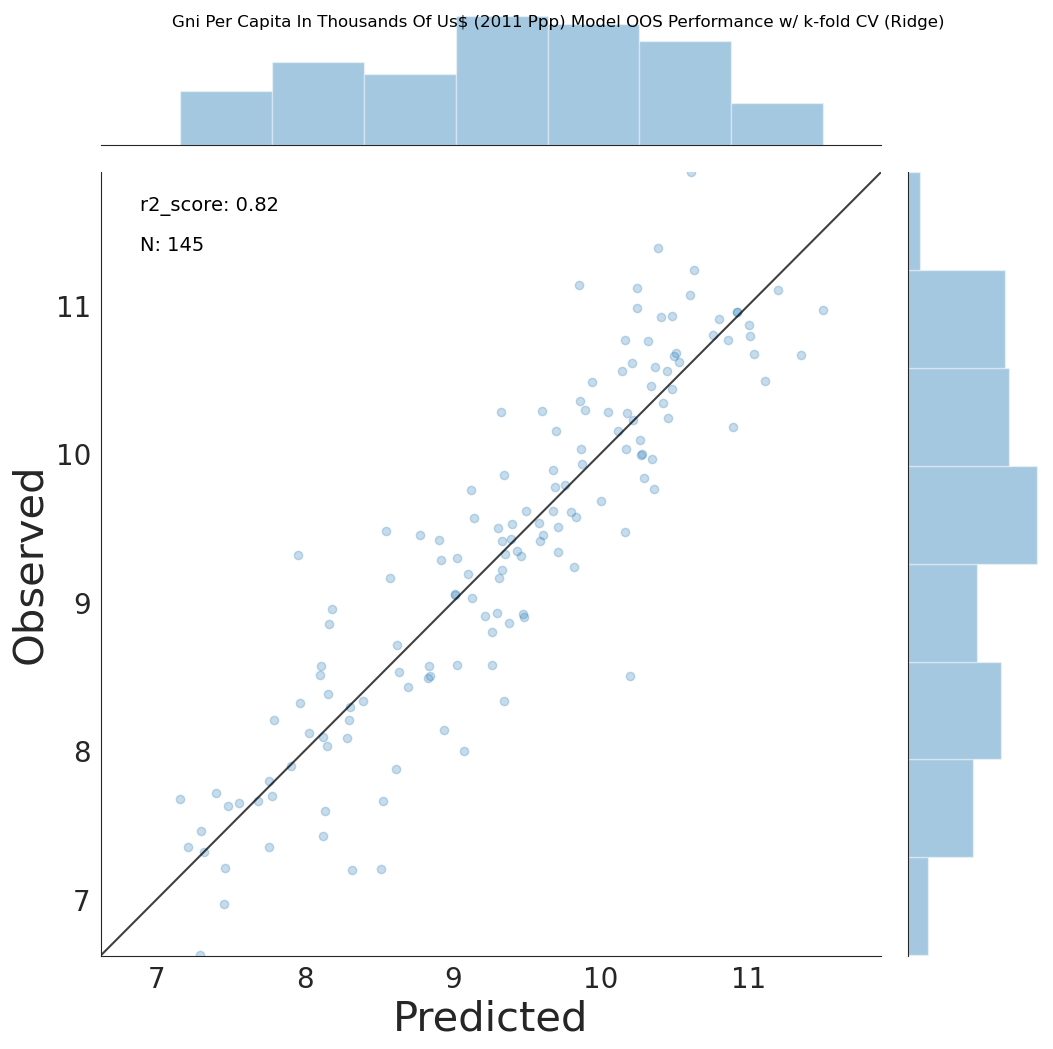

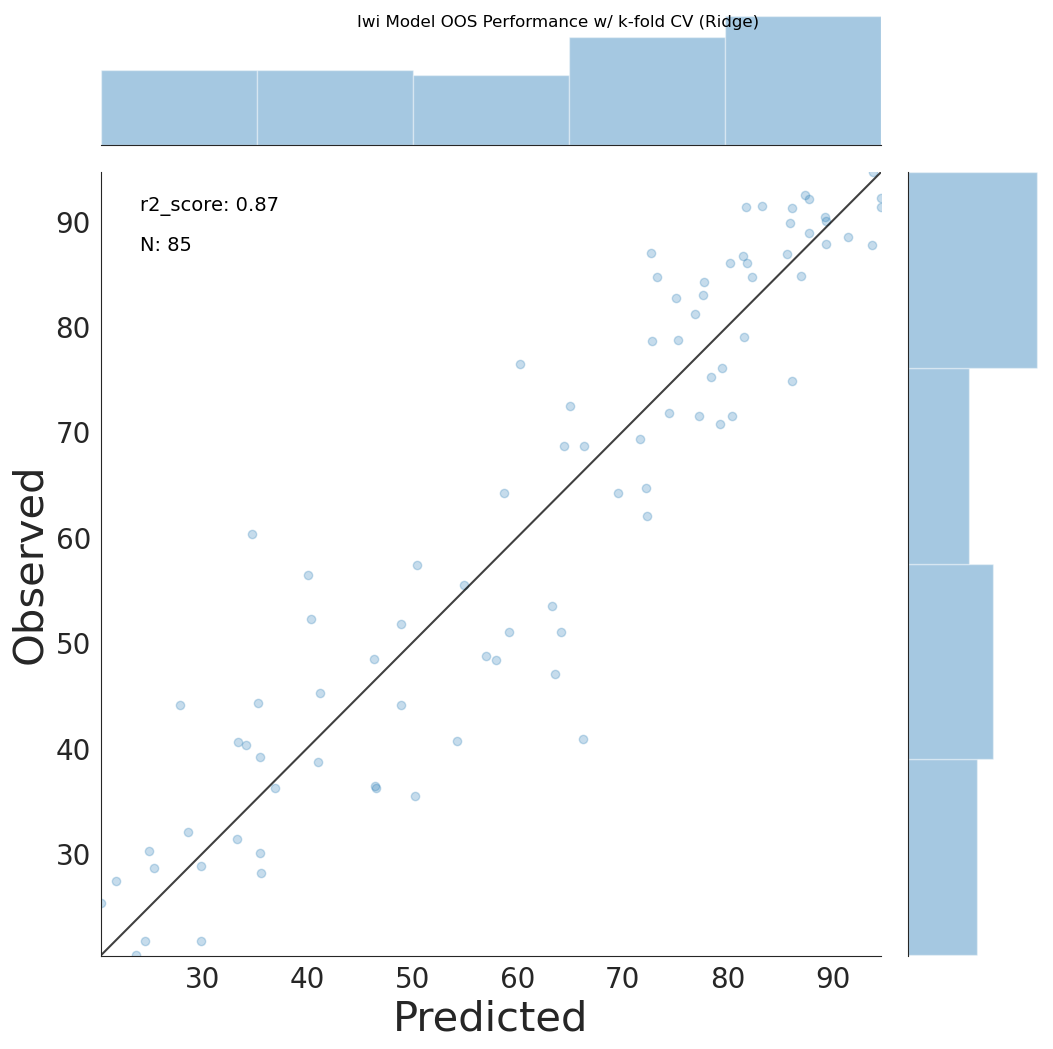

In [15]:
adm0_rcf_nl_kfold_dict = {}

for task in tasks:
    Y_train = train_df_adm0[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    
    adm0_rcf_nl_kfold_dict[task]  = cv_solve(task,
                                    X_train_adm0,
                                    Y_train,
                                    X_train2 = X_nl_adm0,
                                    lambdas2 = rescale_lambdas,         
                                    clip_bounds = [np.min(Y_train), np.max(Y_train)],)

In [38]:
outpath = (model_directory+
           "kfold_solve_adm0_level_GHS_pop_weighted_feats_rcf_nl_VIIRS_hist_bins_GHS_pop_weighted.pkl")

pickle.dump(adm0_rcf_nl_kfold_dict, open(outpath, "wb"))
adm0_rcf_nl_kfold_dict = pickle.load(open(outpath, "rb"))


### Conduct Basic ADM0 to ADM1 Super Resolution Test

In [39]:
def run_preds_from_adm0_model_on_adm1_x(kfold_dict,task,X_for_pred,X_for_pred2=None):
    """
    This function runs predictions from an ADM0 model on an ADM1 observation.
    
    It also ensures that ADM1 predictions are done from the model where the parent country was out of sample.

    (We ensure the that our preds are from within the CV folds)
    
    """
    
    kfold_results = kfold_dict[task]
    best_lam_idx  = ir.interpret_kfold_results(kfold_results, crits="r2_score")[0][0][0]
    
    X_for_pred_countries = pd.Series(X_for_pred.index).apply(lambda x: x[:3])
    
    if X_for_pred2 is not None:
        X_for_pred2 = kfold_results["rescale_X2"] * X_for_pred2
        
        X_for_pred = pd.concat([X_for_pred,X_for_pred2],axis=1)
    
    stack = []
    for i, test_country_array in enumerate(kfold_results["locations_test"]):
        idx_bools = X_for_pred_countries.isin(test_country_array).to_numpy()
        test_set_df = X_for_pred[idx_bools]
        
        weights = kfold_results["models"][i][0][best_lam_idx]
        intercept = kfold_results["intercepts"][i][0][best_lam_idx]
        preds = test_set_df.dot(weights) + intercept
        stack.append(preds)
        
    output = pd.concat(stack).sort_index()
    output = output.clip(*kfold_results["clip_bounds"])
    
    return output

In [40]:
adm0_pred_adm1_rcf_perf_dict = {}
save_adm0_adm1_test_results = {}

for task in tasks:
    print(task)
    
    t = train_df[task].dropna()
    i = t.index
    p = run_preds_from_adm0_model_on_adm1_x(adm0_kfold_dict, task,X_train).loc[i]
    
    task_results = {"truth" : t, "preds": p, "index": i}
    save_adm0_adm1_test_results[task] = task_results
    
    adm0_pred_adm1_rcf_perf_dict[task] = get_within_perf_from_kfold_dict(None,task,metric="ALL",
                                                                          truth=t, preds=p)

Sub-national HDI
Life expectancy
Mean years schooling
Expected years schooling
GNI per capita in thousands of US$ (2011 PPP)
iwi


### Conduct Basic ADM0 to ADM1 Super Resolution Test with NL features

In [41]:
adm0_pred_adm1_nl_perf_dict = {}

for task in tasks:
    print(task)
    
    t = train_df[task].dropna()
    i = t.index
    p = run_preds_from_adm0_model_on_adm1_x(adm0_nl_kfold_dict, task,X_nl).loc[i]

    
    task_results = {"truth" : t, "preds": p, "index": i}
    save_adm0_adm1_test_results[task] = task_results
    
    adm0_pred_adm1_nl_perf_dict[task] = get_within_perf_from_kfold_dict(None,task,metric="ALL",
                                                                          truth=t, preds=p)

Sub-national HDI
Life expectancy
Mean years schooling
Expected years schooling
GNI per capita in thousands of US$ (2011 PPP)
iwi
The optimal hyperparameter is the lowest of the acceptable (i.e. no precision warnings) hyperparameters supplied. It is index 0 of the orignal hyperparamters passed in. For reference, 10 of 10 hyperparamters are considered acceptable; their indices  are [0 1 2 3 4 5 6 7 8 9].


### Conduct Basic ADM0 to ADM1 Super Resolution Test with RCF + NL feats

In [42]:
adm0_pred_adm1_rcf_nl_perf_dict = {}

for task in tasks:
    print(task)
    
    t = train_df[task].dropna()
    i = t.index
    p = run_preds_from_adm0_model_on_adm1_x(adm0_rcf_nl_kfold_dict, task,X_train,X_nl).loc[i]

    
    task_results = {"truth" : t, "preds": p, "index": i}
    save_adm0_adm1_test_results[task] = task_results
    
    adm0_pred_adm1_rcf_nl_perf_dict[task] = get_within_perf_from_kfold_dict(None,task,metric="ALL",
                                                                          truth=t, preds=p)

Sub-national HDI
Life expectancy
Mean years schooling
Expected years schooling
GNI per capita in thousands of US$ (2011 PPP)
iwi


## Summary Tables

In [43]:
rename_dict = {"pearson": "$\rho^{2}$", "spearman":"Spearman r", "r2":"$R^{2}$",
               "within_adm0_pearson": "$\rho^{2}$", "within_adm0_spearman":"Spearman r", "within_adm0_r2":"$R^{2}$",
    
}

In [44]:
def make_table_from_task(task, var_name=""):
    outcomes_dicts =[

    adm0_pred_adm1_rcf_perf_dict,
    adm0_pred_adm1_nl_perf_dict,
    adm0_pred_adm1_rcf_nl_perf_dict,

    cc_rcf_perf_dict,
    cc_nl_perf_dict,
    cc_nl_and_rcf_perf_dict,

    demean_rcf_perf_dict,
    demean_nl_perf_dict,
    demeaned_nl_and_rcf_demeaned_perf_dict

    ]

    outcomes = [outcome[task] for outcome in outcomes_dicts]

    table = pd.DataFrame(outcomes).round(2)
    table[table <= 0] = "$< 0$"

    table = table.rename(columns = rename_dict)

    table = table.rename(columns = rename_dict)

    table.loc[0:2,"HDI"] = "\textbf{Country level} " + "(n={:,})".format(n_adm0[task])
    table.loc[3:5,"HDI"] = "\textbf{Province level} " + "(n={:,})".format(n_adm1[task])
    table.loc[6:8,"HDI"] = "\textbf{Within-country} " + "(n={:,})".format(n_demean[task])

    table.loc[0:2,""] = ["\textbf{MOSAIKS}","\textbf{VIIRS}","\textbf{MOSAIKS+VIIRS}"]
    table.loc[3:5,""] = ["\textbf{MOSAIKS}","\textbf{VIIRS}","\textbf{MOSAIKS+VIIRS}"]
    table.loc[6:8,""] = ["\textbf{MOSAIKS}","\textbf{VIIRS}","\textbf{MOSAIKS+VIIRS}"]

    table.loc[9] = "\textbf{Predicted at province level}"


    table.loc[10] = "\emph{Full variation performance} " + "(n={:,})".format(n_adm1[task])
    table.iloc[10,3:6] = "\emph{Within-country performance} " + "(n={:,})".format(n_demean[task])
    
    table.drop(columns="Spearman r", inplace=True)
    
    table.loc[11] = ("(" + pd.Series(np.arange(1,table.shape[1]+1)).astype(str) +")").to_numpy()
    
    table = table.T.reset_index().set_index([9,10,"index",11])

    tab = table.T

    tab.columns.names = ([None, None, None,None])

    table = tab.set_index([tab.columns[-2],tab.columns[-1]])

    table.index.names =["\emph{ \textbf{" + var_name + " trained at:}}", "\emph{ \textbf{Features}}"]
    
    table = table.iloc[[8,6,7,5,3,4,2,0,1]]

    print(table.to_latex(bold_rows=False,column_format="ll||cc|cc",
          escape=False, multicolumn_format="c")  )

    return table



## HDI

In [45]:
make_table_from_task(tasks[0], var_name="HDI") #Make Table for HDI

\begin{tabular}{ll||cc|cc}
\toprule
                               &                & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                               &                & \multicolumn{2}{c}{\emph{Full variation performance} (n=1,381)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=1,363)} \\
                               &                &                                  $\rho^{2}$ & $R^{2}$ &                                  $\rho^{2}$ & $R^{2}$ \\
                               &                &                                         (1) &     (2) &                                         (3) &     (4) \\
\emph{ \textbf{HDI trained at:}} & \emph{ \textbf{Features}} &                                             &         &                                             &         \\
\midrule
\textbf{Within-country} (n=1,363) & \textbf{MOSAIKS+VIIRS} &                                        0.96 &    0.96 &                                        0.52

\textbf{Predicted at province level}  \
                                                            \emph{Full variation performance} (n=1,381)   
                                                                                             $\rho^{2}$   
                                                                                                    (1)   
\emph{ \textbf{HDI trained at:}}  \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,363) \textbf{MOSAIKS+VIIRS}                                           0.96   
                                  \textbf{MOSAIKS}                                                 0.95   
                                  \textbf{VIIRS}                                                   0.95   
\textbf{Province level} (n=1,381) \textbf{MOSAIKS+VIIRS}                                           0.83   
                                  \textbf{MOSAIKS}                                                 0.76   
                                  \textbf{VIIRS}                                                    0.6   
\textbf{Country level} (n=145)    \textbf{MOSAIKS+VIIRS}                                           0.74   
                                  \textbf{MOSAIKS}                                                 0.62   
                                  \textbf{VIIRS}                                                   0.59   

                                                                     \
                                                                      
                                                            $R^{2}$   
                                                                (2)   
\emph{ \textbf{HDI trained at:}}  \emph{ \textbf{Features}}           
\textbf{Within-country} (n=1,363) \textbf{MOSAIKS+VIIRS}       0.96   
                                  \textbf{MOSAIKS}             0.95   
                                  \textbf{VIIRS}               0.95   
\textbf{Province level} (n=1,381) \textbf{MOSAIKS+VIIRS}       0.83   
                                  \textbf{MOSAIKS}             0.75   
                                  \textbf{VIIRS}                0.6   
\textbf{Country level} (n=145)    \textbf{MOSAIKS+VIIRS}       0.74   
                                  \textbf{MOSAIKS}             0.58   
                                  \textbf{VIIRS}               0.53   

                                                                                                         \
                                                            \emph{Within-country performance} (n=1,363)   
                                                                                             $\rho^{2}$   
                                                                                                    (3)   
\emph{ \textbf{HDI trained at:}}  \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,363) \textbf{MOSAIKS+VIIRS}                                           0.52   
                                  \textbf{MOSAIKS}                                                 0.42   
                                  \textbf{VIIRS}                                                   0.45   
\textbf{Province level} (n=1,381) \textbf{MOSAIKS+VIIRS}                                           0.44   
                                  \textbf{MOSAIKS}                                                 0.31   
                                  \textbf{VIIRS}                                                   0.44   
\textbf{Country level} (n=145)    \textbf{MOSAIKS+VIIRS}                                           0.28   
                                  \textbf{MOSAIKS}                                                 0.16   
                                  \textbf{VIIRS}                                                   0.44   

                                                                     
    

## HDI components

In [46]:
make_table_from_task(tasks[1], "Life expectancy")

\begin{tabular}{ll||cc|cc}
\toprule
                               &                & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                               &                & \multicolumn{2}{c}{\emph{Full variation performance} (n=1,381)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=1,363)} \\
                               &                &                                  $\rho^{2}$ & $R^{2}$ &                                  $\rho^{2}$ & $R^{2}$ \\
                               &                &                                         (1) &     (2) &                                         (3) &     (4) \\
\emph{ \textbf{Life expectancy trained at:}} & \emph{ \textbf{Features}} &                                             &         &                                             &         \\
\midrule
\textbf{Within-country} (n=1,363) & \textbf{MOSAIKS+VIIRS} &                                        0.92 &    0.92 &                                

\textbf{Predicted at province level}  \
                                                                       \emph{Full variation performance} (n=1,381)   
                                                                                                        $\rho^{2}$   
                                                                                                               (1)   
\emph{ \textbf{Life expectancy trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,363)            \textbf{MOSAIKS+VIIRS}                                           0.92   
                                             \textbf{MOSAIKS}                                                 0.92   
                                             \textbf{VIIRS}                                                   0.92   
\textbf{Province level} (n=1,381)            \textbf{MOSAIKS+VIIRS}                                           0.69   
                                             \textbf{MOSAIKS}                                                 0.66   
                                             \textbf{VIIRS}                                                   0.43   
\textbf{Country level} (n=145)               \textbf{MOSAIKS+VIIRS}                                            0.6   
                                             \textbf{MOSAIKS}                                                 0.57   
                                             \textbf{VIIRS}                                                   0.42   

                                                                                \
                                                                                 
                                                                       $R^{2}$   
                                                                           (2)   
\emph{ \textbf{Life expectancy trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country} (n=1,363)            \textbf{MOSAIKS+VIIRS}       0.92   
                                             \textbf{MOSAIKS}             0.92   
                                             \textbf{VIIRS}               0.92   
\textbf{Province level} (n=1,381)            \textbf{MOSAIKS+VIIRS}       0.69   
                                             \textbf{MOSAIKS}             0.66   
                                             \textbf{VIIRS}               0.43   
\textbf{Country level} (n=145)               \textbf{MOSAIKS+VIIRS}       0.57   
                                             \textbf{MOSAIKS}             0.53   
                                             \textbf{VIIRS}               0.32   

                                                                                                                    \
                                                                       \emph{Within-country performance} (n=1,363)   
                                                                                                        $\rho^{2}$   
                                                                                                               (3)   
\emph{ \textbf{Life expectancy trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,363)            \textbf{MOSAIKS+VIIRS}                                           0.05   
                                             \textbf{MOSAIKS}                                                 0.01   
                                             \textbf{VIIRS}                                                   0.05   
\textbf{Province level} (n=1,381)            \textbf{MOSAIKS+VIIRS}                                           0.03   
                                             \textbf{MOSAIKS}                                                 0.02   
                                             \textbf{VIIRS}                                     

In [47]:
make_table_from_task(tasks[2], "Mean years schooling")

\begin{tabular}{ll||cc|cc}
\toprule
                               &                & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                               &                & \multicolumn{2}{c}{\emph{Full variation performance} (n=1,381)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=1,363)} \\
                               &                &                                  $\rho^{2}$ & $R^{2}$ &                                  $\rho^{2}$ & $R^{2}$ \\
                               &                &                                         (1) &     (2) &                                         (3) &     (4) \\
\emph{ \textbf{Mean years schooling trained at:}} & \emph{ \textbf{Features}} &                                             &         &                                             &         \\
\midrule
\textbf{Within-country} (n=1,363) & \textbf{MOSAIKS+VIIRS} &                                        0.93 &    0.93 &                           

\textbf{Predicted at province level}  \
                                                                            \emph{Full variation performance} (n=1,381)   
                                                                                                             $\rho^{2}$   
                                                                                                                    (1)   
\emph{ \textbf{Mean years schooling trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,363)                 \textbf{MOSAIKS+VIIRS}                                           0.93   
                                                  \textbf{MOSAIKS}                                                 0.91   
                                                  \textbf{VIIRS}                                                   0.92   
\textbf{Province level} (n=1,381)                 \textbf{MOSAIKS+VIIRS}                                           0.75   
                                                  \textbf{MOSAIKS}                                                  0.7   
                                                  \textbf{VIIRS}                                                   0.56   
\textbf{Country level} (n=145)                    \textbf{MOSAIKS+VIIRS}                                           0.73   
                                                  \textbf{MOSAIKS}                                                  0.6   
                                                  \textbf{VIIRS}                                                   0.56   

                                                                                     \
                                                                                      
                                                                            $R^{2}$   
                                                                                (2)   
\emph{ \textbf{Mean years schooling trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country} (n=1,363)                 \textbf{MOSAIKS+VIIRS}       0.93   
                                                  \textbf{MOSAIKS}             0.91   
                                                  \textbf{VIIRS}               0.92   
\textbf{Province level} (n=1,381)                 \textbf{MOSAIKS+VIIRS}       0.75   
                                                  \textbf{MOSAIKS}              0.7   
                                                  \textbf{VIIRS}               0.56   
\textbf{Country level} (n=145)                    \textbf{MOSAIKS+VIIRS}       0.72   
                                                  \textbf{MOSAIKS}              0.6   
                                                  \textbf{VIIRS}               0.53   

                                                                                                                         \
                                                                            \emph{Within-country performance} (n=1,363)   
                                                                                                             $\rho^{2}$   
                                                                                                                    (3)   
\emph{ \textbf{Mean years schooling trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,363)                 \textbf{MOSAIKS+VIIRS}                                           0.51   
                                                  \textbf{MOSAIKS}                                                 0.41   
                                                  \textbf{VIIRS}                                                   0.45   
\textbf{Province level} (n=1,381)                 \textbf{MOSAIKS+VIIRS}                                           0.49   
                                  

In [48]:
make_table_from_task(tasks[3], "Expected years schooling")

\begin{tabular}{ll||cc|cc}
\toprule
                               &                & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                               &                & \multicolumn{2}{c}{\emph{Full variation performance} (n=1,381)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=1,363)} \\
                               &                &                                  $\rho^{2}$ & $R^{2}$ &                                  $\rho^{2}$ & $R^{2}$ \\
                               &                &                                         (1) &     (2) &                                         (3) &     (4) \\
\emph{ \textbf{Expected years schooling trained at:}} & \emph{ \textbf{Features}} &                                             &         &                                             &         \\
\midrule
\textbf{Within-country} (n=1,363) & \textbf{MOSAIKS+VIIRS} &                                         0.9 &     0.9 &                       

\textbf{Predicted at province level}  \
                                                                             \emph{Full variation performance} (n=1,381)   
                                                                                                              $\rho^{2}$   
                                                                                                                     (1)   
\emph{ \textbf{Expected years schooling trained... \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,363)                  \textbf{MOSAIKS+VIIRS}                                            0.9   
                                                   \textbf{MOSAIKS}                                                 0.89   
                                                   \textbf{VIIRS}                                                   0.88   
\textbf{Province level} (n=1,381)                  \textbf{MOSAIKS+VIIRS}                                           0.56   
                                                   \textbf{MOSAIKS}                                                  0.5   
                                                   \textbf{VIIRS}                                                   0.39   
\textbf{Country level} (n=145)                     \textbf{MOSAIKS+VIIRS}                                           0.54   
                                                   \textbf{MOSAIKS}                                                 0.44   
                                                   \textbf{VIIRS}                                                   0.38   

                                                                                      \
                                                                                       
                                                                             $R^{2}$   
                                                                                 (2)   
\emph{ \textbf{Expected years schooling trained... \emph{ \textbf{Features}}           
\textbf{Within-country} (n=1,363)                  \textbf{MOSAIKS+VIIRS}        0.9   
                                                   \textbf{MOSAIKS}             0.89   
                                                   \textbf{VIIRS}               0.88   
\textbf{Province level} (n=1,381)                  \textbf{MOSAIKS+VIIRS}       0.56   
                                                   \textbf{MOSAIKS}              0.5   
                                                   \textbf{VIIRS}               0.39   
\textbf{Country level} (n=145)                     \textbf{MOSAIKS+VIIRS}       0.53   
                                                   \textbf{MOSAIKS}             0.41   
                                                   \textbf{VIIRS}               0.35   

                                                                                                                          \
                                                                             \emph{Within-country performance} (n=1,363)   
                                                                                                              $\rho^{2}$   
                                                                                                                     (3)   
\emph{ \textbf{Expected years schooling trained... \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,363)                  \textbf{MOSAIKS+VIIRS}                                           0.28   
                                                   \textbf{MOSAIKS}                                                 0.27   
                                                   \textbf{VIIRS}                                                   0.15   
\textbf{Province level} (n=1,381)                  \textbf{MOSAIKS+VIIRS}                                           0.21  

In [49]:
make_table_from_task(tasks[4], "GNIpc")

\begin{tabular}{ll||cc|cc}
\toprule
                               &                & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                               &                & \multicolumn{2}{c}{\emph{Full variation performance} (n=1,381)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=1,363)} \\
                               &                &                                  $\rho^{2}$ & $R^{2}$ &                                  $\rho^{2}$ & $R^{2}$ \\
                               &                &                                         (1) &     (2) &                                         (3) &     (4) \\
\emph{ \textbf{GNIpc trained at:}} & \emph{ \textbf{Features}} &                                             &         &                                             &         \\
\midrule
\textbf{Within-country} (n=1,363) & \textbf{MOSAIKS+VIIRS} &                                        0.97 &    0.97 &                                        0.

\textbf{Predicted at province level}  \
                                                             \emph{Full variation performance} (n=1,381)   
                                                                                              $\rho^{2}$   
                                                                                                     (1)   
\emph{ \textbf{GNIpc trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,363)  \textbf{MOSAIKS+VIIRS}                                           0.97   
                                   \textbf{MOSAIKS}                                                 0.95   
                                   \textbf{VIIRS}                                                   0.96   
\textbf{Province level} (n=1,381)  \textbf{MOSAIKS+VIIRS}                                           0.79   
                                   \textbf{MOSAIKS}                                                 0.68   
                                   \textbf{VIIRS}                                                   0.59   
\textbf{Country level} (n=145)     \textbf{MOSAIKS+VIIRS}                                           0.56   
                                   \textbf{MOSAIKS}                                                 0.46   
                                   \textbf{VIIRS}                                                   0.31   

                                                                      \
                                                                       
                                                             $R^{2}$   
                                                                 (2)   
\emph{ \textbf{GNIpc trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country} (n=1,363)  \textbf{MOSAIKS+VIIRS}       0.97   
                                   \textbf{MOSAIKS}             0.95   
                                   \textbf{VIIRS}               0.96   
\textbf{Province level} (n=1,381)  \textbf{MOSAIKS+VIIRS}       0.79   
                                   \textbf{MOSAIKS}             0.68   
                                   \textbf{VIIRS}               0.59   
\textbf{Country level} (n=145)     \textbf{MOSAIKS+VIIRS}      $< 0$   
                                   \textbf{MOSAIKS}            $< 0$   
                                   \textbf{VIIRS}              $< 0$   

                                                                                                          \
                                                             \emph{Within-country performance} (n=1,363)   
                                                                                              $\rho^{2}$   
                                                                                                     (3)   
\emph{ \textbf{GNIpc trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,363)  \textbf{MOSAIKS+VIIRS}                                           0.56   
                                   \textbf{MOSAIKS}                                                  0.4   
                                   \textbf{VIIRS}                                                   0.55   
\textbf{Province level} (n=1,381)  \textbf{MOSAIKS+VIIRS}                                           0.36   
                                   \textbf{MOSAIKS}                                                 0.25   
                                   \textbf{VIIRS}                                                   0.52   
\textbf{Country level} (n=145)     \textbf{MOSAIKS+VIIRS}                                           0.23   
                                   \textbf{MOSAIKS}                                                  0.1   
                                   \textbf{VIIRS}                                                   0.12   

                                 